# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm
from sklearn.metrics import roc_auc_score


import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IM

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


## Helper functions


### Binary Accuracy


In [3]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()

    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [4]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [5]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [6]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [7]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [8]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [9]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()
    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]
            predictions = model(inputs).squeeze(1)

            label = lab.to(dev)
            # label = label.unsqueeze(1)
            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [10]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [11]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Multi-Head Attention


In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
    ):
        super(MultiHeadedAttention, self).__init__()
        assert (
            embed_dim % num_heads == 0
        ), f"Embedding dimension ({embed_dim}) should be divisible by number of heads ({num_heads})"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        # The linear layers for the query, key, and value projections
        self.linears = get_clones(nn.Linear(embed_dim, embed_dim, bias=use_bias), 3)
        # The linear layer to combine the heads
        self.combine_heads = nn.Linear(embed_dim, embed_dim, bias=use_bias)
        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        # 1) Do all the linear projections in batch from embed_dim => num_heads x dim_k
        query, key, value = [
            lin(x).view(batch_size, -1, self.num_heads, self.dim_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x: Tensor
        x, self.attn_weights = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)
        x = self.combine_heads(x)
        return x

### Feed-Forward Network


In [13]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(self, embed_dim: int, ffn_dim: int, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(embed_dim, ffn_dim)
        self.linear_2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        x = self.linear_1(x).relu()
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Encoder


In [14]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
    ):
        super(Encoder, self).__init__()

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, mask=mask
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(embed_dim, ffn_dim, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output: Tensor = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [15]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        max_seq_len: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        ffn_dim=32,
        dropout=0.1,
    ):
        super(TextClassifier, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        self.transformers = get_clones(
            Encoder(embed_dim, num_heads, ffn_dim), num_blocks
        )
        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # x = self.dropout1(x)

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [16]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split


def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=20,
    lr=0.001,
    embed_dim=8,
    num_heads=4,
    num_blocks=6,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    dropout=0.1,
):

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    # size = total_size
    # train_data = np.array(train_data)[
    #     np.random.choice(len(train_data), size=size, replace=False)
    # ].tolist()
    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("train pos: ", len([label for label, text in train_data if label == 1]))
    print("train neg: ", len([label for label, text in train_data if label == 2]))
    print("test pos: ", len([label for label, text in test_data if label == 1]))
    print("test neg: ", len([label for label, text in test_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")

    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    # train_loader = DataLoader(
    #     train_data,
    #     batch_sampler=batch_sampler(train_data, batch_size, tokenizer),
    #     collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    # )

    # test_loader = DataLoader(
    #     test_data,
    #     batch_sampler=batch_sampler(test_data, batch_size, tokenizer),
    #     collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    # )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        dropout=dropout,
        max_seq_len=max_seq_len,
    )
    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0

    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            # print(f"Epoch {iepoch+1}/{n_epochs}")
            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )
            # GPUtil.showUtilization()

            scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

            # print(f"Epoch: {iepoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            # print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
            # print(f"\tTest Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%")

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [17]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main()

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


train pos:  9985
train neg:  10015
test pos:  2515
test neg:  2485


++ There will be 6 transformer blocks
The model has 403,417 trainable parameters


Epoch   1/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   1/20:   0%|          | 32/20000 [00:00<02:47, 119.27batch/s]            

Epoch   1/20:   1%|          | 192/20000 [00:00<00:32, 600.40batch/s]           

Epoch   1/20:   2%|▏         | 352/20000 [00:00<00:22, 889.90batch/s]           

Epoch   1/20:   3%|▎         | 512/20000 [00:00<00:17, 1082.84batch/s]          

Epoch   1/20:   3%|▎         | 672/20000 [00:00<00:16, 1199.84batch/s]          

Epoch   1/20:   4%|▍         | 832/20000 [00:00<00:14, 1295.92batch/s]          

Epoch   1/20:   5%|▍         | 992/20000 [00:00<00:14, 1344.23batch/s]          

Epoch   1/20:   6%|▌         | 1152/20000 [00:01<00:13, 1387.93batch/s]         

Epoch   1/20:   7%|▋         | 1312/20000 [00:01<00:13, 1416.50batch/s]         

Epoch   1/20:   7%|▋         | 1472/20000 [00:01<00:13, 1423.34batch/s]         

Epoch   1/20:   8%|▊         | 1632/20000 [00:01<00:12, 1443.01batch/s]         

Epoch   1/20:   9%|▉         | 1792/20000 [00:01<00:12, 1440.04batch/s]         

Epoch   1/20:  10%|▉         | 1952/20000 [00:01<00:12, 1444.19batch/s]         

Epoch   1/20:  11%|█         | 2112/20000 [00:01<00:12, 1459.14batch/s]         

Epoch   1/20:  11%|█▏        | 2272/20000 [00:01<00:12, 1438.43batch/s]         

Epoch   1/20:  12%|█▏        | 2432/20000 [00:01<00:12, 1452.18batch/s]         

Epoch   1/20:  13%|█▎        | 2592/20000 [00:02<00:11, 1465.54batch/s]         

Epoch   1/20:  14%|█▍        | 2752/20000 [00:02<00:11, 1467.30batch/s]         

Epoch   1/20:  15%|█▍        | 2912/20000 [00:02<00:11, 1469.96batch/s]         

Epoch   1/20:  15%|█▌        | 3072/20000 [00:02<00:11, 1477.50batch/s]         

Epoch   1/20:  16%|█▌        | 3232/20000 [00:02<00:11, 1486.93batch/s]         

Epoch   1/20:  17%|█▋        | 3392/20000 [00:02<00:11, 1482.87batch/s]         

Epoch   1/20:  18%|█▊        | 3552/20000 [00:02<00:11, 1476.23batch/s]         

Epoch   1/20:  19%|█▊        | 3712/20000 [00:02<00:10, 1482.51batch/s]         

Epoch   1/20:  19%|█▉        | 3872/20000 [00:02<00:10, 1485.20batch/s]         

Epoch   1/20:  20%|██        | 4032/20000 [00:02<00:10, 1475.62batch/s]         

Epoch   1/20:  21%|██        | 4192/20000 [00:03<00:10, 1486.01batch/s]         

Epoch   1/20:  22%|██▏       | 4352/20000 [00:03<00:10, 1478.89batch/s]         

Epoch   1/20:  23%|██▎       | 4512/20000 [00:03<00:10, 1488.87batch/s]         

Epoch   1/20:  23%|██▎       | 4672/20000 [00:03<00:10, 1473.14batch/s]         

Epoch   1/20:  24%|██▍       | 4832/20000 [00:03<00:10, 1460.57batch/s]         

Epoch   1/20:  25%|██▍       | 4992/20000 [00:03<00:10, 1476.74batch/s]         

Epoch   1/20:  26%|██▌       | 5152/20000 [00:03<00:10, 1466.63batch/s]         

Epoch   1/20:  27%|██▋       | 5312/20000 [00:03<00:10, 1452.67batch/s]         

Epoch   1/20:  27%|██▋       | 5472/20000 [00:03<00:10, 1450.41batch/s]         

Epoch   1/20:  28%|██▊       | 5632/20000 [00:04<00:09, 1452.71batch/s]         

Epoch   1/20:  29%|██▉       | 5792/20000 [00:04<00:09, 1449.23batch/s]         

Epoch   1/20:  30%|██▉       | 5952/20000 [00:04<00:09, 1459.19batch/s]         

Epoch   1/20:  31%|███       | 6112/20000 [00:04<00:09, 1459.56batch/s]         

Epoch   1/20:  31%|███▏      | 6272/20000 [00:04<00:09, 1452.76batch/s]         

Epoch   1/20:  32%|███▏      | 6432/20000 [00:04<00:09, 1468.38batch/s]         

Epoch   1/20:  33%|███▎      | 6592/20000 [00:04<00:09, 1479.67batch/s]         

Epoch   1/20:  34%|███▍      | 6752/20000 [00:04<00:08, 1478.26batch/s]         

Epoch   1/20:  35%|███▍      | 6912/20000 [00:04<00:08, 1489.28batch/s]         

Epoch   1/20:  35%|███▌      | 7072/20000 [00:05<00:08, 1487.20batch/s]         

Epoch   1/20:  36%|███▌      | 7232/20000 [00:05<00:08, 1493.73batch/s]         

Epoch   1/20:  37%|███▋      | 7392/20000 [00:05<00:08, 1474.59batch/s]         

Epoch   1/20:  38%|███▊      | 7552/20000 [00:05<00:08, 1475.00batch/s]         

Epoch   1/20:  39%|███▊      | 7712/20000 [00:05<00:08, 1474.29batch/s]         

Epoch   1/20:  39%|███▉      | 7872/20000 [00:05<00:08, 1485.11batch/s]         

Epoch   1/20:  40%|████      | 8032/20000 [00:05<00:08, 1488.53batch/s]         

Epoch   1/20:  41%|████      | 8192/20000 [00:05<00:08, 1460.73batch/s]         

Epoch   1/20:  42%|████▏     | 8352/20000 [00:05<00:08, 1454.41batch/s]         

Epoch   1/20:  43%|████▎     | 8512/20000 [00:06<00:07, 1472.26batch/s]         

Epoch   1/20:  43%|████▎     | 8672/20000 [00:06<00:07, 1474.70batch/s]         

Epoch   1/20:  44%|████▍     | 8832/20000 [00:06<00:07, 1468.73batch/s]         

Epoch   1/20:  45%|████▍     | 8992/20000 [00:06<00:07, 1474.75batch/s]         

Epoch   1/20:  46%|████▌     | 9152/20000 [00:06<00:07, 1480.12batch/s]         

Epoch   1/20:  47%|████▋     | 9312/20000 [00:06<00:07, 1484.59batch/s]         

Epoch   1/20:  47%|████▋     | 9472/20000 [00:06<00:07, 1486.90batch/s]         

Epoch   1/20:  48%|████▊     | 9632/20000 [00:06<00:06, 1488.73batch/s]         

Epoch   1/20:  49%|████▉     | 9792/20000 [00:06<00:06, 1480.02batch/s]         

Epoch   1/20:  50%|████▉     | 9952/20000 [00:07<00:06, 1486.07batch/s]         

Epoch   1/20:  51%|█████     | 10112/20000 [00:07<00:06, 1479.79batch/s]        

Epoch   1/20:  51%|█████▏    | 10272/20000 [00:07<00:06, 1462.60batch/s]        

Epoch   1/20:  52%|█████▏    | 10432/20000 [00:07<00:06, 1464.52batch/s]        

Epoch   1/20:  53%|█████▎    | 10592/20000 [00:07<00:06, 1452.43batch/s]        

Epoch   1/20:  54%|█████▍    | 10752/20000 [00:07<00:06, 1451.92batch/s]        

Epoch   1/20:  55%|█████▍    | 10912/20000 [00:07<00:06, 1463.44batch/s]        

Epoch   1/20:  55%|█████▌    | 11072/20000 [00:07<00:06, 1452.13batch/s]        

Epoch   1/20:  56%|█████▌    | 11232/20000 [00:07<00:06, 1453.72batch/s]        

Epoch   1/20:  57%|█████▋    | 11392/20000 [00:08<00:05, 1455.76batch/s]        

Epoch   1/20:  58%|█████▊    | 11552/20000 [00:08<00:05, 1458.33batch/s]        

Epoch   1/20:  59%|█████▊    | 11712/20000 [00:08<00:05, 1469.24batch/s]        

Epoch   1/20:  59%|█████▉    | 11872/20000 [00:08<00:05, 1474.37batch/s]        

Epoch   1/20:  60%|██████    | 12032/20000 [00:08<00:05, 1456.52batch/s]        

Epoch   1/20:  61%|██████    | 12192/20000 [00:08<00:05, 1457.39batch/s]        

Epoch   1/20:  62%|██████▏   | 12352/20000 [00:08<00:05, 1452.39batch/s]        

Epoch   1/20:  63%|██████▎   | 12512/20000 [00:08<00:05, 1456.81batch/s]        

Epoch   1/20:  63%|██████▎   | 12672/20000 [00:08<00:05, 1458.97batch/s]        

Epoch   1/20:  64%|██████▍   | 12832/20000 [00:08<00:04, 1460.35batch/s]        

Epoch   1/20:  65%|██████▍   | 12992/20000 [00:09<00:04, 1469.58batch/s]        

Epoch   1/20:  66%|██████▌   | 13152/20000 [00:09<00:04, 1475.20batch/s]        

Epoch   1/20:  67%|██████▋   | 13312/20000 [00:09<00:04, 1479.36batch/s]        

Epoch   1/20:  67%|██████▋   | 13472/20000 [00:09<00:04, 1486.28batch/s]        

Epoch   1/20:  68%|██████▊   | 13632/20000 [00:09<00:04, 1485.91batch/s]        

Epoch   1/20:  69%|██████▉   | 13792/20000 [00:09<00:04, 1499.05batch/s]        

Epoch   1/20:  70%|██████▉   | 13952/20000 [00:09<00:04, 1435.25batch/s]        

Epoch   1/20:  71%|███████   | 14112/20000 [00:09<00:04, 1388.30batch/s]        

Epoch   1/20:  71%|███████▏  | 14272/20000 [00:09<00:04, 1368.57batch/s]        

Epoch   1/20:  72%|███████▏  | 14432/20000 [00:10<00:04, 1351.46batch/s]        

Epoch   1/20:  73%|███████▎  | 14592/20000 [00:10<00:04, 1340.39batch/s]        

Epoch   1/20:  74%|███████▍  | 14752/20000 [00:10<00:03, 1333.09batch/s]        

Epoch   1/20:  75%|███████▍  | 14912/20000 [00:10<00:03, 1335.45batch/s]        

Epoch   1/20:  75%|███████▌  | 15072/20000 [00:10<00:03, 1339.58batch/s]        

Epoch   1/20:  76%|███████▌  | 15232/20000 [00:10<00:03, 1333.26batch/s]        

Epoch   1/20:  77%|███████▋  | 15392/20000 [00:10<00:03, 1321.53batch/s]        

Epoch   1/20:  78%|███████▊  | 15552/20000 [00:10<00:03, 1323.06batch/s]        

Epoch   1/20:  79%|███████▊  | 15712/20000 [00:11<00:03, 1332.25batch/s]        

Epoch   1/20:  79%|███████▉  | 15872/20000 [00:11<00:02, 1380.18batch/s]        

Epoch   1/20:  80%|████████  | 16032/20000 [00:11<00:02, 1420.56batch/s]        

Epoch   1/20:  81%|████████  | 16192/20000 [00:11<00:02, 1443.20batch/s]        

Epoch   1/20:  82%|████████▏ | 16352/20000 [00:11<00:02, 1451.46batch/s]        

Epoch   1/20:  83%|████████▎ | 16512/20000 [00:11<00:02, 1460.52batch/s]        

Epoch   1/20:  83%|████████▎ | 16672/20000 [00:11<00:02, 1469.46batch/s]        

Epoch   1/20:  84%|████████▍ | 16832/20000 [00:11<00:02, 1447.08batch/s]        

Epoch   1/20:  85%|████████▍ | 16992/20000 [00:11<00:02, 1408.69batch/s]        

Epoch   1/20:  86%|████████▌ | 17152/20000 [00:12<00:02, 1390.77batch/s]        

Epoch   1/20:  87%|████████▋ | 17312/20000 [00:12<00:01, 1355.51batch/s]        

Epoch   1/20:  87%|████████▋ | 17472/20000 [00:12<00:01, 1351.96batch/s]        

Epoch   1/20:  88%|████████▊ | 17632/20000 [00:12<00:01, 1352.80batch/s]        

Epoch   1/20:  89%|████████▉ | 17792/20000 [00:12<00:01, 1350.74batch/s]        

Epoch   1/20:  90%|████████▉ | 17952/20000 [00:12<00:01, 1348.27batch/s]        

Epoch   1/20:  91%|█████████ | 18112/20000 [00:12<00:01, 1339.91batch/s]        

Epoch   1/20:  91%|█████████▏| 18272/20000 [00:12<00:01, 1336.39batch/s]        

Epoch   1/20:  92%|█████████▏| 18432/20000 [00:13<00:01, 1340.72batch/s]        

Epoch   1/20:  93%|█████████▎| 18592/20000 [00:13<00:01, 1340.76batch/s]        

Epoch   1/20:  94%|█████████▍| 18752/20000 [00:13<00:00, 1329.80batch/s]        

Epoch   1/20:  95%|█████████▍| 18912/20000 [00:13<00:00, 1333.28batch/s]        

Epoch   1/20:  95%|█████████▌| 19072/20000 [00:13<00:00, 1338.59batch/s]        

Epoch   1/20:  96%|█████████▌| 19232/20000 [00:13<00:00, 1339.65batch/s]        

Epoch   1/20:  97%|█████████▋| 19392/20000 [00:13<00:00, 1331.68batch/s]        

Epoch   1/20:  98%|█████████▊| 19552/20000 [00:13<00:00, 1306.22batch/s]        

Epoch   1/20:  99%|█████████▊| 19712/20000 [00:14<00:00, 1309.51batch/s]        

Epoch   1/20:  99%|█████████▉| 19872/20000 [00:14<00:00, 1320.65batch/s]        

Epoch   1/20: 100%|██████████| 20000/20000 [00:16<00:00, 1320.65batch/s, Epoch =

Epoch   1/20: 100%|██████████| 20000/20000 [00:16<00:00, 1240.79batch/s, Epoch =

Epoch   2/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   2/20:   1%|          | 160/20000 [00:00<00:13, 1429.18batch/s]          

Epoch   2/20:   2%|▏         | 320/20000 [00:00<00:13, 1466.55batch/s]          

Epoch   2/20:   2%|▏         | 480/20000 [00:00<00:13, 1470.96batch/s]          

Epoch   2/20:   3%|▎         | 640/20000 [00:00<00:13, 1448.20batch/s]          

Epoch   2/20:   4%|▍         | 800/20000 [00:00<00:13, 1441.64batch/s]          

Epoch   2/20:   5%|▍         | 960/20000 [00:00<00:13, 1449.79batch/s]          

Epoch   2/20:   6%|▌         | 1120/20000 [00:00<00:13, 1447.50batch/s]         

Epoch   2/20:   6%|▋         | 1280/20000 [00:00<00:12, 1452.15batch/s]         

Epoch   2/20:   7%|▋         | 1440/20000 [00:00<00:12, 1456.98batch/s]         

Epoch   2/20:   8%|▊         | 1600/20000 [00:01<00:12, 1454.74batch/s]         

Epoch   2/20:   9%|▉         | 1760/20000 [00:01<00:12, 1454.46batch/s]         

Epoch   2/20:  10%|▉         | 1920/20000 [00:01<00:12, 1461.26batch/s]         

Epoch   2/20:  10%|█         | 2080/20000 [00:01<00:12, 1469.86batch/s]         

Epoch   2/20:  11%|█         | 2240/20000 [00:01<00:12, 1474.70batch/s]         

Epoch   2/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1461.24batch/s]         

Epoch   2/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1459.18batch/s]         

Epoch   2/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1463.78batch/s]         

Epoch   2/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1477.37batch/s]         

Epoch   2/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1479.60batch/s]         

Epoch   2/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1474.36batch/s]         

Epoch   2/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1477.33batch/s]         

Epoch   2/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1472.14batch/s]         

Epoch   2/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1467.14batch/s]         

Epoch   2/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1463.00batch/s]         

Epoch   2/20:  20%|██        | 4000/20000 [00:02<00:10, 1470.78batch/s]         

Epoch   2/20:  21%|██        | 4160/20000 [00:02<00:10, 1470.79batch/s]         

Epoch   2/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1471.78batch/s]         

Epoch   2/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1494.00batch/s]         

Epoch   2/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1490.52batch/s]         

Epoch   2/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1479.17batch/s]         

Epoch   2/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1498.55batch/s]         

Epoch   2/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1422.52batch/s]         

Epoch   2/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1391.82batch/s]         

Epoch   2/20:  27%|██▋       | 5440/20000 [00:03<00:10, 1352.64batch/s]         

Epoch   2/20:  28%|██▊       | 5600/20000 [00:03<00:10, 1337.76batch/s]         

Epoch   2/20:  29%|██▉       | 5760/20000 [00:03<00:10, 1329.01batch/s]         

Epoch   2/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1321.35batch/s]         

Epoch   2/20:  30%|███       | 6080/20000 [00:04<00:10, 1308.14batch/s]         

Epoch   2/20:  31%|███       | 6240/20000 [00:04<00:10, 1312.19batch/s]         

Epoch   2/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1320.16batch/s]         

Epoch   2/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1320.76batch/s]         

Epoch   2/20:  34%|███▎      | 6720/20000 [00:04<00:10, 1320.62batch/s]         

Epoch   2/20:  34%|███▍      | 6880/20000 [00:04<00:09, 1330.82batch/s]         

Epoch   2/20:  35%|███▌      | 7040/20000 [00:04<00:09, 1337.37batch/s]         

Epoch   2/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1340.97batch/s]         

Epoch   2/20:  37%|███▋      | 7360/20000 [00:05<00:09, 1323.71batch/s]         

Epoch   2/20:  38%|███▊      | 7520/20000 [00:05<00:09, 1333.79batch/s]         

Epoch   2/20:  38%|███▊      | 7680/20000 [00:05<00:09, 1340.67batch/s]         

Epoch   2/20:  39%|███▉      | 7840/20000 [00:05<00:09, 1331.35batch/s]         

Epoch   2/20:  40%|████      | 8000/20000 [00:05<00:09, 1321.72batch/s]         

Epoch   2/20:  41%|████      | 8160/20000 [00:05<00:08, 1320.78batch/s]         

Epoch   2/20:  42%|████▏     | 8320/20000 [00:05<00:08, 1324.84batch/s]         

Epoch   2/20:  42%|████▏     | 8480/20000 [00:06<00:08, 1331.14batch/s]         

Epoch   2/20:  43%|████▎     | 8640/20000 [00:06<00:08, 1327.68batch/s]         

Epoch   2/20:  44%|████▍     | 8800/20000 [00:06<00:08, 1325.71batch/s]         

Epoch   2/20:  45%|████▍     | 8960/20000 [00:06<00:08, 1323.05batch/s]         

Epoch   2/20:  46%|████▌     | 9120/20000 [00:06<00:08, 1328.47batch/s]         

Epoch   2/20:  46%|████▋     | 9280/20000 [00:06<00:08, 1332.04batch/s]         

Epoch   2/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1333.92batch/s]         

Epoch   2/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1329.88batch/s]         

Epoch   2/20:  49%|████▉     | 9760/20000 [00:07<00:07, 1311.18batch/s]         

Epoch   2/20:  50%|████▉     | 9920/20000 [00:07<00:07, 1312.90batch/s]         

Epoch   2/20:  50%|█████     | 10080/20000 [00:07<00:07, 1320.98batch/s]        

Epoch   2/20:  51%|█████     | 10240/20000 [00:07<00:07, 1312.81batch/s]        

Epoch   2/20:  52%|█████▏    | 10400/20000 [00:07<00:07, 1322.88batch/s]        

Epoch   2/20:  53%|█████▎    | 10560/20000 [00:07<00:07, 1326.08batch/s]        

Epoch   2/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1342.66batch/s]        

Epoch   2/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1374.89batch/s]        

Epoch   2/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1407.55batch/s]        

Epoch   2/20:  56%|█████▌    | 11200/20000 [00:08<00:06, 1381.61batch/s]        

Epoch   2/20:  57%|█████▋    | 11360/20000 [00:08<00:06, 1365.65batch/s]        

Epoch   2/20:  58%|█████▊    | 11520/20000 [00:08<00:06, 1341.13batch/s]        

Epoch   2/20:  58%|█████▊    | 11680/20000 [00:08<00:06, 1340.05batch/s]        

Epoch   2/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1326.31batch/s]        

Epoch   2/20:  60%|██████    | 12000/20000 [00:08<00:06, 1322.76batch/s]        

Epoch   2/20:  61%|██████    | 12160/20000 [00:08<00:05, 1319.80batch/s]        

Epoch   2/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1325.15batch/s]        

Epoch   2/20:  62%|██████▏   | 12480/20000 [00:09<00:05, 1334.50batch/s]        

Epoch   2/20:  63%|██████▎   | 12640/20000 [00:09<00:05, 1335.88batch/s]        

Epoch   2/20:  64%|██████▍   | 12800/20000 [00:09<00:05, 1328.76batch/s]        

Epoch   2/20:  65%|██████▍   | 12960/20000 [00:09<00:05, 1312.31batch/s]        

Epoch   2/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1356.91batch/s]        

Epoch   2/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1388.31batch/s]        

Epoch   2/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1395.73batch/s]        

Epoch   2/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1410.67batch/s]        

Epoch   2/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1428.07batch/s]        

Epoch   2/20:  70%|██████▉   | 13920/20000 [00:10<00:04, 1435.96batch/s]        

Epoch   2/20:  70%|███████   | 14080/20000 [00:10<00:04, 1454.81batch/s]        

Epoch   2/20:  71%|███████   | 14240/20000 [00:10<00:03, 1464.92batch/s]        

Epoch   2/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1445.38batch/s]        

Epoch   2/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1462.67batch/s]        

Epoch   2/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1461.25batch/s]        

Epoch   2/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1468.87batch/s]        

Epoch   2/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1470.22batch/s]        

Epoch   2/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1468.53batch/s]        

Epoch   2/20:  77%|███████▋  | 15360/20000 [00:11<00:03, 1471.15batch/s]        

Epoch   2/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1462.41batch/s]        

Epoch   2/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1469.53batch/s]        

Epoch   2/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1473.41batch/s]        

Epoch   2/20:  80%|████████  | 16000/20000 [00:11<00:02, 1472.43batch/s]        

Epoch   2/20:  81%|████████  | 16160/20000 [00:11<00:02, 1463.11batch/s]        

Epoch   2/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1460.62batch/s]        

Epoch   2/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1459.92batch/s]        

Epoch   2/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1465.28batch/s]        

Epoch   2/20:  84%|████████▍ | 16800/20000 [00:12<00:02, 1461.40batch/s]        

Epoch   2/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1447.53batch/s]        

Epoch   2/20:  86%|████████▌ | 17120/20000 [00:12<00:01, 1455.86batch/s]        

Epoch   2/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1464.45batch/s]        

Epoch   2/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1458.87batch/s]        

Epoch   2/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1455.71batch/s]        

Epoch   2/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1458.07batch/s]        

Epoch   2/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1408.93batch/s]        

Epoch   2/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1425.15batch/s]        

Epoch   2/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1433.78batch/s]        

Epoch   2/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1457.03batch/s]        

Epoch   2/20:  93%|█████████▎| 18560/20000 [00:13<00:00, 1462.94batch/s]        

Epoch   2/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1475.93batch/s]        

Epoch   2/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1448.37batch/s]        

Epoch   2/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1453.86batch/s]        

Epoch   2/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1448.94batch/s]        

Epoch   2/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1442.32batch/s]        

Epoch   2/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1442.37batch/s]        

Epoch   2/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1455.59batch/s]        

Epoch   2/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1460.73batch/s]        

Epoch   2/20: 100%|██████████| 20000/20000 [00:14<00:00, 1469.86batch/s]        

Epoch   2/20: 100%|██████████| 20000/20000 [00:15<00:00, 1469.86batch/s, Epoch =

Epoch   2/20: 100%|██████████| 20000/20000 [00:15<00:00, 1257.77batch/s, Epoch =

Epoch   3/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   3/20:   1%|          | 160/20000 [00:00<00:13, 1468.93batch/s]          

Epoch   3/20:   2%|▏         | 320/20000 [00:00<00:13, 1475.86batch/s]          

Epoch   3/20:   2%|▏         | 480/20000 [00:00<00:13, 1475.44batch/s]          

Epoch   3/20:   3%|▎         | 640/20000 [00:00<00:12, 1491.56batch/s]          

Epoch   3/20:   4%|▍         | 800/20000 [00:00<00:12, 1491.07batch/s]          

Epoch   3/20:   5%|▍         | 960/20000 [00:00<00:12, 1473.18batch/s]          

Epoch   3/20:   6%|▌         | 1120/20000 [00:00<00:12, 1482.98batch/s]         

Epoch   3/20:   6%|▋         | 1280/20000 [00:00<00:12, 1477.21batch/s]         

Epoch   3/20:   7%|▋         | 1440/20000 [00:00<00:12, 1482.57batch/s]         

Epoch   3/20:   8%|▊         | 1600/20000 [00:01<00:12, 1433.24batch/s]         

Epoch   3/20:   9%|▉         | 1760/20000 [00:01<00:12, 1403.68batch/s]         

Epoch   3/20:  10%|▉         | 1920/20000 [00:01<00:13, 1366.70batch/s]         

Epoch   3/20:  10%|█         | 2080/20000 [00:01<00:13, 1353.05batch/s]         

Epoch   3/20:  11%|█         | 2240/20000 [00:01<00:13, 1337.89batch/s]         

Epoch   3/20:  12%|█▏        | 2400/20000 [00:01<00:13, 1327.54batch/s]         

Epoch   3/20:  13%|█▎        | 2560/20000 [00:01<00:13, 1318.08batch/s]         

Epoch   3/20:  14%|█▎        | 2720/20000 [00:01<00:13, 1316.60batch/s]         

Epoch   3/20:  14%|█▍        | 2880/20000 [00:02<00:12, 1322.62batch/s]         

Epoch   3/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1312.70batch/s]         

Epoch   3/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1311.01batch/s]         

Epoch   3/20:  17%|█▋        | 3360/20000 [00:02<00:12, 1321.27batch/s]         

Epoch   3/20:  18%|█▊        | 3520/20000 [00:02<00:12, 1321.27batch/s]         

Epoch   3/20:  18%|█▊        | 3680/20000 [00:02<00:12, 1322.01batch/s]         

Epoch   3/20:  19%|█▉        | 3840/20000 [00:02<00:12, 1332.10batch/s]         

Epoch   3/20:  20%|██        | 4000/20000 [00:02<00:12, 1322.67batch/s]         

Epoch   3/20:  21%|██        | 4160/20000 [00:03<00:12, 1313.65batch/s]         

Epoch   3/20:  22%|██▏       | 4320/20000 [00:03<00:12, 1303.85batch/s]         

Epoch   3/20:  22%|██▏       | 4480/20000 [00:03<00:11, 1305.36batch/s]         

Epoch   3/20:  23%|██▎       | 4640/20000 [00:03<00:11, 1303.07batch/s]         

Epoch   3/20:  24%|██▍       | 4800/20000 [00:03<00:11, 1295.48batch/s]         

Epoch   3/20:  25%|██▍       | 4960/20000 [00:03<00:11, 1296.71batch/s]         

Epoch   3/20:  26%|██▌       | 5120/20000 [00:03<00:11, 1308.93batch/s]         

Epoch   3/20:  26%|██▋       | 5280/20000 [00:03<00:11, 1289.22batch/s]         

Epoch   3/20:  27%|██▋       | 5440/20000 [00:04<00:11, 1292.21batch/s]         

Epoch   3/20:  28%|██▊       | 5600/20000 [00:04<00:11, 1308.31batch/s]         

Epoch   3/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1305.17batch/s]         

Epoch   3/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1307.54batch/s]         

Epoch   3/20:  30%|███       | 6080/20000 [00:04<00:10, 1311.64batch/s]         

Epoch   3/20:  31%|███       | 6240/20000 [00:04<00:10, 1313.02batch/s]         

Epoch   3/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1323.39batch/s]         

Epoch   3/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1318.03batch/s]         

Epoch   3/20:  34%|███▎      | 6720/20000 [00:04<00:10, 1323.00batch/s]         

Epoch   3/20:  34%|███▍      | 6880/20000 [00:05<00:09, 1324.90batch/s]         

Epoch   3/20:  35%|███▌      | 7040/20000 [00:05<00:09, 1328.52batch/s]         

Epoch   3/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1314.56batch/s]         

Epoch   3/20:  37%|███▋      | 7360/20000 [00:05<00:09, 1314.55batch/s]         

Epoch   3/20:  38%|███▊      | 7520/20000 [00:05<00:09, 1313.82batch/s]         

Epoch   3/20:  38%|███▊      | 7680/20000 [00:05<00:09, 1314.77batch/s]         

Epoch   3/20:  39%|███▉      | 7840/20000 [00:05<00:09, 1318.28batch/s]         

Epoch   3/20:  40%|████      | 8000/20000 [00:05<00:08, 1355.60batch/s]         

Epoch   3/20:  41%|████      | 8160/20000 [00:06<00:08, 1392.12batch/s]         

Epoch   3/20:  42%|████▏     | 8320/20000 [00:06<00:08, 1416.28batch/s]         

Epoch   3/20:  42%|████▏     | 8480/20000 [00:06<00:08, 1406.16batch/s]         

Epoch   3/20:  43%|████▎     | 8640/20000 [00:06<00:08, 1403.52batch/s]         

Epoch   3/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1418.48batch/s]         

Epoch   3/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1439.88batch/s]         

Epoch   3/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1443.06batch/s]         

Epoch   3/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1446.74batch/s]         

Epoch   3/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1465.44batch/s]         

Epoch   3/20:  48%|████▊     | 9600/20000 [00:07<00:07, 1478.35batch/s]         

Epoch   3/20:  49%|████▉     | 9760/20000 [00:07<00:06, 1488.30batch/s]         

Epoch   3/20:  50%|████▉     | 9920/20000 [00:07<00:06, 1484.04batch/s]         

Epoch   3/20:  50%|█████     | 10080/20000 [00:07<00:06, 1478.87batch/s]        

Epoch   3/20:  51%|█████     | 10240/20000 [00:07<00:06, 1479.20batch/s]        

Epoch   3/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1455.20batch/s]        

Epoch   3/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1470.29batch/s]        

Epoch   3/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1464.19batch/s]        

Epoch   3/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1443.09batch/s]        

Epoch   3/20:  55%|█████▌    | 11040/20000 [00:08<00:06, 1456.75batch/s]        

Epoch   3/20:  56%|█████▌    | 11200/20000 [00:08<00:05, 1470.01batch/s]        

Epoch   3/20:  57%|█████▋    | 11360/20000 [00:08<00:05, 1467.68batch/s]        

Epoch   3/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1474.34batch/s]        

Epoch   3/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1469.41batch/s]        

Epoch   3/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1430.72batch/s]        

Epoch   3/20:  60%|██████    | 12000/20000 [00:08<00:05, 1382.33batch/s]        

Epoch   3/20:  61%|██████    | 12160/20000 [00:08<00:05, 1377.47batch/s]        

Epoch   3/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1362.98batch/s]        

Epoch   3/20:  62%|██████▏   | 12480/20000 [00:09<00:05, 1353.50batch/s]        

Epoch   3/20:  63%|██████▎   | 12640/20000 [00:09<00:05, 1351.43batch/s]        

Epoch   3/20:  64%|██████▍   | 12800/20000 [00:09<00:05, 1341.24batch/s]        

Epoch   3/20:  65%|██████▍   | 12960/20000 [00:09<00:05, 1338.70batch/s]        

Epoch   3/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1333.74batch/s]        

Epoch   3/20:  66%|██████▋   | 13280/20000 [00:09<00:05, 1331.85batch/s]        

Epoch   3/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1326.16batch/s]        

Epoch   3/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1346.29batch/s]        

Epoch   3/20:  69%|██████▉   | 13760/20000 [00:10<00:04, 1374.95batch/s]        

Epoch   3/20:  70%|██████▉   | 13920/20000 [00:10<00:04, 1410.84batch/s]        

Epoch   3/20:  70%|███████   | 14080/20000 [00:10<00:04, 1424.57batch/s]        

Epoch   3/20:  71%|███████   | 14240/20000 [00:10<00:03, 1444.70batch/s]        

Epoch   3/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1455.69batch/s]        

Epoch   3/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1466.96batch/s]        

Epoch   3/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1474.96batch/s]        

Epoch   3/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1483.08batch/s]        

Epoch   3/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1487.13batch/s]        

Epoch   3/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1476.71batch/s]        

Epoch   3/20:  77%|███████▋  | 15360/20000 [00:11<00:03, 1469.00batch/s]        

Epoch   3/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1468.32batch/s]        

Epoch   3/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1466.69batch/s]        

Epoch   3/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1453.38batch/s]        

Epoch   3/20:  80%|████████  | 16000/20000 [00:11<00:02, 1466.61batch/s]        

Epoch   3/20:  81%|████████  | 16160/20000 [00:11<00:02, 1474.06batch/s]        

Epoch   3/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1466.92batch/s]        

Epoch   3/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1460.34batch/s]        

Epoch   3/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1468.30batch/s]        

Epoch   3/20:  84%|████████▍ | 16800/20000 [00:12<00:02, 1479.32batch/s]        

Epoch   3/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1421.66batch/s]        

Epoch   3/20:  86%|████████▌ | 17120/20000 [00:12<00:02, 1396.68batch/s]        

Epoch   3/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1377.42batch/s]        

Epoch   3/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1359.08batch/s]        

Epoch   3/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1351.91batch/s]        

Epoch   3/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1342.44batch/s]        

Epoch   3/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1337.33batch/s]        

Epoch   3/20:  90%|█████████ | 18080/20000 [00:13<00:01, 1333.19batch/s]        

Epoch   3/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1339.21batch/s]        

Epoch   3/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1372.83batch/s]        

Epoch   3/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1412.43batch/s]        

Epoch   3/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1415.73batch/s]        

Epoch   3/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1430.16batch/s]        

Epoch   3/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1440.50batch/s]        

Epoch   3/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1448.89batch/s]        

Epoch   3/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1431.68batch/s]        

Epoch   3/20:  98%|█████████▊| 19520/20000 [00:14<00:00, 1443.84batch/s]        

Epoch   3/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1457.39batch/s]        

Epoch   3/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1468.17batch/s]        

Epoch   3/20: 100%|██████████| 20000/20000 [00:14<00:00, 1473.82batch/s]        

Epoch   3/20: 100%|██████████| 20000/20000 [00:16<00:00, 1473.82batch/s, Epoch =

Epoch   3/20: 100%|██████████| 20000/20000 [00:16<00:00, 1244.58batch/s, Epoch =

Epoch   4/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   4/20:   1%|          | 160/20000 [00:00<00:14, 1379.87batch/s]          

Epoch   4/20:   2%|▏         | 320/20000 [00:00<00:14, 1404.22batch/s]          

Epoch   4/20:   2%|▏         | 480/20000 [00:00<00:13, 1417.45batch/s]          

Epoch   4/20:   3%|▎         | 640/20000 [00:00<00:13, 1435.39batch/s]          

Epoch   4/20:   4%|▍         | 800/20000 [00:00<00:13, 1426.81batch/s]          

Epoch   4/20:   5%|▍         | 960/20000 [00:00<00:13, 1455.84batch/s]          

Epoch   4/20:   6%|▌         | 1120/20000 [00:00<00:12, 1466.98batch/s]         

Epoch   4/20:   6%|▋         | 1280/20000 [00:00<00:12, 1475.74batch/s]         

Epoch   4/20:   7%|▋         | 1440/20000 [00:00<00:12, 1478.58batch/s]         

Epoch   4/20:   8%|▊         | 1600/20000 [00:01<00:12, 1477.10batch/s]         

Epoch   4/20:   9%|▉         | 1760/20000 [00:01<00:12, 1456.51batch/s]         

Epoch   4/20:  10%|▉         | 1920/20000 [00:01<00:12, 1458.93batch/s]         

Epoch   4/20:  10%|█         | 2080/20000 [00:01<00:12, 1467.53batch/s]         

Epoch   4/20:  11%|█         | 2240/20000 [00:01<00:12, 1455.18batch/s]         

Epoch   4/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1469.12batch/s]         

Epoch   4/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1469.39batch/s]         

Epoch   4/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1452.65batch/s]         

Epoch   4/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1445.20batch/s]         

Epoch   4/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1414.32batch/s]         

Epoch   4/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1393.69batch/s]         

Epoch   4/20:  17%|█▋        | 3360/20000 [00:02<00:12, 1366.89batch/s]         

Epoch   4/20:  18%|█▊        | 3520/20000 [00:02<00:12, 1367.57batch/s]         

Epoch   4/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1365.51batch/s]         

Epoch   4/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1355.11batch/s]         

Epoch   4/20:  20%|██        | 4000/20000 [00:02<00:11, 1353.59batch/s]         

Epoch   4/20:  21%|██        | 4160/20000 [00:02<00:11, 1343.50batch/s]         

Epoch   4/20:  22%|██▏       | 4320/20000 [00:03<00:11, 1335.46batch/s]         

Epoch   4/20:  22%|██▏       | 4480/20000 [00:03<00:11, 1327.83batch/s]         

Epoch   4/20:  23%|██▎       | 4640/20000 [00:03<00:11, 1334.46batch/s]         

Epoch   4/20:  24%|██▍       | 4800/20000 [00:03<00:11, 1325.59batch/s]         

Epoch   4/20:  25%|██▍       | 4960/20000 [00:03<00:11, 1327.76batch/s]         

Epoch   4/20:  26%|██▌       | 5120/20000 [00:03<00:11, 1327.48batch/s]         

Epoch   4/20:  26%|██▋       | 5280/20000 [00:03<00:11, 1329.13batch/s]         

Epoch   4/20:  27%|██▋       | 5440/20000 [00:03<00:11, 1319.56batch/s]         

Epoch   4/20:  28%|██▊       | 5600/20000 [00:04<00:10, 1319.23batch/s]         

Epoch   4/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1316.58batch/s]         

Epoch   4/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1303.87batch/s]         

Epoch   4/20:  30%|███       | 6080/20000 [00:04<00:10, 1309.98batch/s]         

Epoch   4/20:  31%|███       | 6240/20000 [00:04<00:10, 1320.95batch/s]         

Epoch   4/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1323.09batch/s]         

Epoch   4/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1331.03batch/s]         

Epoch   4/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1329.11batch/s]         

Epoch   4/20:  34%|███▍      | 6880/20000 [00:04<00:09, 1326.61batch/s]         

Epoch   4/20:  35%|███▌      | 7040/20000 [00:05<00:09, 1320.13batch/s]         

Epoch   4/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1315.07batch/s]         

Epoch   4/20:  37%|███▋      | 7360/20000 [00:05<00:09, 1318.68batch/s]         

Epoch   4/20:  38%|███▊      | 7520/20000 [00:05<00:09, 1321.44batch/s]         

Epoch   4/20:  38%|███▊      | 7680/20000 [00:05<00:09, 1305.62batch/s]         

Epoch   4/20:  39%|███▉      | 7840/20000 [00:05<00:09, 1316.52batch/s]         

Epoch   4/20:  40%|████      | 8000/20000 [00:05<00:09, 1311.91batch/s]         

Epoch   4/20:  41%|████      | 8160/20000 [00:05<00:09, 1314.05batch/s]         

Epoch   4/20:  42%|████▏     | 8320/20000 [00:06<00:08, 1311.12batch/s]         

Epoch   4/20:  42%|████▏     | 8480/20000 [00:06<00:08, 1320.36batch/s]         

Epoch   4/20:  43%|████▎     | 8640/20000 [00:06<00:08, 1347.18batch/s]         

Epoch   4/20:  44%|████▍     | 8800/20000 [00:06<00:08, 1382.77batch/s]         

Epoch   4/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1405.29batch/s]         

Epoch   4/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1432.31batch/s]         

Epoch   4/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1447.37batch/s]         

Epoch   4/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1457.45batch/s]         

Epoch   4/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1468.14batch/s]         

Epoch   4/20:  49%|████▉     | 9760/20000 [00:07<00:07, 1459.69batch/s]         

Epoch   4/20:  50%|████▉     | 9920/20000 [00:07<00:06, 1485.10batch/s]         

Epoch   4/20:  50%|█████     | 10080/20000 [00:07<00:06, 1477.19batch/s]        

Epoch   4/20:  51%|█████     | 10240/20000 [00:07<00:06, 1491.01batch/s]        

Epoch   4/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1470.63batch/s]        

Epoch   4/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1476.28batch/s]        

Epoch   4/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1471.72batch/s]        

Epoch   4/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1446.30batch/s]        

Epoch   4/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1455.73batch/s]        

Epoch   4/20:  56%|█████▌    | 11200/20000 [00:08<00:06, 1449.04batch/s]        

Epoch   4/20:  57%|█████▋    | 11360/20000 [00:08<00:05, 1452.53batch/s]        

Epoch   4/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1451.26batch/s]        

Epoch   4/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1453.03batch/s]        

Epoch   4/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1451.04batch/s]        

Epoch   4/20:  60%|██████    | 12000/20000 [00:08<00:05, 1456.06batch/s]        

Epoch   4/20:  61%|██████    | 12160/20000 [00:08<00:05, 1463.44batch/s]        

Epoch   4/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1458.16batch/s]        

Epoch   4/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1462.52batch/s]        

Epoch   4/20:  63%|██████▎   | 12640/20000 [00:09<00:04, 1472.70batch/s]        

Epoch   4/20:  64%|██████▍   | 12800/20000 [00:09<00:04, 1471.51batch/s]        

Epoch   4/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1464.86batch/s]        

Epoch   4/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1466.75batch/s]        

Epoch   4/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1474.36batch/s]        

Epoch   4/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1484.27batch/s]        

Epoch   4/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1478.65batch/s]        

Epoch   4/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1475.76batch/s]        

Epoch   4/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1442.59batch/s]        

Epoch   4/20:  70%|███████   | 14080/20000 [00:10<00:04, 1444.24batch/s]        

Epoch   4/20:  71%|███████   | 14240/20000 [00:10<00:03, 1445.05batch/s]        

Epoch   4/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1458.69batch/s]        

Epoch   4/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1478.13batch/s]        

Epoch   4/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1488.24batch/s]        

Epoch   4/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1496.05batch/s]        

Epoch   4/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1485.10batch/s]        

Epoch   4/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1487.89batch/s]        

Epoch   4/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1483.95batch/s]        

Epoch   4/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1483.99batch/s]        

Epoch   4/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1486.70batch/s]        

Epoch   4/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1493.77batch/s]        

Epoch   4/20:  80%|████████  | 16000/20000 [00:11<00:02, 1491.86batch/s]        

Epoch   4/20:  81%|████████  | 16160/20000 [00:11<00:02, 1497.25batch/s]        

Epoch   4/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1489.53batch/s]        

Epoch   4/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1475.11batch/s]        

Epoch   4/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1472.52batch/s]        

Epoch   4/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1464.02batch/s]        

Epoch   4/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1450.43batch/s]        

Epoch   4/20:  86%|████████▌ | 17120/20000 [00:12<00:01, 1452.84batch/s]        

Epoch   4/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1459.86batch/s]        

Epoch   4/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1464.28batch/s]        

Epoch   4/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1453.49batch/s]        

Epoch   4/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1466.43batch/s]        

Epoch   4/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1480.54batch/s]        

Epoch   4/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1486.13batch/s]        

Epoch   4/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1486.06batch/s]        

Epoch   4/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1484.75batch/s]        

Epoch   4/20:  93%|█████████▎| 18560/20000 [00:13<00:00, 1493.36batch/s]        

Epoch   4/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1505.18batch/s]        

Epoch   4/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1502.83batch/s]        

Epoch   4/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1506.14batch/s]        

Epoch   4/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1498.75batch/s]        

Epoch   4/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1495.40batch/s]        

Epoch   4/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1499.50batch/s]        

Epoch   4/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1491.79batch/s]        

Epoch   4/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1474.49batch/s]        

Epoch   4/20: 100%|██████████| 20000/20000 [00:14<00:00, 1477.02batch/s]        

Epoch   4/20: 100%|██████████| 20000/20000 [00:15<00:00, 1477.02batch/s, Epoch =

Epoch   4/20: 100%|██████████| 20000/20000 [00:15<00:00, 1274.93batch/s, Epoch =

Epoch   5/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   5/20:   1%|          | 160/20000 [00:00<00:13, 1445.75batch/s]          

Epoch   5/20:   2%|▏         | 320/20000 [00:00<00:14, 1354.77batch/s]          

Epoch   5/20:   2%|▏         | 480/20000 [00:00<00:14, 1334.98batch/s]          

Epoch   5/20:   3%|▎         | 640/20000 [00:00<00:14, 1334.36batch/s]          

Epoch   5/20:   4%|▍         | 800/20000 [00:00<00:14, 1346.00batch/s]          

Epoch   5/20:   5%|▍         | 960/20000 [00:00<00:14, 1343.61batch/s]          

Epoch   5/20:   6%|▌         | 1120/20000 [00:00<00:14, 1339.29batch/s]         

Epoch   5/20:   6%|▋         | 1280/20000 [00:00<00:13, 1339.40batch/s]         

Epoch   5/20:   7%|▋         | 1440/20000 [00:01<00:13, 1327.74batch/s]         

Epoch   5/20:   8%|▊         | 1600/20000 [00:01<00:13, 1329.82batch/s]         

Epoch   5/20:   9%|▉         | 1760/20000 [00:01<00:13, 1324.10batch/s]         

Epoch   5/20:  10%|▉         | 1920/20000 [00:01<00:13, 1316.68batch/s]         

Epoch   5/20:  10%|█         | 2080/20000 [00:01<00:13, 1322.38batch/s]         

Epoch   5/20:  11%|█         | 2240/20000 [00:01<00:13, 1326.63batch/s]         

Epoch   5/20:  12%|█▏        | 2400/20000 [00:01<00:13, 1332.86batch/s]         

Epoch   5/20:  13%|█▎        | 2560/20000 [00:01<00:13, 1325.28batch/s]         

Epoch   5/20:  14%|█▎        | 2720/20000 [00:02<00:12, 1332.76batch/s]         

Epoch   5/20:  14%|█▍        | 2880/20000 [00:02<00:12, 1322.24batch/s]         

Epoch   5/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1315.33batch/s]         

Epoch   5/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1320.91batch/s]         

Epoch   5/20:  17%|█▋        | 3360/20000 [00:02<00:12, 1321.56batch/s]         

Epoch   5/20:  18%|█▊        | 3520/20000 [00:02<00:12, 1323.12batch/s]         

Epoch   5/20:  18%|█▊        | 3680/20000 [00:02<00:12, 1331.65batch/s]         

Epoch   5/20:  19%|█▉        | 3840/20000 [00:02<00:12, 1326.25batch/s]         

Epoch   5/20:  20%|██        | 4000/20000 [00:03<00:12, 1330.32batch/s]         

Epoch   5/20:  21%|██        | 4160/20000 [00:03<00:11, 1328.06batch/s]         

Epoch   5/20:  22%|██▏       | 4320/20000 [00:03<00:11, 1327.07batch/s]         

Epoch   5/20:  22%|██▏       | 4480/20000 [00:03<00:11, 1333.30batch/s]         

Epoch   5/20:  23%|██▎       | 4640/20000 [00:03<00:11, 1332.62batch/s]         

Epoch   5/20:  24%|██▍       | 4800/20000 [00:03<00:11, 1323.84batch/s]         

Epoch   5/20:  25%|██▍       | 4960/20000 [00:03<00:11, 1317.78batch/s]         

Epoch   5/20:  26%|██▌       | 5120/20000 [00:03<00:11, 1311.44batch/s]         

Epoch   5/20:  26%|██▋       | 5280/20000 [00:03<00:11, 1310.15batch/s]         

Epoch   5/20:  27%|██▋       | 5440/20000 [00:04<00:11, 1320.90batch/s]         

Epoch   5/20:  28%|██▊       | 5600/20000 [00:04<00:11, 1304.94batch/s]         

Epoch   5/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1309.75batch/s]         

Epoch   5/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1321.91batch/s]         

Epoch   5/20:  30%|███       | 6080/20000 [00:04<00:10, 1316.12batch/s]         

Epoch   5/20:  31%|███       | 6240/20000 [00:04<00:10, 1324.91batch/s]         

Epoch   5/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1322.60batch/s]         

Epoch   5/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1316.51batch/s]         

Epoch   5/20:  34%|███▎      | 6720/20000 [00:05<00:10, 1327.02batch/s]         

Epoch   5/20:  34%|███▍      | 6880/20000 [00:05<00:09, 1327.88batch/s]         

Epoch   5/20:  35%|███▌      | 7040/20000 [00:05<00:09, 1356.67batch/s]         

Epoch   5/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1399.90batch/s]         

Epoch   5/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1435.52batch/s]         

Epoch   5/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1451.53batch/s]         

Epoch   5/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1466.25batch/s]         

Epoch   5/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1482.30batch/s]         

Epoch   5/20:  40%|████      | 8000/20000 [00:05<00:08, 1484.13batch/s]         

Epoch   5/20:  41%|████      | 8160/20000 [00:06<00:07, 1487.99batch/s]         

Epoch   5/20:  42%|████▏     | 8320/20000 [00:06<00:07, 1477.66batch/s]         

Epoch   5/20:  42%|████▏     | 8480/20000 [00:06<00:07, 1461.21batch/s]         

Epoch   5/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1466.79batch/s]         

Epoch   5/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1479.37batch/s]         

Epoch   5/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1484.26batch/s]         

Epoch   5/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1487.47batch/s]         

Epoch   5/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1482.45batch/s]         

Epoch   5/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1489.10batch/s]         

Epoch   5/20:  48%|████▊     | 9600/20000 [00:07<00:06, 1490.88batch/s]         

Epoch   5/20:  49%|████▉     | 9760/20000 [00:07<00:06, 1478.60batch/s]         

Epoch   5/20:  50%|████▉     | 9920/20000 [00:07<00:06, 1479.27batch/s]         

Epoch   5/20:  50%|█████     | 10080/20000 [00:07<00:06, 1484.38batch/s]        

Epoch   5/20:  51%|█████     | 10240/20000 [00:07<00:06, 1486.54batch/s]        

Epoch   5/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1467.34batch/s]        

Epoch   5/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1478.29batch/s]        

Epoch   5/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1443.78batch/s]        

Epoch   5/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1456.80batch/s]        

Epoch   5/20:  55%|█████▌    | 11040/20000 [00:08<00:06, 1450.55batch/s]        

Epoch   5/20:  56%|█████▌    | 11200/20000 [00:08<00:06, 1458.15batch/s]        

Epoch   5/20:  57%|█████▋    | 11360/20000 [00:08<00:05, 1443.89batch/s]        

Epoch   5/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1432.18batch/s]        

Epoch   5/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1436.07batch/s]        

Epoch   5/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1444.85batch/s]        

Epoch   5/20:  60%|██████    | 12000/20000 [00:08<00:05, 1453.60batch/s]        

Epoch   5/20:  61%|██████    | 12160/20000 [00:08<00:05, 1463.33batch/s]        

Epoch   5/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1468.06batch/s]        

Epoch   5/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1470.46batch/s]        

Epoch   5/20:  63%|██████▎   | 12640/20000 [00:09<00:05, 1464.78batch/s]        

Epoch   5/20:  64%|██████▍   | 12800/20000 [00:09<00:04, 1466.50batch/s]        

Epoch   5/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1459.42batch/s]        

Epoch   5/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1469.47batch/s]        

Epoch   5/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1466.85batch/s]        

Epoch   5/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1453.57batch/s]        

Epoch   5/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1458.65batch/s]        

Epoch   5/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1470.04batch/s]        

Epoch   5/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1469.90batch/s]        

Epoch   5/20:  70%|███████   | 14080/20000 [00:10<00:04, 1474.57batch/s]        

Epoch   5/20:  71%|███████   | 14240/20000 [00:10<00:03, 1452.21batch/s]        

Epoch   5/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1454.07batch/s]        

Epoch   5/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1460.89batch/s]        

Epoch   5/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1459.94batch/s]        

Epoch   5/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1470.18batch/s]        

Epoch   5/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1477.92batch/s]        

Epoch   5/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1466.90batch/s]        

Epoch   5/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1469.65batch/s]        

Epoch   5/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1470.46batch/s]        

Epoch   5/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1479.94batch/s]        

Epoch   5/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1485.74batch/s]        

Epoch   5/20:  80%|████████  | 16000/20000 [00:11<00:02, 1489.75batch/s]        

Epoch   5/20:  81%|████████  | 16160/20000 [00:11<00:02, 1478.85batch/s]        

Epoch   5/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1471.35batch/s]        

Epoch   5/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1485.98batch/s]        

Epoch   5/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1481.66batch/s]        

Epoch   5/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1479.01batch/s]        

Epoch   5/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1417.75batch/s]        

Epoch   5/20:  86%|████████▌ | 17120/20000 [00:12<00:02, 1386.18batch/s]        

Epoch   5/20:  86%|████████▋ | 17280/20000 [00:12<00:02, 1358.34batch/s]        

Epoch   5/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1345.98batch/s]        

Epoch   5/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1338.24batch/s]        

Epoch   5/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1338.90batch/s]        

Epoch   5/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1337.50batch/s]        

Epoch   5/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1322.00batch/s]        

Epoch   5/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1318.55batch/s]        

Epoch   5/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1314.02batch/s]        

Epoch   5/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1324.90batch/s]        

Epoch   5/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1327.67batch/s]        

Epoch   5/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1317.79batch/s]        

Epoch   5/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1315.02batch/s]        

Epoch   5/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1313.44batch/s]        

Epoch   5/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1317.46batch/s]        

Epoch   5/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1321.16batch/s]        

Epoch   5/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1318.09batch/s]        

Epoch   5/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1297.72batch/s]        

Epoch   5/20: 100%|██████████| 20000/20000 [00:14<00:00, 1296.28batch/s]        

Epoch   5/20: 100%|██████████| 20000/20000 [00:16<00:00, 1296.28batch/s, Epoch =

Epoch   5/20: 100%|██████████| 20000/20000 [00:16<00:00, 1225.82batch/s, Epoch =

Epoch   6/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   6/20:   1%|          | 128/20000 [00:00<00:15, 1276.60batch/s]          

Epoch   6/20:   1%|▏         | 288/20000 [00:00<00:15, 1304.67batch/s]          

Epoch   6/20:   2%|▏         | 448/20000 [00:00<00:15, 1298.20batch/s]          

Epoch   6/20:   3%|▎         | 608/20000 [00:00<00:14, 1306.19batch/s]          

Epoch   6/20:   4%|▍         | 768/20000 [00:00<00:14, 1311.95batch/s]          

Epoch   6/20:   5%|▍         | 928/20000 [00:00<00:14, 1322.85batch/s]          

Epoch   6/20:   5%|▌         | 1088/20000 [00:00<00:14, 1334.63batch/s]         

Epoch   6/20:   6%|▌         | 1248/20000 [00:00<00:14, 1330.60batch/s]         

Epoch   6/20:   7%|▋         | 1408/20000 [00:01<00:13, 1328.05batch/s]         

Epoch   6/20:   8%|▊         | 1568/20000 [00:01<00:13, 1316.84batch/s]         

Epoch   6/20:   9%|▊         | 1728/20000 [00:01<00:13, 1327.15batch/s]         

Epoch   6/20:   9%|▉         | 1888/20000 [00:01<00:13, 1317.30batch/s]         

Epoch   6/20:  10%|█         | 2048/20000 [00:01<00:13, 1322.83batch/s]         

Epoch   6/20:  11%|█         | 2208/20000 [00:01<00:13, 1329.10batch/s]         

Epoch   6/20:  12%|█▏        | 2368/20000 [00:01<00:13, 1330.80batch/s]         

Epoch   6/20:  13%|█▎        | 2528/20000 [00:01<00:13, 1319.19batch/s]         

Epoch   6/20:  13%|█▎        | 2688/20000 [00:02<00:13, 1312.38batch/s]         

Epoch   6/20:  14%|█▍        | 2848/20000 [00:02<00:13, 1304.90batch/s]         

Epoch   6/20:  15%|█▌        | 3008/20000 [00:02<00:12, 1309.42batch/s]         

Epoch   6/20:  16%|█▌        | 3168/20000 [00:02<00:12, 1303.58batch/s]         

Epoch   6/20:  17%|█▋        | 3328/20000 [00:02<00:12, 1295.18batch/s]         

Epoch   6/20:  17%|█▋        | 3488/20000 [00:02<00:12, 1306.55batch/s]         

Epoch   6/20:  18%|█▊        | 3648/20000 [00:02<00:12, 1316.12batch/s]         

Epoch   6/20:  19%|█▉        | 3808/20000 [00:02<00:12, 1316.23batch/s]         

Epoch   6/20:  20%|█▉        | 3968/20000 [00:03<00:12, 1323.89batch/s]         

Epoch   6/20:  21%|██        | 4128/20000 [00:03<00:11, 1325.62batch/s]         

Epoch   6/20:  21%|██▏       | 4288/20000 [00:03<00:11, 1324.00batch/s]         

Epoch   6/20:  22%|██▏       | 4448/20000 [00:03<00:11, 1317.13batch/s]         

Epoch   6/20:  23%|██▎       | 4608/20000 [00:03<00:11, 1318.96batch/s]         

Epoch   6/20:  24%|██▍       | 4768/20000 [00:03<00:11, 1319.74batch/s]         

Epoch   6/20:  25%|██▍       | 4928/20000 [00:03<00:11, 1331.04batch/s]         

Epoch   6/20:  25%|██▌       | 5088/20000 [00:03<00:11, 1317.47batch/s]         

Epoch   6/20:  26%|██▌       | 5248/20000 [00:03<00:11, 1301.35batch/s]         

Epoch   6/20:  27%|██▋       | 5408/20000 [00:04<00:11, 1299.43batch/s]         

Epoch   6/20:  28%|██▊       | 5568/20000 [00:04<00:10, 1326.93batch/s]         

Epoch   6/20:  29%|██▊       | 5728/20000 [00:04<00:10, 1367.32batch/s]         

Epoch   6/20:  29%|██▉       | 5888/20000 [00:04<00:10, 1390.19batch/s]         

Epoch   6/20:  30%|███       | 6048/20000 [00:04<00:09, 1410.01batch/s]         

Epoch   6/20:  31%|███       | 6208/20000 [00:04<00:09, 1431.08batch/s]         

Epoch   6/20:  32%|███▏      | 6368/20000 [00:04<00:09, 1437.39batch/s]         

Epoch   6/20:  33%|███▎      | 6528/20000 [00:04<00:09, 1439.85batch/s]         

Epoch   6/20:  33%|███▎      | 6688/20000 [00:04<00:09, 1450.31batch/s]         

Epoch   6/20:  34%|███▍      | 6848/20000 [00:05<00:09, 1441.57batch/s]         

Epoch   6/20:  35%|███▌      | 7008/20000 [00:05<00:08, 1453.16batch/s]         

Epoch   6/20:  36%|███▌      | 7168/20000 [00:05<00:08, 1446.09batch/s]         

Epoch   6/20:  37%|███▋      | 7328/20000 [00:05<00:08, 1459.71batch/s]         

Epoch   6/20:  37%|███▋      | 7488/20000 [00:05<00:08, 1456.88batch/s]         

Epoch   6/20:  38%|███▊      | 7648/20000 [00:05<00:08, 1455.52batch/s]         

Epoch   6/20:  39%|███▉      | 7808/20000 [00:05<00:08, 1464.22batch/s]         

Epoch   6/20:  40%|███▉      | 7968/20000 [00:05<00:08, 1467.87batch/s]         

Epoch   6/20:  41%|████      | 8128/20000 [00:05<00:08, 1449.32batch/s]         

Epoch   6/20:  41%|████▏     | 8288/20000 [00:06<00:08, 1461.61batch/s]         

Epoch   6/20:  42%|████▏     | 8448/20000 [00:06<00:07, 1467.92batch/s]         

Epoch   6/20:  43%|████▎     | 8608/20000 [00:06<00:07, 1473.52batch/s]         

Epoch   6/20:  44%|████▍     | 8768/20000 [00:06<00:07, 1474.88batch/s]         

Epoch   6/20:  45%|████▍     | 8928/20000 [00:06<00:07, 1478.50batch/s]         

Epoch   6/20:  45%|████▌     | 9088/20000 [00:06<00:07, 1482.52batch/s]         

Epoch   6/20:  46%|████▌     | 9248/20000 [00:06<00:07, 1474.76batch/s]         

Epoch   6/20:  47%|████▋     | 9408/20000 [00:06<00:07, 1470.85batch/s]         

Epoch   6/20:  48%|████▊     | 9568/20000 [00:06<00:07, 1478.85batch/s]         

Epoch   6/20:  49%|████▊     | 9728/20000 [00:07<00:06, 1473.22batch/s]         

Epoch   6/20:  49%|████▉     | 9888/20000 [00:07<00:06, 1476.32batch/s]         

Epoch   6/20:  50%|█████     | 10048/20000 [00:07<00:06, 1477.30batch/s]        

Epoch   6/20:  51%|█████     | 10208/20000 [00:07<00:06, 1475.55batch/s]        

Epoch   6/20:  52%|█████▏    | 10368/20000 [00:07<00:06, 1482.35batch/s]        

Epoch   6/20:  53%|█████▎    | 10528/20000 [00:07<00:06, 1484.93batch/s]        

Epoch   6/20:  53%|█████▎    | 10688/20000 [00:07<00:06, 1462.83batch/s]        

Epoch   6/20:  54%|█████▍    | 10848/20000 [00:07<00:06, 1470.27batch/s]        

Epoch   6/20:  55%|█████▌    | 11008/20000 [00:07<00:06, 1469.42batch/s]        

Epoch   6/20:  56%|█████▌    | 11168/20000 [00:08<00:06, 1456.67batch/s]        

Epoch   6/20:  57%|█████▋    | 11328/20000 [00:08<00:05, 1458.18batch/s]        

Epoch   6/20:  57%|█████▋    | 11488/20000 [00:08<00:05, 1456.90batch/s]        

Epoch   6/20:  58%|█████▊    | 11648/20000 [00:08<00:05, 1467.24batch/s]        

Epoch   6/20:  59%|█████▉    | 11808/20000 [00:08<00:05, 1464.76batch/s]        

Epoch   6/20:  60%|█████▉    | 11968/20000 [00:08<00:05, 1471.60batch/s]        

Epoch   6/20:  61%|██████    | 12128/20000 [00:08<00:05, 1474.05batch/s]        

Epoch   6/20:  61%|██████▏   | 12288/20000 [00:08<00:05, 1482.65batch/s]        

Epoch   6/20:  62%|██████▏   | 12448/20000 [00:08<00:05, 1486.13batch/s]        

Epoch   6/20:  63%|██████▎   | 12608/20000 [00:09<00:04, 1494.00batch/s]        

Epoch   6/20:  64%|██████▍   | 12768/20000 [00:09<00:04, 1497.82batch/s]        

Epoch   6/20:  65%|██████▍   | 12928/20000 [00:09<00:04, 1503.48batch/s]        

Epoch   6/20:  65%|██████▌   | 13088/20000 [00:09<00:04, 1499.50batch/s]        

Epoch   6/20:  66%|██████▌   | 13248/20000 [00:09<00:04, 1492.05batch/s]        

Epoch   6/20:  67%|██████▋   | 13408/20000 [00:09<00:04, 1482.40batch/s]        

Epoch   6/20:  68%|██████▊   | 13568/20000 [00:09<00:04, 1484.37batch/s]        

Epoch   6/20:  69%|██████▊   | 13728/20000 [00:09<00:04, 1483.86batch/s]        

Epoch   6/20:  69%|██████▉   | 13888/20000 [00:09<00:04, 1477.97batch/s]        

Epoch   6/20:  70%|███████   | 14048/20000 [00:09<00:04, 1449.82batch/s]        

Epoch   6/20:  71%|███████   | 14208/20000 [00:10<00:03, 1456.05batch/s]        

Epoch   6/20:  72%|███████▏  | 14368/20000 [00:10<00:03, 1450.24batch/s]        

Epoch   6/20:  73%|███████▎  | 14528/20000 [00:10<00:03, 1465.52batch/s]        

Epoch   6/20:  73%|███████▎  | 14688/20000 [00:10<00:03, 1475.27batch/s]        

Epoch   6/20:  74%|███████▍  | 14848/20000 [00:10<00:03, 1471.80batch/s]        

Epoch   6/20:  75%|███████▌  | 15008/20000 [00:10<00:03, 1477.41batch/s]        

Epoch   6/20:  76%|███████▌  | 15168/20000 [00:10<00:03, 1477.42batch/s]        

Epoch   6/20:  77%|███████▋  | 15328/20000 [00:10<00:03, 1490.56batch/s]        

Epoch   6/20:  77%|███████▋  | 15488/20000 [00:10<00:03, 1498.98batch/s]        

Epoch   6/20:  78%|███████▊  | 15648/20000 [00:11<00:02, 1501.66batch/s]        

Epoch   6/20:  79%|███████▉  | 15808/20000 [00:11<00:02, 1501.81batch/s]        

Epoch   6/20:  80%|███████▉  | 15968/20000 [00:11<00:02, 1499.87batch/s]        

Epoch   6/20:  81%|████████  | 16128/20000 [00:11<00:02, 1496.52batch/s]        

Epoch   6/20:  81%|████████▏ | 16288/20000 [00:11<00:02, 1482.66batch/s]        

Epoch   6/20:  82%|████████▏ | 16448/20000 [00:11<00:02, 1491.79batch/s]        

Epoch   6/20:  83%|████████▎ | 16608/20000 [00:11<00:02, 1489.84batch/s]        

Epoch   6/20:  84%|████████▍ | 16768/20000 [00:11<00:02, 1486.83batch/s]        

Epoch   6/20:  85%|████████▍ | 16928/20000 [00:11<00:02, 1471.14batch/s]        

Epoch   6/20:  85%|████████▌ | 17088/20000 [00:12<00:02, 1453.61batch/s]        

Epoch   6/20:  86%|████████▌ | 17248/20000 [00:12<00:01, 1457.94batch/s]        

Epoch   6/20:  87%|████████▋ | 17408/20000 [00:12<00:01, 1468.69batch/s]        

Epoch   6/20:  88%|████████▊ | 17568/20000 [00:12<00:01, 1467.71batch/s]        

Epoch   6/20:  89%|████████▊ | 17728/20000 [00:12<00:01, 1466.27batch/s]        

Epoch   6/20:  89%|████████▉ | 17888/20000 [00:12<00:01, 1462.62batch/s]        

Epoch   6/20:  90%|█████████ | 18048/20000 [00:12<00:01, 1463.40batch/s]        

Epoch   6/20:  91%|█████████ | 18208/20000 [00:12<00:01, 1471.83batch/s]        

Epoch   6/20:  92%|█████████▏| 18368/20000 [00:12<00:01, 1475.17batch/s]        

Epoch   6/20:  93%|█████████▎| 18528/20000 [00:13<00:00, 1478.74batch/s]        

Epoch   6/20:  93%|█████████▎| 18688/20000 [00:13<00:00, 1477.25batch/s]        

Epoch   6/20:  94%|█████████▍| 18848/20000 [00:13<00:00, 1463.76batch/s]        

Epoch   6/20:  95%|█████████▌| 19008/20000 [00:13<00:00, 1460.13batch/s]        

Epoch   6/20:  96%|█████████▌| 19168/20000 [00:13<00:00, 1462.18batch/s]        

Epoch   6/20:  97%|█████████▋| 19328/20000 [00:13<00:00, 1451.85batch/s]        

Epoch   6/20:  97%|█████████▋| 19488/20000 [00:13<00:00, 1454.26batch/s]        

Epoch   6/20:  98%|█████████▊| 19648/20000 [00:13<00:00, 1452.73batch/s]        

Epoch   6/20:  99%|█████████▉| 19808/20000 [00:13<00:00, 1445.98batch/s]        

Epoch   6/20: 100%|█████████▉| 19968/20000 [00:14<00:00, 1447.09batch/s]        

Epoch   6/20: 100%|██████████| 20000/20000 [00:15<00:00, 1447.09batch/s, Epoch =

Epoch   6/20: 100%|██████████| 20000/20000 [00:15<00:00, 1272.84batch/s, Epoch =

Epoch   7/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   7/20:   1%|          | 160/20000 [00:00<00:13, 1473.44batch/s]          

Epoch   7/20:   2%|▏         | 320/20000 [00:00<00:13, 1472.33batch/s]          

Epoch   7/20:   2%|▏         | 480/20000 [00:00<00:13, 1464.11batch/s]          

Epoch   7/20:   3%|▎         | 640/20000 [00:00<00:13, 1475.81batch/s]          

Epoch   7/20:   4%|▍         | 800/20000 [00:00<00:12, 1478.15batch/s]          

Epoch   7/20:   5%|▍         | 960/20000 [00:00<00:12, 1476.49batch/s]          

Epoch   7/20:   6%|▌         | 1120/20000 [00:00<00:12, 1467.30batch/s]         

Epoch   7/20:   6%|▋         | 1280/20000 [00:00<00:12, 1477.48batch/s]         

Epoch   7/20:   7%|▋         | 1440/20000 [00:00<00:12, 1487.59batch/s]         

Epoch   7/20:   8%|▊         | 1600/20000 [00:01<00:12, 1481.82batch/s]         

Epoch   7/20:   9%|▉         | 1760/20000 [00:01<00:12, 1477.16batch/s]         

Epoch   7/20:  10%|▉         | 1920/20000 [00:01<00:12, 1477.53batch/s]         

Epoch   7/20:  10%|█         | 2080/20000 [00:01<00:12, 1477.76batch/s]         

Epoch   7/20:  11%|█         | 2240/20000 [00:01<00:11, 1480.96batch/s]         

Epoch   7/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1474.61batch/s]         

Epoch   7/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1472.20batch/s]         

Epoch   7/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1486.79batch/s]         

Epoch   7/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1491.00batch/s]         

Epoch   7/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1495.19batch/s]         

Epoch   7/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1485.78batch/s]         

Epoch   7/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1470.06batch/s]         

Epoch   7/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1448.91batch/s]         

Epoch   7/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1448.12batch/s]         

Epoch   7/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1461.48batch/s]         

Epoch   7/20:  20%|██        | 4000/20000 [00:02<00:10, 1470.50batch/s]         

Epoch   7/20:  21%|██        | 4160/20000 [00:02<00:10, 1481.20batch/s]         

Epoch   7/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1478.64batch/s]         

Epoch   7/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1483.29batch/s]         

Epoch   7/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1478.10batch/s]         

Epoch   7/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1469.99batch/s]         

Epoch   7/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1474.14batch/s]         

Epoch   7/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1477.92batch/s]         

Epoch   7/20:  26%|██▋       | 5280/20000 [00:03<00:09, 1477.51batch/s]         

Epoch   7/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1492.01batch/s]         

Epoch   7/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1470.48batch/s]         

Epoch   7/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1473.83batch/s]         

Epoch   7/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1471.11batch/s]         

Epoch   7/20:  30%|███       | 6080/20000 [00:04<00:09, 1487.04batch/s]         

Epoch   7/20:  31%|███       | 6240/20000 [00:04<00:09, 1490.53batch/s]         

Epoch   7/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1482.50batch/s]         

Epoch   7/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1477.31batch/s]         

Epoch   7/20:  34%|███▎      | 6720/20000 [00:04<00:08, 1478.87batch/s]         

Epoch   7/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1484.91batch/s]         

Epoch   7/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1484.41batch/s]         

Epoch   7/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1482.83batch/s]         

Epoch   7/20:  37%|███▋      | 7360/20000 [00:04<00:08, 1484.16batch/s]         

Epoch   7/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1496.57batch/s]         

Epoch   7/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1496.49batch/s]         

Epoch   7/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1491.53batch/s]         

Epoch   7/20:  40%|████      | 8000/20000 [00:05<00:08, 1486.94batch/s]         

Epoch   7/20:  41%|████      | 8160/20000 [00:05<00:07, 1483.39batch/s]         

Epoch   7/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1489.03batch/s]         

Epoch   7/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1489.94batch/s]         

Epoch   7/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1501.84batch/s]         

Epoch   7/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1486.22batch/s]         

Epoch   7/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1481.87batch/s]         

Epoch   7/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1479.42batch/s]         

Epoch   7/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1434.49batch/s]         

Epoch   7/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1394.31batch/s]         

Epoch   7/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1374.15batch/s]         

Epoch   7/20:  49%|████▉     | 9760/20000 [00:06<00:07, 1357.07batch/s]         

Epoch   7/20:  50%|████▉     | 9920/20000 [00:06<00:07, 1354.06batch/s]         

Epoch   7/20:  50%|█████     | 10080/20000 [00:06<00:07, 1347.16batch/s]        

Epoch   7/20:  51%|█████     | 10240/20000 [00:07<00:07, 1345.05batch/s]        

Epoch   7/20:  52%|█████▏    | 10400/20000 [00:07<00:07, 1338.06batch/s]        

Epoch   7/20:  53%|█████▎    | 10560/20000 [00:07<00:07, 1335.71batch/s]        

Epoch   7/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1329.91batch/s]        

Epoch   7/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1333.67batch/s]        

Epoch   7/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1326.44batch/s]        

Epoch   7/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1334.44batch/s]        

Epoch   7/20:  57%|█████▋    | 11360/20000 [00:07<00:06, 1326.61batch/s]        

Epoch   7/20:  58%|█████▊    | 11520/20000 [00:07<00:06, 1341.86batch/s]        

Epoch   7/20:  58%|█████▊    | 11680/20000 [00:08<00:06, 1343.87batch/s]        

Epoch   7/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1339.89batch/s]        

Epoch   7/20:  60%|██████    | 12000/20000 [00:08<00:06, 1323.02batch/s]        

Epoch   7/20:  61%|██████    | 12160/20000 [00:08<00:05, 1317.58batch/s]        

Epoch   7/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1305.73batch/s]        

Epoch   7/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1313.55batch/s]        

Epoch   7/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1307.01batch/s]        

Epoch   7/20:  64%|██████▍   | 12800/20000 [00:08<00:05, 1309.21batch/s]        

Epoch   7/20:  65%|██████▍   | 12960/20000 [00:09<00:05, 1311.78batch/s]        

Epoch   7/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1311.04batch/s]        

Epoch   7/20:  66%|██████▋   | 13280/20000 [00:09<00:05, 1311.77batch/s]        

Epoch   7/20:  67%|██████▋   | 13440/20000 [00:09<00:05, 1309.24batch/s]        

Epoch   7/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1308.86batch/s]        

Epoch   7/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1316.36batch/s]        

Epoch   7/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1319.07batch/s]        

Epoch   7/20:  70%|███████   | 14080/20000 [00:09<00:04, 1311.09batch/s]        

Epoch   7/20:  71%|███████   | 14240/20000 [00:10<00:04, 1306.75batch/s]        

Epoch   7/20:  72%|███████▏  | 14400/20000 [00:10<00:04, 1304.83batch/s]        

Epoch   7/20:  73%|███████▎  | 14560/20000 [00:10<00:04, 1317.93batch/s]        

Epoch   7/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1341.87batch/s]        

Epoch   7/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1384.60batch/s]        

Epoch   7/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1411.08batch/s]        

Epoch   7/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1418.40batch/s]        

Epoch   7/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1434.23batch/s]        

Epoch   7/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1453.43batch/s]        

Epoch   7/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1467.34batch/s]        

Epoch   7/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1468.86batch/s]        

Epoch   7/20:  80%|████████  | 16000/20000 [00:11<00:02, 1458.07batch/s]        

Epoch   7/20:  81%|████████  | 16160/20000 [00:11<00:02, 1450.44batch/s]        

Epoch   7/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1449.48batch/s]        

Epoch   7/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1459.12batch/s]        

Epoch   7/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1461.15batch/s]        

Epoch   7/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1461.59batch/s]        

Epoch   7/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1458.99batch/s]        

Epoch   7/20:  86%|████████▌ | 17120/20000 [00:12<00:01, 1457.62batch/s]        

Epoch   7/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1460.17batch/s]        

Epoch   7/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1447.81batch/s]        

Epoch   7/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1446.53batch/s]        

Epoch   7/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1448.16batch/s]        

Epoch   7/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1458.45batch/s]        

Epoch   7/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1449.35batch/s]        

Epoch   7/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1456.60batch/s]        

Epoch   7/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1463.59batch/s]        

Epoch   7/20:  93%|█████████▎| 18560/20000 [00:13<00:00, 1468.12batch/s]        

Epoch   7/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1466.33batch/s]        

Epoch   7/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1474.18batch/s]        

Epoch   7/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1469.96batch/s]        

Epoch   7/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1464.76batch/s]        

Epoch   7/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1478.43batch/s]        

Epoch   7/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1483.19batch/s]        

Epoch   7/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1480.91batch/s]        

Epoch   7/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1470.92batch/s]        

Epoch   7/20: 100%|██████████| 20000/20000 [00:14<00:00, 1459.70batch/s]        

Epoch   7/20: 100%|██████████| 20000/20000 [00:15<00:00, 1459.70batch/s, Epoch =

Epoch   7/20: 100%|██████████| 20000/20000 [00:15<00:00, 1274.15batch/s, Epoch =

Epoch   8/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   8/20:   1%|          | 160/20000 [00:00<00:13, 1492.34batch/s]          

Epoch   8/20:   2%|▏         | 320/20000 [00:00<00:13, 1503.83batch/s]          

Epoch   8/20:   2%|▏         | 480/20000 [00:00<00:13, 1478.43batch/s]          

Epoch   8/20:   3%|▎         | 640/20000 [00:00<00:13, 1481.68batch/s]          

Epoch   8/20:   4%|▍         | 800/20000 [00:00<00:12, 1477.87batch/s]          

Epoch   8/20:   5%|▍         | 960/20000 [00:00<00:13, 1449.63batch/s]          

Epoch   8/20:   6%|▌         | 1120/20000 [00:00<00:12, 1453.01batch/s]         

Epoch   8/20:   6%|▋         | 1280/20000 [00:00<00:12, 1456.11batch/s]         

Epoch   8/20:   7%|▋         | 1440/20000 [00:00<00:12, 1461.26batch/s]         

Epoch   8/20:   8%|▊         | 1600/20000 [00:01<00:12, 1458.92batch/s]         

Epoch   8/20:   9%|▉         | 1760/20000 [00:01<00:12, 1464.59batch/s]         

Epoch   8/20:  10%|▉         | 1920/20000 [00:01<00:12, 1453.52batch/s]         

Epoch   8/20:  10%|█         | 2080/20000 [00:01<00:12, 1470.17batch/s]         

Epoch   8/20:  11%|█         | 2240/20000 [00:01<00:12, 1479.33batch/s]         

Epoch   8/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1481.05batch/s]         

Epoch   8/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1485.27batch/s]         

Epoch   8/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1482.39batch/s]         

Epoch   8/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1479.80batch/s]         

Epoch   8/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1479.91batch/s]         

Epoch   8/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1461.18batch/s]         

Epoch   8/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1449.11batch/s]         

Epoch   8/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1458.52batch/s]         

Epoch   8/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1470.53batch/s]         

Epoch   8/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1449.19batch/s]         

Epoch   8/20:  20%|██        | 4000/20000 [00:02<00:11, 1441.61batch/s]         

Epoch   8/20:  21%|██        | 4160/20000 [00:02<00:10, 1454.45batch/s]         

Epoch   8/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1452.13batch/s]         

Epoch   8/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1455.42batch/s]         

Epoch   8/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1461.88batch/s]         

Epoch   8/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1454.23batch/s]         

Epoch   8/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1460.44batch/s]         

Epoch   8/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1473.12batch/s]         

Epoch   8/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1468.09batch/s]         

Epoch   8/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1480.27batch/s]         

Epoch   8/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1453.77batch/s]         

Epoch   8/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1467.52batch/s]         

Epoch   8/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1475.15batch/s]         

Epoch   8/20:  30%|███       | 6080/20000 [00:04<00:09, 1474.55batch/s]         

Epoch   8/20:  31%|███       | 6240/20000 [00:04<00:09, 1486.19batch/s]         

Epoch   8/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1496.97batch/s]         

Epoch   8/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1492.30batch/s]         

Epoch   8/20:  34%|███▎      | 6720/20000 [00:04<00:08, 1478.49batch/s]         

Epoch   8/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1462.82batch/s]         

Epoch   8/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1459.69batch/s]         

Epoch   8/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1454.77batch/s]         

Epoch   8/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1467.18batch/s]         

Epoch   8/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1467.66batch/s]         

Epoch   8/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1472.87batch/s]         

Epoch   8/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1483.49batch/s]         

Epoch   8/20:  40%|████      | 8000/20000 [00:05<00:08, 1492.66batch/s]         

Epoch   8/20:  41%|████      | 8160/20000 [00:05<00:07, 1486.47batch/s]         

Epoch   8/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1487.45batch/s]         

Epoch   8/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1481.49batch/s]         

Epoch   8/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1488.12batch/s]         

Epoch   8/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1474.58batch/s]         

Epoch   8/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1480.31batch/s]         

Epoch   8/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1489.51batch/s]         

Epoch   8/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1487.55batch/s]         

Epoch   8/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1485.12batch/s]         

Epoch   8/20:  48%|████▊     | 9600/20000 [00:06<00:06, 1490.41batch/s]         

Epoch   8/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1468.01batch/s]         

Epoch   8/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1468.08batch/s]         

Epoch   8/20:  50%|█████     | 10080/20000 [00:06<00:06, 1461.59batch/s]        

Epoch   8/20:  51%|█████     | 10240/20000 [00:06<00:06, 1458.06batch/s]        

Epoch   8/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1457.28batch/s]        

Epoch   8/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1448.88batch/s]        

Epoch   8/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1454.13batch/s]        

Epoch   8/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1446.90batch/s]        

Epoch   8/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1439.05batch/s]        

Epoch   8/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1445.22batch/s]        

Epoch   8/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1455.77batch/s]        

Epoch   8/20:  58%|█████▊    | 11520/20000 [00:07<00:05, 1462.95batch/s]        

Epoch   8/20:  58%|█████▊    | 11680/20000 [00:07<00:05, 1460.50batch/s]        

Epoch   8/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1469.27batch/s]        

Epoch   8/20:  60%|██████    | 12000/20000 [00:08<00:05, 1452.12batch/s]        

Epoch   8/20:  61%|██████    | 12160/20000 [00:08<00:05, 1456.19batch/s]        

Epoch   8/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1470.78batch/s]        

Epoch   8/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1480.54batch/s]        

Epoch   8/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1466.43batch/s]        

Epoch   8/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1458.03batch/s]        

Epoch   8/20:  65%|██████▍   | 12960/20000 [00:08<00:04, 1469.06batch/s]        

Epoch   8/20:  66%|██████▌   | 13120/20000 [00:08<00:04, 1466.84batch/s]        

Epoch   8/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1471.94batch/s]        

Epoch   8/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1461.55batch/s]        

Epoch   8/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1474.11batch/s]        

Epoch   8/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1472.18batch/s]        

Epoch   8/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1468.94batch/s]        

Epoch   8/20:  70%|███████   | 14080/20000 [00:09<00:03, 1480.86batch/s]        

Epoch   8/20:  71%|███████   | 14240/20000 [00:09<00:03, 1469.89batch/s]        

Epoch   8/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1454.46batch/s]        

Epoch   8/20:  73%|███████▎  | 14560/20000 [00:09<00:03, 1464.73batch/s]        

Epoch   8/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1455.69batch/s]        

Epoch   8/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1446.18batch/s]        

Epoch   8/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1463.61batch/s]        

Epoch   8/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1467.41batch/s]        

Epoch   8/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1463.97batch/s]        

Epoch   8/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1462.58batch/s]        

Epoch   8/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1455.84batch/s]        

Epoch   8/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1453.54batch/s]        

Epoch   8/20:  80%|████████  | 16000/20000 [00:10<00:02, 1439.73batch/s]        

Epoch   8/20:  81%|████████  | 16160/20000 [00:11<00:02, 1450.42batch/s]        

Epoch   8/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1455.97batch/s]        

Epoch   8/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1456.00batch/s]        

Epoch   8/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1455.95batch/s]        

Epoch   8/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1466.23batch/s]        

Epoch   8/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1468.27batch/s]        

Epoch   8/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1479.66batch/s]        

Epoch   8/20:  86%|████████▋ | 17280/20000 [00:11<00:01, 1480.88batch/s]        

Epoch   8/20:  87%|████████▋ | 17440/20000 [00:11<00:01, 1487.62batch/s]        

Epoch   8/20:  88%|████████▊ | 17600/20000 [00:11<00:01, 1485.45batch/s]        

Epoch   8/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1479.86batch/s]        

Epoch   8/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1496.06batch/s]        

Epoch   8/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1481.08batch/s]        

Epoch   8/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1492.70batch/s]        

Epoch   8/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1485.07batch/s]        

Epoch   8/20:  93%|█████████▎| 18560/20000 [00:12<00:00, 1464.82batch/s]        

Epoch   8/20:  94%|█████████▎| 18720/20000 [00:12<00:00, 1467.07batch/s]        

Epoch   8/20:  94%|█████████▍| 18880/20000 [00:12<00:00, 1465.04batch/s]        

Epoch   8/20:  95%|█████████▌| 19040/20000 [00:12<00:00, 1475.53batch/s]        

Epoch   8/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1470.20batch/s]        

Epoch   8/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1479.62batch/s]        

Epoch   8/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1482.88batch/s]        

Epoch   8/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1485.50batch/s]        

Epoch   8/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1483.47batch/s]        

Epoch   8/20: 100%|██████████| 20000/20000 [00:13<00:00, 1480.54batch/s]        

Epoch   8/20: 100%|██████████| 20000/20000 [00:15<00:00, 1480.54batch/s, Epoch =

Epoch   8/20: 100%|██████████| 20000/20000 [00:15<00:00, 1307.02batch/s, Epoch =

Epoch   9/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch   9/20:   1%|          | 160/20000 [00:00<00:13, 1454.54batch/s]          

Epoch   9/20:   2%|▏         | 320/20000 [00:00<00:13, 1465.69batch/s]          

Epoch   9/20:   2%|▏         | 480/20000 [00:00<00:13, 1458.06batch/s]          

Epoch   9/20:   3%|▎         | 640/20000 [00:00<00:13, 1444.55batch/s]          

Epoch   9/20:   4%|▍         | 800/20000 [00:00<00:13, 1456.29batch/s]          

Epoch   9/20:   5%|▍         | 960/20000 [00:00<00:13, 1463.56batch/s]          

Epoch   9/20:   6%|▌         | 1120/20000 [00:00<00:12, 1473.37batch/s]         

Epoch   9/20:   6%|▋         | 1280/20000 [00:00<00:12, 1494.91batch/s]         

Epoch   9/20:   7%|▋         | 1440/20000 [00:00<00:12, 1496.73batch/s]         

Epoch   9/20:   8%|▊         | 1600/20000 [00:01<00:12, 1497.18batch/s]         

Epoch   9/20:   9%|▉         | 1760/20000 [00:01<00:12, 1494.05batch/s]         

Epoch   9/20:  10%|▉         | 1920/20000 [00:01<00:12, 1484.37batch/s]         

Epoch   9/20:  10%|█         | 2080/20000 [00:01<00:12, 1476.35batch/s]         

Epoch   9/20:  11%|█         | 2240/20000 [00:01<00:12, 1458.67batch/s]         

Epoch   9/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1466.77batch/s]         

Epoch   9/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1468.48batch/s]         

Epoch   9/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1468.86batch/s]         

Epoch   9/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1481.35batch/s]         

Epoch   9/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1485.45batch/s]         

Epoch   9/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1486.38batch/s]         

Epoch   9/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1493.45batch/s]         

Epoch   9/20:  18%|█▊        | 3520/20000 [00:02<00:10, 1498.77batch/s]         

Epoch   9/20:  18%|█▊        | 3680/20000 [00:02<00:10, 1485.29batch/s]         

Epoch   9/20:  19%|█▉        | 3840/20000 [00:02<00:10, 1490.84batch/s]         

Epoch   9/20:  20%|██        | 4000/20000 [00:02<00:10, 1493.57batch/s]         

Epoch   9/20:  21%|██        | 4160/20000 [00:02<00:10, 1491.08batch/s]         

Epoch   9/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1488.99batch/s]         

Epoch   9/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1488.43batch/s]         

Epoch   9/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1501.03batch/s]         

Epoch   9/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1494.01batch/s]         

Epoch   9/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1478.21batch/s]         

Epoch   9/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1485.50batch/s]         

Epoch   9/20:  26%|██▋       | 5280/20000 [00:03<00:09, 1481.47batch/s]         

Epoch   9/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1471.79batch/s]         

Epoch   9/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1472.91batch/s]         

Epoch   9/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1467.78batch/s]         

Epoch   9/20:  30%|██▉       | 5920/20000 [00:03<00:09, 1474.74batch/s]         

Epoch   9/20:  30%|███       | 6080/20000 [00:04<00:09, 1472.74batch/s]         

Epoch   9/20:  31%|███       | 6240/20000 [00:04<00:09, 1478.98batch/s]         

Epoch   9/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1474.92batch/s]         

Epoch   9/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1460.91batch/s]         

Epoch   9/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1469.29batch/s]         

Epoch   9/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1473.15batch/s]         

Epoch   9/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1476.82batch/s]         

Epoch   9/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1481.86batch/s]         

Epoch   9/20:  37%|███▋      | 7360/20000 [00:04<00:08, 1477.43batch/s]         

Epoch   9/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1473.13batch/s]         

Epoch   9/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1480.28batch/s]         

Epoch   9/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1481.56batch/s]         

Epoch   9/20:  40%|████      | 8000/20000 [00:05<00:08, 1469.99batch/s]         

Epoch   9/20:  41%|████      | 8160/20000 [00:05<00:08, 1464.02batch/s]         

Epoch   9/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1472.76batch/s]         

Epoch   9/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1468.34batch/s]         

Epoch   9/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1475.02batch/s]         

Epoch   9/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1470.10batch/s]         

Epoch   9/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1468.20batch/s]         

Epoch   9/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1466.44batch/s]         

Epoch   9/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1477.26batch/s]         

Epoch   9/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1483.49batch/s]         

Epoch   9/20:  48%|████▊     | 9600/20000 [00:06<00:06, 1496.97batch/s]         

Epoch   9/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1504.16batch/s]         

Epoch   9/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1492.17batch/s]         

Epoch   9/20:  50%|█████     | 10080/20000 [00:06<00:06, 1503.21batch/s]        

Epoch   9/20:  51%|█████     | 10240/20000 [00:06<00:06, 1493.70batch/s]        

Epoch   9/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1500.54batch/s]        

Epoch   9/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1496.51batch/s]        

Epoch   9/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1503.25batch/s]        

Epoch   9/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1447.60batch/s]        

Epoch   9/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1401.90batch/s]        

Epoch   9/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1377.24batch/s]        

Epoch   9/20:  57%|█████▋    | 11360/20000 [00:07<00:06, 1367.38batch/s]        

Epoch   9/20:  58%|█████▊    | 11520/20000 [00:07<00:06, 1365.40batch/s]        

Epoch   9/20:  58%|█████▊    | 11680/20000 [00:07<00:06, 1355.50batch/s]        

Epoch   9/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1353.03batch/s]        

Epoch   9/20:  60%|██████    | 12000/20000 [00:08<00:05, 1340.31batch/s]        

Epoch   9/20:  61%|██████    | 12160/20000 [00:08<00:05, 1337.63batch/s]        

Epoch   9/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1338.67batch/s]        

Epoch   9/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1327.50batch/s]        

Epoch   9/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1320.95batch/s]        

Epoch   9/20:  64%|██████▍   | 12800/20000 [00:08<00:05, 1317.43batch/s]        

Epoch   9/20:  65%|██████▍   | 12960/20000 [00:08<00:05, 1310.57batch/s]        

Epoch   9/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1313.06batch/s]        

Epoch   9/20:  66%|██████▋   | 13280/20000 [00:09<00:05, 1317.60batch/s]        

Epoch   9/20:  67%|██████▋   | 13440/20000 [00:09<00:05, 1309.17batch/s]        

Epoch   9/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1290.76batch/s]        

Epoch   9/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1292.42batch/s]        

Epoch   9/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1298.12batch/s]        

Epoch   9/20:  70%|███████   | 14080/20000 [00:09<00:04, 1294.28batch/s]        

Epoch   9/20:  71%|███████   | 14240/20000 [00:09<00:04, 1305.66batch/s]        

Epoch   9/20:  72%|███████▏  | 14400/20000 [00:10<00:04, 1310.02batch/s]        

Epoch   9/20:  73%|███████▎  | 14560/20000 [00:10<00:04, 1314.14batch/s]        

Epoch   9/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1322.08batch/s]        

Epoch   9/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1329.77batch/s]        

Epoch   9/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1326.61batch/s]        

Epoch   9/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1327.42batch/s]        

Epoch   9/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1325.88batch/s]        

Epoch   9/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1317.02batch/s]        

Epoch   9/20:  78%|███████▊  | 15680/20000 [00:11<00:03, 1309.74batch/s]        

Epoch   9/20:  79%|███████▉  | 15840/20000 [00:11<00:03, 1318.13batch/s]        

Epoch   9/20:  80%|████████  | 16000/20000 [00:11<00:03, 1321.50batch/s]        

Epoch   9/20:  81%|████████  | 16160/20000 [00:11<00:02, 1309.01batch/s]        

Epoch   9/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1305.04batch/s]        

Epoch   9/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1310.20batch/s]        

Epoch   9/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1317.46batch/s]        

Epoch   9/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1317.18batch/s]        

Epoch   9/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1321.95batch/s]        

Epoch   9/20:  86%|████████▌ | 17120/20000 [00:12<00:02, 1321.33batch/s]        

Epoch   9/20:  86%|████████▋ | 17280/20000 [00:12<00:02, 1328.98batch/s]        

Epoch   9/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1334.59batch/s]        

Epoch   9/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1323.75batch/s]        

Epoch   9/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1320.56batch/s]        

Epoch   9/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1333.82batch/s]        

Epoch   9/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1335.14batch/s]        

Epoch   9/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1330.74batch/s]        

Epoch   9/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1331.63batch/s]        

Epoch   9/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1335.46batch/s]        

Epoch   9/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1338.54batch/s]        

Epoch   9/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1312.52batch/s]        

Epoch   9/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1312.87batch/s]        

Epoch   9/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1301.71batch/s]        

Epoch   9/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1359.16batch/s]        

Epoch   9/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1384.34batch/s]        

Epoch   9/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1413.07batch/s]        

Epoch   9/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1448.12batch/s]        

Epoch   9/20: 100%|██████████| 20000/20000 [00:14<00:00, 1463.53batch/s]        

Epoch   9/20: 100%|██████████| 20000/20000 [00:15<00:00, 1463.53batch/s, Epoch =

Epoch   9/20: 100%|██████████| 20000/20000 [00:15<00:00, 1259.86batch/s, Epoch =

Epoch  10/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  10/20:   1%|          | 160/20000 [00:00<00:13, 1442.08batch/s]          

Epoch  10/20:   2%|▏         | 320/20000 [00:00<00:13, 1481.35batch/s]          

Epoch  10/20:   2%|▏         | 480/20000 [00:00<00:13, 1489.88batch/s]          

Epoch  10/20:   3%|▎         | 640/20000 [00:00<00:12, 1507.63batch/s]          

Epoch  10/20:   4%|▍         | 800/20000 [00:00<00:12, 1524.82batch/s]          

Epoch  10/20:   5%|▍         | 960/20000 [00:00<00:12, 1522.19batch/s]          

Epoch  10/20:   6%|▌         | 1120/20000 [00:00<00:12, 1500.72batch/s]         

Epoch  10/20:   6%|▋         | 1280/20000 [00:00<00:12, 1503.37batch/s]         

Epoch  10/20:   7%|▋         | 1440/20000 [00:00<00:12, 1499.60batch/s]         

Epoch  10/20:   8%|▊         | 1600/20000 [00:01<00:12, 1491.33batch/s]         

Epoch  10/20:   9%|▉         | 1760/20000 [00:01<00:12, 1485.30batch/s]         

Epoch  10/20:  10%|▉         | 1920/20000 [00:01<00:12, 1481.06batch/s]         

Epoch  10/20:  10%|█         | 2080/20000 [00:01<00:12, 1476.43batch/s]         

Epoch  10/20:  11%|█         | 2240/20000 [00:01<00:12, 1466.12batch/s]         

Epoch  10/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1451.47batch/s]         

Epoch  10/20:  13%|█▎        | 2560/20000 [00:01<00:12, 1411.47batch/s]         

Epoch  10/20:  14%|█▎        | 2720/20000 [00:01<00:12, 1389.97batch/s]         

Epoch  10/20:  14%|█▍        | 2880/20000 [00:01<00:12, 1367.40batch/s]         

Epoch  10/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1355.54batch/s]         

Epoch  10/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1348.90batch/s]         

Epoch  10/20:  17%|█▋        | 3360/20000 [00:02<00:12, 1352.82batch/s]         

Epoch  10/20:  18%|█▊        | 3520/20000 [00:02<00:12, 1346.16batch/s]         

Epoch  10/20:  18%|█▊        | 3680/20000 [00:02<00:12, 1335.93batch/s]         

Epoch  10/20:  19%|█▉        | 3840/20000 [00:02<00:12, 1333.16batch/s]         

Epoch  10/20:  20%|██        | 4000/20000 [00:02<00:11, 1334.86batch/s]         

Epoch  10/20:  21%|██        | 4160/20000 [00:02<00:11, 1339.01batch/s]         

Epoch  10/20:  22%|██▏       | 4320/20000 [00:03<00:11, 1333.73batch/s]         

Epoch  10/20:  22%|██▏       | 4480/20000 [00:03<00:11, 1334.95batch/s]         

Epoch  10/20:  23%|██▎       | 4640/20000 [00:03<00:11, 1330.54batch/s]         

Epoch  10/20:  24%|██▍       | 4800/20000 [00:03<00:11, 1324.38batch/s]         

Epoch  10/20:  25%|██▍       | 4960/20000 [00:03<00:11, 1316.17batch/s]         

Epoch  10/20:  26%|██▌       | 5120/20000 [00:03<00:11, 1321.69batch/s]         

Epoch  10/20:  26%|██▋       | 5280/20000 [00:03<00:11, 1320.84batch/s]         

Epoch  10/20:  27%|██▋       | 5440/20000 [00:03<00:10, 1331.32batch/s]         

Epoch  10/20:  28%|██▊       | 5600/20000 [00:04<00:10, 1322.99batch/s]         

Epoch  10/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1326.62batch/s]         

Epoch  10/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1330.82batch/s]         

Epoch  10/20:  30%|███       | 6080/20000 [00:04<00:10, 1331.48batch/s]         

Epoch  10/20:  31%|███       | 6240/20000 [00:04<00:10, 1319.70batch/s]         

Epoch  10/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1321.19batch/s]         

Epoch  10/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1315.88batch/s]         

Epoch  10/20:  34%|███▎      | 6720/20000 [00:04<00:10, 1322.67batch/s]         

Epoch  10/20:  34%|███▍      | 6880/20000 [00:04<00:09, 1321.76batch/s]         

Epoch  10/20:  35%|███▌      | 7040/20000 [00:05<00:09, 1357.96batch/s]         

Epoch  10/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1395.26batch/s]         

Epoch  10/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1407.16batch/s]         

Epoch  10/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1425.22batch/s]         

Epoch  10/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1429.39batch/s]         

Epoch  10/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1437.74batch/s]         

Epoch  10/20:  40%|████      | 8000/20000 [00:05<00:08, 1430.61batch/s]         

Epoch  10/20:  41%|████      | 8160/20000 [00:05<00:08, 1435.57batch/s]         

Epoch  10/20:  42%|████▏     | 8320/20000 [00:05<00:08, 1446.59batch/s]         

Epoch  10/20:  42%|████▏     | 8480/20000 [00:06<00:07, 1446.23batch/s]         

Epoch  10/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1452.60batch/s]         

Epoch  10/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1460.30batch/s]         

Epoch  10/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1457.69batch/s]         

Epoch  10/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1462.04batch/s]         

Epoch  10/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1469.02batch/s]         

Epoch  10/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1479.88batch/s]         

Epoch  10/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1485.59batch/s]         

Epoch  10/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1472.80batch/s]         

Epoch  10/20:  50%|████▉     | 9920/20000 [00:07<00:06, 1461.10batch/s]         

Epoch  10/20:  50%|█████     | 10080/20000 [00:07<00:06, 1478.19batch/s]        

Epoch  10/20:  51%|█████     | 10240/20000 [00:07<00:06, 1454.62batch/s]        

Epoch  10/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1463.88batch/s]        

Epoch  10/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1447.77batch/s]        

Epoch  10/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1449.22batch/s]        

Epoch  10/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1439.83batch/s]        

Epoch  10/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1451.41batch/s]        

Epoch  10/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1450.81batch/s]        

Epoch  10/20:  57%|█████▋    | 11360/20000 [00:08<00:05, 1466.20batch/s]        

Epoch  10/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1476.02batch/s]        

Epoch  10/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1467.83batch/s]        

Epoch  10/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1462.41batch/s]        

Epoch  10/20:  60%|██████    | 12000/20000 [00:08<00:05, 1449.76batch/s]        

Epoch  10/20:  61%|██████    | 12160/20000 [00:08<00:05, 1452.10batch/s]        

Epoch  10/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1461.76batch/s]        

Epoch  10/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1466.56batch/s]        

Epoch  10/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1467.66batch/s]        

Epoch  10/20:  64%|██████▍   | 12800/20000 [00:09<00:04, 1468.66batch/s]        

Epoch  10/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1471.03batch/s]        

Epoch  10/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1467.92batch/s]        

Epoch  10/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1472.50batch/s]        

Epoch  10/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1484.54batch/s]        

Epoch  10/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1405.66batch/s]        

Epoch  10/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1379.65batch/s]        

Epoch  10/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1351.22batch/s]        

Epoch  10/20:  70%|███████   | 14080/20000 [00:09<00:04, 1345.83batch/s]        

Epoch  10/20:  71%|███████   | 14240/20000 [00:10<00:04, 1338.62batch/s]        

Epoch  10/20:  72%|███████▏  | 14400/20000 [00:10<00:04, 1334.15batch/s]        

Epoch  10/20:  73%|███████▎  | 14560/20000 [00:10<00:04, 1318.20batch/s]        

Epoch  10/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1321.95batch/s]        

Epoch  10/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1322.19batch/s]        

Epoch  10/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1319.36batch/s]        

Epoch  10/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1319.40batch/s]        

Epoch  10/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1310.15batch/s]        

Epoch  10/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1313.35batch/s]        

Epoch  10/20:  78%|███████▊  | 15680/20000 [00:11<00:03, 1312.25batch/s]        

Epoch  10/20:  79%|███████▉  | 15840/20000 [00:11<00:03, 1322.57batch/s]        

Epoch  10/20:  80%|████████  | 16000/20000 [00:11<00:03, 1320.46batch/s]        

Epoch  10/20:  81%|████████  | 16160/20000 [00:11<00:02, 1309.04batch/s]        

Epoch  10/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1322.68batch/s]        

Epoch  10/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1312.06batch/s]        

Epoch  10/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1319.26batch/s]        

Epoch  10/20:  84%|████████▍ | 16800/20000 [00:12<00:02, 1324.27batch/s]        

Epoch  10/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1321.96batch/s]        

Epoch  10/20:  86%|████████▌ | 17120/20000 [00:12<00:02, 1317.00batch/s]        

Epoch  10/20:  86%|████████▋ | 17280/20000 [00:12<00:02, 1315.06batch/s]        

Epoch  10/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1303.84batch/s]        

Epoch  10/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1310.51batch/s]        

Epoch  10/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1314.26batch/s]        

Epoch  10/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1314.42batch/s]        

Epoch  10/20:  90%|█████████ | 18080/20000 [00:13<00:01, 1311.12batch/s]        

Epoch  10/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1312.25batch/s]        

Epoch  10/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1315.64batch/s]        

Epoch  10/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1310.49batch/s]        

Epoch  10/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1311.35batch/s]        

Epoch  10/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1346.00batch/s]        

Epoch  10/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1363.62batch/s]        

Epoch  10/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1382.74batch/s]        

Epoch  10/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1411.34batch/s]        

Epoch  10/20:  98%|█████████▊| 19520/20000 [00:14<00:00, 1435.31batch/s]        

Epoch  10/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1443.88batch/s]        

Epoch  10/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1451.44batch/s]        

Epoch  10/20: 100%|██████████| 20000/20000 [00:14<00:00, 1459.55batch/s]        

Epoch  10/20: 100%|██████████| 20000/20000 [00:16<00:00, 1459.55batch/s, Epoch =

Epoch  10/20: 100%|██████████| 20000/20000 [00:16<00:00, 1245.35batch/s, Epoch =

Epoch  11/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  11/20:   1%|          | 160/20000 [00:00<00:13, 1489.42batch/s]          

Epoch  11/20:   2%|▏         | 320/20000 [00:00<00:12, 1515.16batch/s]          

Epoch  11/20:   2%|▏         | 480/20000 [00:00<00:12, 1507.94batch/s]          

Epoch  11/20:   3%|▎         | 640/20000 [00:00<00:12, 1499.91batch/s]          

Epoch  11/20:   4%|▍         | 800/20000 [00:00<00:13, 1470.06batch/s]          

Epoch  11/20:   5%|▍         | 960/20000 [00:00<00:13, 1464.16batch/s]          

Epoch  11/20:   6%|▌         | 1120/20000 [00:00<00:12, 1454.97batch/s]         

Epoch  11/20:   6%|▋         | 1280/20000 [00:00<00:12, 1473.11batch/s]         

Epoch  11/20:   7%|▋         | 1440/20000 [00:00<00:12, 1464.22batch/s]         

Epoch  11/20:   8%|▊         | 1600/20000 [00:01<00:12, 1477.02batch/s]         

Epoch  11/20:   9%|▉         | 1760/20000 [00:01<00:12, 1468.16batch/s]         

Epoch  11/20:  10%|▉         | 1920/20000 [00:01<00:12, 1468.08batch/s]         

Epoch  11/20:  10%|█         | 2080/20000 [00:01<00:12, 1464.94batch/s]         

Epoch  11/20:  11%|█         | 2240/20000 [00:01<00:12, 1426.18batch/s]         

Epoch  11/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1438.88batch/s]         

Epoch  11/20:  13%|█▎        | 2560/20000 [00:01<00:12, 1447.81batch/s]         

Epoch  11/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1463.36batch/s]         

Epoch  11/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1468.77batch/s]         

Epoch  11/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1480.49batch/s]         

Epoch  11/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1481.97batch/s]         

Epoch  11/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1479.92batch/s]         

Epoch  11/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1470.06batch/s]         

Epoch  11/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1480.98batch/s]         

Epoch  11/20:  19%|█▉        | 3840/20000 [00:02<00:10, 1484.49batch/s]         

Epoch  11/20:  20%|██        | 4000/20000 [00:02<00:10, 1490.94batch/s]         

Epoch  11/20:  21%|██        | 4160/20000 [00:02<00:10, 1487.08batch/s]         

Epoch  11/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1495.54batch/s]         

Epoch  11/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1482.60batch/s]         

Epoch  11/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1486.20batch/s]         

Epoch  11/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1481.79batch/s]         

Epoch  11/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1486.85batch/s]         

Epoch  11/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1485.45batch/s]         

Epoch  11/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1469.14batch/s]         

Epoch  11/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1478.31batch/s]         

Epoch  11/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1480.00batch/s]         

Epoch  11/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1480.77batch/s]         

Epoch  11/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1477.24batch/s]         

Epoch  11/20:  30%|███       | 6080/20000 [00:04<00:09, 1473.93batch/s]         

Epoch  11/20:  31%|███       | 6240/20000 [00:04<00:09, 1469.68batch/s]         

Epoch  11/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1465.90batch/s]         

Epoch  11/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1461.99batch/s]         

Epoch  11/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1470.38batch/s]         

Epoch  11/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1466.70batch/s]         

Epoch  11/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1464.30batch/s]         

Epoch  11/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1468.21batch/s]         

Epoch  11/20:  37%|███▋      | 7360/20000 [00:04<00:08, 1473.67batch/s]         

Epoch  11/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1475.39batch/s]         

Epoch  11/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1459.81batch/s]         

Epoch  11/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1470.21batch/s]         

Epoch  11/20:  40%|████      | 8000/20000 [00:05<00:08, 1466.77batch/s]         

Epoch  11/20:  41%|████      | 8160/20000 [00:05<00:08, 1455.68batch/s]         

Epoch  11/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1463.95batch/s]         

Epoch  11/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1462.02batch/s]         

Epoch  11/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1466.51batch/s]         

Epoch  11/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1469.40batch/s]         

Epoch  11/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1462.93batch/s]         

Epoch  11/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1478.43batch/s]         

Epoch  11/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1492.64batch/s]         

Epoch  11/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1489.92batch/s]         

Epoch  11/20:  48%|████▊     | 9600/20000 [00:06<00:06, 1493.64batch/s]         

Epoch  11/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1493.29batch/s]         

Epoch  11/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1479.77batch/s]         

Epoch  11/20:  50%|█████     | 10080/20000 [00:06<00:06, 1476.19batch/s]        

Epoch  11/20:  51%|█████     | 10240/20000 [00:06<00:06, 1483.24batch/s]        

Epoch  11/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1475.81batch/s]        

Epoch  11/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1478.81batch/s]        

Epoch  11/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1464.71batch/s]        

Epoch  11/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1472.35batch/s]        

Epoch  11/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1460.23batch/s]        

Epoch  11/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1446.41batch/s]        

Epoch  11/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1455.22batch/s]        

Epoch  11/20:  58%|█████▊    | 11520/20000 [00:07<00:05, 1462.95batch/s]        

Epoch  11/20:  58%|█████▊    | 11680/20000 [00:07<00:05, 1450.20batch/s]        

Epoch  11/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1460.23batch/s]        

Epoch  11/20:  60%|██████    | 12000/20000 [00:08<00:05, 1464.25batch/s]        

Epoch  11/20:  61%|██████    | 12160/20000 [00:08<00:05, 1468.42batch/s]        

Epoch  11/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1483.74batch/s]        

Epoch  11/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1473.74batch/s]        

Epoch  11/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1462.93batch/s]        

Epoch  11/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1465.58batch/s]        

Epoch  11/20:  65%|██████▍   | 12960/20000 [00:08<00:04, 1472.31batch/s]        

Epoch  11/20:  66%|██████▌   | 13120/20000 [00:08<00:04, 1470.37batch/s]        

Epoch  11/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1466.07batch/s]        

Epoch  11/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1466.27batch/s]        

Epoch  11/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1463.48batch/s]        

Epoch  11/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1463.68batch/s]        

Epoch  11/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1468.25batch/s]        

Epoch  11/20:  70%|███████   | 14080/20000 [00:09<00:04, 1458.26batch/s]        

Epoch  11/20:  71%|███████   | 14240/20000 [00:09<00:03, 1458.19batch/s]        

Epoch  11/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1464.85batch/s]        

Epoch  11/20:  73%|███████▎  | 14560/20000 [00:09<00:03, 1467.15batch/s]        

Epoch  11/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1466.76batch/s]        

Epoch  11/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1467.05batch/s]        

Epoch  11/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1471.34batch/s]        

Epoch  11/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1478.22batch/s]        

Epoch  11/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1469.90batch/s]        

Epoch  11/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1469.81batch/s]        

Epoch  11/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1473.11batch/s]        

Epoch  11/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1480.35batch/s]        

Epoch  11/20:  80%|████████  | 16000/20000 [00:10<00:02, 1476.19batch/s]        

Epoch  11/20:  81%|████████  | 16160/20000 [00:10<00:02, 1460.90batch/s]        

Epoch  11/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1463.62batch/s]        

Epoch  11/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1465.11batch/s]        

Epoch  11/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1461.64batch/s]        

Epoch  11/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1452.10batch/s]        

Epoch  11/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1442.50batch/s]        

Epoch  11/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1451.44batch/s]        

Epoch  11/20:  86%|████████▋ | 17280/20000 [00:11<00:01, 1449.32batch/s]        

Epoch  11/20:  87%|████████▋ | 17440/20000 [00:11<00:01, 1464.41batch/s]        

Epoch  11/20:  88%|████████▊ | 17600/20000 [00:11<00:01, 1473.34batch/s]        

Epoch  11/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1475.97batch/s]        

Epoch  11/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1464.81batch/s]        

Epoch  11/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1476.94batch/s]        

Epoch  11/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1479.24batch/s]        

Epoch  11/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1486.35batch/s]        

Epoch  11/20:  93%|█████████▎| 18560/20000 [00:12<00:00, 1477.17batch/s]        

Epoch  11/20:  94%|█████████▎| 18720/20000 [00:12<00:00, 1476.54batch/s]        

Epoch  11/20:  94%|█████████▍| 18880/20000 [00:12<00:00, 1470.08batch/s]        

Epoch  11/20:  95%|█████████▌| 19040/20000 [00:12<00:00, 1480.27batch/s]        

Epoch  11/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1490.31batch/s]        

Epoch  11/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1483.30batch/s]        

Epoch  11/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1492.63batch/s]        

Epoch  11/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1492.15batch/s]        

Epoch  11/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1485.04batch/s]        

Epoch  11/20: 100%|██████████| 20000/20000 [00:13<00:00, 1460.71batch/s]        

Epoch  11/20: 100%|██████████| 20000/20000 [00:15<00:00, 1460.71batch/s, Epoch =

Epoch  11/20: 100%|██████████| 20000/20000 [00:15<00:00, 1309.41batch/s, Epoch =

Epoch  12/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  12/20:   1%|          | 160/20000 [00:00<00:13, 1494.36batch/s]          

Epoch  12/20:   2%|▏         | 320/20000 [00:00<00:13, 1486.70batch/s]          

Epoch  12/20:   2%|▏         | 480/20000 [00:00<00:13, 1397.12batch/s]          

Epoch  12/20:   3%|▎         | 640/20000 [00:00<00:14, 1364.71batch/s]          

Epoch  12/20:   4%|▍         | 800/20000 [00:00<00:14, 1350.83batch/s]          

Epoch  12/20:   5%|▍         | 960/20000 [00:00<00:14, 1344.93batch/s]          

Epoch  12/20:   6%|▌         | 1120/20000 [00:00<00:14, 1343.62batch/s]         

Epoch  12/20:   6%|▋         | 1280/20000 [00:00<00:13, 1341.56batch/s]         

Epoch  12/20:   7%|▋         | 1440/20000 [00:01<00:13, 1332.06batch/s]         

Epoch  12/20:   8%|▊         | 1600/20000 [00:01<00:13, 1317.89batch/s]         

Epoch  12/20:   9%|▉         | 1760/20000 [00:01<00:13, 1327.26batch/s]         

Epoch  12/20:  10%|▉         | 1920/20000 [00:01<00:13, 1326.37batch/s]         

Epoch  12/20:  10%|█         | 2080/20000 [00:01<00:13, 1340.87batch/s]         

Epoch  12/20:  11%|█         | 2240/20000 [00:01<00:12, 1366.22batch/s]         

Epoch  12/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1401.13batch/s]         

Epoch  12/20:  13%|█▎        | 2560/20000 [00:01<00:12, 1426.40batch/s]         

Epoch  12/20:  14%|█▎        | 2720/20000 [00:01<00:12, 1428.01batch/s]         

Epoch  12/20:  14%|█▍        | 2880/20000 [00:02<00:11, 1435.78batch/s]         

Epoch  12/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1452.56batch/s]         

Epoch  12/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1426.83batch/s]         

Epoch  12/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1437.56batch/s]         

Epoch  12/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1455.39batch/s]         

Epoch  12/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1465.99batch/s]         

Epoch  12/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1468.20batch/s]         

Epoch  12/20:  20%|██        | 4000/20000 [00:02<00:10, 1474.58batch/s]         

Epoch  12/20:  21%|██        | 4160/20000 [00:02<00:10, 1483.42batch/s]         

Epoch  12/20:  22%|██▏       | 4320/20000 [00:03<00:10, 1475.28batch/s]         

Epoch  12/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1472.19batch/s]         

Epoch  12/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1473.31batch/s]         

Epoch  12/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1475.44batch/s]         

Epoch  12/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1473.00batch/s]         

Epoch  12/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1474.47batch/s]         

Epoch  12/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1471.27batch/s]         

Epoch  12/20:  27%|██▋       | 5440/20000 [00:03<00:10, 1455.09batch/s]         

Epoch  12/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1458.92batch/s]         

Epoch  12/20:  29%|██▉       | 5760/20000 [00:04<00:09, 1465.96batch/s]         

Epoch  12/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1470.36batch/s]         

Epoch  12/20:  30%|███       | 6080/20000 [00:04<00:09, 1449.80batch/s]         

Epoch  12/20:  31%|███       | 6240/20000 [00:04<00:09, 1456.62batch/s]         

Epoch  12/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1457.41batch/s]         

Epoch  12/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1471.79batch/s]         

Epoch  12/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1470.61batch/s]         

Epoch  12/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1465.28batch/s]         

Epoch  12/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1473.40batch/s]         

Epoch  12/20:  36%|███▌      | 7200/20000 [00:05<00:08, 1474.79batch/s]         

Epoch  12/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1484.03batch/s]         

Epoch  12/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1484.34batch/s]         

Epoch  12/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1483.41batch/s]         

Epoch  12/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1475.52batch/s]         

Epoch  12/20:  40%|████      | 8000/20000 [00:05<00:08, 1472.78batch/s]         

Epoch  12/20:  41%|████      | 8160/20000 [00:05<00:08, 1459.88batch/s]         

Epoch  12/20:  42%|████▏     | 8320/20000 [00:05<00:08, 1457.16batch/s]         

Epoch  12/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1461.51batch/s]         

Epoch  12/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1464.28batch/s]         

Epoch  12/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1474.91batch/s]         

Epoch  12/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1477.50batch/s]         

Epoch  12/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1463.52batch/s]         

Epoch  12/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1463.92batch/s]         

Epoch  12/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1455.08batch/s]         

Epoch  12/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1452.59batch/s]         

Epoch  12/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1468.11batch/s]         

Epoch  12/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1470.21batch/s]         

Epoch  12/20:  50%|█████     | 10080/20000 [00:06<00:06, 1479.59batch/s]        

Epoch  12/20:  51%|█████     | 10240/20000 [00:07<00:06, 1471.58batch/s]        

Epoch  12/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1481.02batch/s]        

Epoch  12/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1482.30batch/s]        

Epoch  12/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1482.62batch/s]        

Epoch  12/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1467.31batch/s]        

Epoch  12/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1478.43batch/s]        

Epoch  12/20:  56%|█████▌    | 11200/20000 [00:07<00:05, 1475.38batch/s]        

Epoch  12/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1489.58batch/s]        

Epoch  12/20:  58%|█████▊    | 11520/20000 [00:07<00:05, 1485.87batch/s]        

Epoch  12/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1490.70batch/s]        

Epoch  12/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1481.95batch/s]        

Epoch  12/20:  60%|██████    | 12000/20000 [00:08<00:05, 1472.39batch/s]        

Epoch  12/20:  61%|██████    | 12160/20000 [00:08<00:05, 1467.10batch/s]        

Epoch  12/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1466.34batch/s]        

Epoch  12/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1473.75batch/s]        

Epoch  12/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1470.29batch/s]        

Epoch  12/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1454.68batch/s]        

Epoch  12/20:  65%|██████▍   | 12960/20000 [00:08<00:04, 1460.36batch/s]        

Epoch  12/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1473.05batch/s]        

Epoch  12/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1458.96batch/s]        

Epoch  12/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1465.95batch/s]        

Epoch  12/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1474.06batch/s]        

Epoch  12/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1488.41batch/s]        

Epoch  12/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1488.22batch/s]        

Epoch  12/20:  70%|███████   | 14080/20000 [00:09<00:03, 1495.31batch/s]        

Epoch  12/20:  71%|███████   | 14240/20000 [00:09<00:03, 1489.34batch/s]        

Epoch  12/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1482.27batch/s]        

Epoch  12/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1484.27batch/s]        

Epoch  12/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1473.09batch/s]        

Epoch  12/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1486.72batch/s]        

Epoch  12/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1468.49batch/s]        

Epoch  12/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1469.51batch/s]        

Epoch  12/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1475.60batch/s]        

Epoch  12/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1482.45batch/s]        

Epoch  12/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1475.74batch/s]        

Epoch  12/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1476.76batch/s]        

Epoch  12/20:  80%|████████  | 16000/20000 [00:10<00:02, 1492.20batch/s]        

Epoch  12/20:  81%|████████  | 16160/20000 [00:11<00:02, 1479.43batch/s]        

Epoch  12/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1477.06batch/s]        

Epoch  12/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1476.53batch/s]        

Epoch  12/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1470.26batch/s]        

Epoch  12/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1475.25batch/s]        

Epoch  12/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1474.76batch/s]        

Epoch  12/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1478.17batch/s]        

Epoch  12/20:  86%|████████▋ | 17280/20000 [00:11<00:01, 1474.45batch/s]        

Epoch  12/20:  87%|████████▋ | 17440/20000 [00:11<00:01, 1466.02batch/s]        

Epoch  12/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1457.48batch/s]        

Epoch  12/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1469.66batch/s]        

Epoch  12/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1444.08batch/s]        

Epoch  12/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1379.38batch/s]        

Epoch  12/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1352.45batch/s]        

Epoch  12/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1344.74batch/s]        

Epoch  12/20:  93%|█████████▎| 18560/20000 [00:12<00:01, 1326.87batch/s]        

Epoch  12/20:  94%|█████████▎| 18720/20000 [00:12<00:00, 1321.95batch/s]        

Epoch  12/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1354.23batch/s]        

Epoch  12/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1381.47batch/s]        

Epoch  12/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1403.61batch/s]        

Epoch  12/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1415.69batch/s]        

Epoch  12/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1435.93batch/s]        

Epoch  12/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1448.71batch/s]        

Epoch  12/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1460.65batch/s]        

Epoch  12/20: 100%|██████████| 20000/20000 [00:13<00:00, 1466.11batch/s]        

Epoch  12/20: 100%|██████████| 20000/20000 [00:15<00:00, 1466.11batch/s, Epoch =

Epoch  12/20: 100%|██████████| 20000/20000 [00:15<00:00, 1291.16batch/s, Epoch =

Epoch  13/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  13/20:   1%|          | 160/20000 [00:00<00:13, 1425.88batch/s]          

Epoch  13/20:   2%|▏         | 320/20000 [00:00<00:13, 1445.64batch/s]          

Epoch  13/20:   2%|▏         | 480/20000 [00:00<00:13, 1474.71batch/s]          

Epoch  13/20:   3%|▎         | 640/20000 [00:00<00:13, 1482.53batch/s]          

Epoch  13/20:   4%|▍         | 800/20000 [00:00<00:12, 1505.03batch/s]          

Epoch  13/20:   5%|▍         | 960/20000 [00:00<00:12, 1485.64batch/s]          

Epoch  13/20:   6%|▌         | 1120/20000 [00:00<00:12, 1475.82batch/s]         

Epoch  13/20:   6%|▋         | 1280/20000 [00:00<00:12, 1451.41batch/s]         

Epoch  13/20:   7%|▋         | 1440/20000 [00:00<00:12, 1442.65batch/s]         

Epoch  13/20:   8%|▊         | 1600/20000 [00:01<00:12, 1450.28batch/s]         

Epoch  13/20:   9%|▉         | 1760/20000 [00:01<00:12, 1454.90batch/s]         

Epoch  13/20:  10%|▉         | 1920/20000 [00:01<00:12, 1455.26batch/s]         

Epoch  13/20:  10%|█         | 2080/20000 [00:01<00:12, 1460.91batch/s]         

Epoch  13/20:  11%|█         | 2240/20000 [00:01<00:12, 1461.55batch/s]         

Epoch  13/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1464.92batch/s]         

Epoch  13/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1462.18batch/s]         

Epoch  13/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1466.82batch/s]         

Epoch  13/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1472.96batch/s]         

Epoch  13/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1485.90batch/s]         

Epoch  13/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1478.43batch/s]         

Epoch  13/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1481.06batch/s]         

Epoch  13/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1483.43batch/s]         

Epoch  13/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1469.15batch/s]         

Epoch  13/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1464.29batch/s]         

Epoch  13/20:  20%|██        | 4000/20000 [00:02<00:10, 1458.17batch/s]         

Epoch  13/20:  21%|██        | 4160/20000 [00:02<00:10, 1445.20batch/s]         

Epoch  13/20:  22%|██▏       | 4320/20000 [00:02<00:11, 1423.52batch/s]         

Epoch  13/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1438.81batch/s]         

Epoch  13/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1452.83batch/s]         

Epoch  13/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1449.66batch/s]         

Epoch  13/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1449.21batch/s]         

Epoch  13/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1457.97batch/s]         

Epoch  13/20:  26%|██▋       | 5280/20000 [00:03<00:09, 1472.28batch/s]         

Epoch  13/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1474.63batch/s]         

Epoch  13/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1472.44batch/s]         

Epoch  13/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1481.25batch/s]         

Epoch  13/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1477.62batch/s]         

Epoch  13/20:  30%|███       | 6080/20000 [00:04<00:09, 1492.16batch/s]         

Epoch  13/20:  31%|███       | 6240/20000 [00:04<00:09, 1496.37batch/s]         

Epoch  13/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1503.86batch/s]         

Epoch  13/20:  33%|███▎      | 6560/20000 [00:04<00:08, 1494.50batch/s]         

Epoch  13/20:  34%|███▎      | 6720/20000 [00:04<00:08, 1498.81batch/s]         

Epoch  13/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1500.14batch/s]         

Epoch  13/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1496.06batch/s]         

Epoch  13/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1477.42batch/s]         

Epoch  13/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1477.35batch/s]         

Epoch  13/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1475.31batch/s]         

Epoch  13/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1478.29batch/s]         

Epoch  13/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1476.81batch/s]         

Epoch  13/20:  40%|████      | 8000/20000 [00:05<00:08, 1474.25batch/s]         

Epoch  13/20:  41%|████      | 8160/20000 [00:05<00:08, 1478.18batch/s]         

Epoch  13/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1491.17batch/s]         

Epoch  13/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1496.55batch/s]         

Epoch  13/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1492.63batch/s]         

Epoch  13/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1508.20batch/s]         

Epoch  13/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1502.67batch/s]         

Epoch  13/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1501.51batch/s]         

Epoch  13/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1499.74batch/s]         

Epoch  13/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1503.74batch/s]         

Epoch  13/20:  48%|████▊     | 9600/20000 [00:06<00:06, 1511.26batch/s]         

Epoch  13/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1506.47batch/s]         

Epoch  13/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1498.07batch/s]         

Epoch  13/20:  50%|█████     | 10080/20000 [00:06<00:06, 1474.39batch/s]        

Epoch  13/20:  51%|█████     | 10240/20000 [00:06<00:06, 1416.26batch/s]        

Epoch  13/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1379.29batch/s]        

Epoch  13/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1364.03batch/s]        

Epoch  13/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1348.89batch/s]        

Epoch  13/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1353.24batch/s]        

Epoch  13/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1346.97batch/s]        

Epoch  13/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1326.94batch/s]        

Epoch  13/20:  57%|█████▋    | 11360/20000 [00:07<00:06, 1332.29batch/s]        

Epoch  13/20:  58%|█████▊    | 11520/20000 [00:07<00:06, 1309.06batch/s]        

Epoch  13/20:  58%|█████▊    | 11680/20000 [00:08<00:06, 1314.87batch/s]        

Epoch  13/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1322.25batch/s]        

Epoch  13/20:  60%|██████    | 12000/20000 [00:08<00:06, 1312.69batch/s]        

Epoch  13/20:  61%|██████    | 12160/20000 [00:08<00:05, 1317.64batch/s]        

Epoch  13/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1323.75batch/s]        

Epoch  13/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1320.92batch/s]        

Epoch  13/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1328.60batch/s]        

Epoch  13/20:  64%|██████▍   | 12800/20000 [00:08<00:05, 1297.86batch/s]        

Epoch  13/20:  65%|██████▍   | 12960/20000 [00:09<00:05, 1300.30batch/s]        

Epoch  13/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1312.94batch/s]        

Epoch  13/20:  66%|██████▋   | 13280/20000 [00:09<00:05, 1312.48batch/s]        

Epoch  13/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1322.27batch/s]        

Epoch  13/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1318.00batch/s]        

Epoch  13/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1330.21batch/s]        

Epoch  13/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1336.91batch/s]        

Epoch  13/20:  70%|███████   | 14080/20000 [00:09<00:04, 1343.20batch/s]        

Epoch  13/20:  71%|███████   | 14240/20000 [00:09<00:04, 1335.15batch/s]        

Epoch  13/20:  72%|███████▏  | 14400/20000 [00:10<00:04, 1341.55batch/s]        

Epoch  13/20:  73%|███████▎  | 14560/20000 [00:10<00:04, 1335.79batch/s]        

Epoch  13/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1328.65batch/s]        

Epoch  13/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1328.11batch/s]        

Epoch  13/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1327.98batch/s]        

Epoch  13/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1326.34batch/s]        

Epoch  13/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1319.77batch/s]        

Epoch  13/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1290.06batch/s]        

Epoch  13/20:  78%|███████▊  | 15680/20000 [00:11<00:03, 1301.90batch/s]        

Epoch  13/20:  79%|███████▉  | 15840/20000 [00:11<00:03, 1310.37batch/s]        

Epoch  13/20:  80%|████████  | 16000/20000 [00:11<00:03, 1324.10batch/s]        

Epoch  13/20:  81%|████████  | 16160/20000 [00:11<00:02, 1321.21batch/s]        

Epoch  13/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1308.39batch/s]        

Epoch  13/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1309.80batch/s]        

Epoch  13/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1313.52batch/s]        

Epoch  13/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1314.12batch/s]        

Epoch  13/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1316.09batch/s]        

Epoch  13/20:  86%|████████▌ | 17120/20000 [00:12<00:02, 1308.53batch/s]        

Epoch  13/20:  86%|████████▋ | 17280/20000 [00:12<00:02, 1322.20batch/s]        

Epoch  13/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1323.72batch/s]        

Epoch  13/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1331.85batch/s]        

Epoch  13/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1327.69batch/s]        

Epoch  13/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1333.35batch/s]        

Epoch  13/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1316.73batch/s]        

Epoch  13/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1300.71batch/s]        

Epoch  13/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1292.52batch/s]        

Epoch  13/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1300.31batch/s]        

Epoch  13/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1319.78batch/s]        

Epoch  13/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1325.62batch/s]        

Epoch  13/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1329.39batch/s]        

Epoch  13/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1321.97batch/s]        

Epoch  13/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1322.22batch/s]        

Epoch  13/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1321.58batch/s]        

Epoch  13/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1323.24batch/s]        

Epoch  13/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1316.29batch/s]        

Epoch  13/20: 100%|██████████| 20000/20000 [00:14<00:00, 1320.57batch/s]        

Epoch  13/20: 100%|██████████| 20000/20000 [00:16<00:00, 1320.57batch/s, Epoch =

Epoch  13/20: 100%|██████████| 20000/20000 [00:16<00:00, 1247.62batch/s, Epoch =

Epoch  14/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  14/20:   1%|          | 160/20000 [00:00<00:15, 1311.47batch/s]          

Epoch  14/20:   2%|▏         | 320/20000 [00:00<00:14, 1327.97batch/s]          

Epoch  14/20:   2%|▏         | 480/20000 [00:00<00:14, 1325.27batch/s]          

Epoch  14/20:   3%|▎         | 640/20000 [00:00<00:14, 1336.45batch/s]          

Epoch  14/20:   4%|▍         | 800/20000 [00:00<00:14, 1318.76batch/s]          

Epoch  14/20:   5%|▍         | 960/20000 [00:00<00:14, 1321.70batch/s]          

Epoch  14/20:   6%|▌         | 1120/20000 [00:00<00:14, 1308.65batch/s]         

Epoch  14/20:   6%|▋         | 1280/20000 [00:00<00:14, 1300.98batch/s]         

Epoch  14/20:   7%|▋         | 1440/20000 [00:01<00:14, 1318.83batch/s]         

Epoch  14/20:   8%|▊         | 1600/20000 [00:01<00:13, 1328.39batch/s]         

Epoch  14/20:   9%|▉         | 1760/20000 [00:01<00:13, 1316.30batch/s]         

Epoch  14/20:  10%|▉         | 1920/20000 [00:01<00:13, 1326.61batch/s]         

Epoch  14/20:  10%|█         | 2080/20000 [00:01<00:13, 1327.70batch/s]         

Epoch  14/20:  11%|█         | 2240/20000 [00:01<00:13, 1325.66batch/s]         

Epoch  14/20:  12%|█▏        | 2400/20000 [00:01<00:13, 1324.36batch/s]         

Epoch  14/20:  13%|█▎        | 2560/20000 [00:01<00:13, 1323.33batch/s]         

Epoch  14/20:  14%|█▎        | 2720/20000 [00:02<00:13, 1321.40batch/s]         

Epoch  14/20:  14%|█▍        | 2880/20000 [00:02<00:12, 1320.27batch/s]         

Epoch  14/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1364.17batch/s]         

Epoch  14/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1397.77batch/s]         

Epoch  14/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1422.67batch/s]         

Epoch  14/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1447.69batch/s]         

Epoch  14/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1465.60batch/s]         

Epoch  14/20:  19%|█▉        | 3840/20000 [00:02<00:10, 1472.74batch/s]         

Epoch  14/20:  20%|██        | 4000/20000 [00:02<00:10, 1467.79batch/s]         

Epoch  14/20:  21%|██        | 4160/20000 [00:03<00:10, 1464.65batch/s]         

Epoch  14/20:  22%|██▏       | 4320/20000 [00:03<00:10, 1464.47batch/s]         

Epoch  14/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1451.75batch/s]         

Epoch  14/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1402.52batch/s]         

Epoch  14/20:  24%|██▍       | 4800/20000 [00:03<00:11, 1380.61batch/s]         

Epoch  14/20:  25%|██▍       | 4960/20000 [00:03<00:11, 1353.83batch/s]         

Epoch  14/20:  26%|██▌       | 5120/20000 [00:03<00:11, 1352.66batch/s]         

Epoch  14/20:  26%|██▋       | 5280/20000 [00:03<00:11, 1324.30batch/s]         

Epoch  14/20:  27%|██▋       | 5440/20000 [00:03<00:10, 1324.16batch/s]         

Epoch  14/20:  28%|██▊       | 5600/20000 [00:04<00:10, 1332.29batch/s]         

Epoch  14/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1322.79batch/s]         

Epoch  14/20:  30%|██▉       | 5920/20000 [00:04<00:10, 1319.66batch/s]         

Epoch  14/20:  30%|███       | 6080/20000 [00:04<00:10, 1325.48batch/s]         

Epoch  14/20:  31%|███       | 6240/20000 [00:04<00:10, 1325.15batch/s]         

Epoch  14/20:  32%|███▏      | 6400/20000 [00:04<00:10, 1319.23batch/s]         

Epoch  14/20:  33%|███▎      | 6560/20000 [00:04<00:10, 1315.87batch/s]         

Epoch  14/20:  34%|███▎      | 6720/20000 [00:04<00:10, 1314.09batch/s]         

Epoch  14/20:  34%|███▍      | 6880/20000 [00:05<00:09, 1319.68batch/s]         

Epoch  14/20:  35%|███▌      | 7040/20000 [00:05<00:09, 1316.00batch/s]         

Epoch  14/20:  36%|███▌      | 7200/20000 [00:05<00:09, 1284.04batch/s]         

Epoch  14/20:  37%|███▋      | 7360/20000 [00:05<00:09, 1281.96batch/s]         

Epoch  14/20:  38%|███▊      | 7520/20000 [00:05<00:09, 1291.71batch/s]         

Epoch  14/20:  38%|███▊      | 7680/20000 [00:05<00:09, 1290.23batch/s]         

Epoch  14/20:  39%|███▉      | 7840/20000 [00:05<00:09, 1299.13batch/s]         

Epoch  14/20:  40%|████      | 8000/20000 [00:05<00:09, 1306.17batch/s]         

Epoch  14/20:  41%|████      | 8160/20000 [00:06<00:09, 1301.99batch/s]         

Epoch  14/20:  42%|████▏     | 8320/20000 [00:06<00:08, 1299.60batch/s]         

Epoch  14/20:  42%|████▏     | 8480/20000 [00:06<00:08, 1292.97batch/s]         

Epoch  14/20:  43%|████▎     | 8640/20000 [00:06<00:08, 1298.52batch/s]         

Epoch  14/20:  44%|████▍     | 8800/20000 [00:06<00:08, 1315.08batch/s]         

Epoch  14/20:  45%|████▍     | 8960/20000 [00:06<00:08, 1314.83batch/s]         

Epoch  14/20:  46%|████▌     | 9120/20000 [00:06<00:08, 1318.36batch/s]         

Epoch  14/20:  46%|████▋     | 9280/20000 [00:06<00:08, 1318.23batch/s]         

Epoch  14/20:  47%|████▋     | 9440/20000 [00:07<00:08, 1314.47batch/s]         

Epoch  14/20:  48%|████▊     | 9600/20000 [00:07<00:07, 1323.16batch/s]         

Epoch  14/20:  49%|████▉     | 9760/20000 [00:07<00:07, 1314.61batch/s]         

Epoch  14/20:  50%|████▉     | 9920/20000 [00:07<00:07, 1312.08batch/s]         

Epoch  14/20:  50%|█████     | 10080/20000 [00:07<00:07, 1320.39batch/s]        

Epoch  14/20:  51%|█████     | 10240/20000 [00:07<00:07, 1314.47batch/s]        

Epoch  14/20:  52%|█████▏    | 10400/20000 [00:07<00:07, 1316.02batch/s]        

Epoch  14/20:  53%|█████▎    | 10560/20000 [00:07<00:07, 1320.18batch/s]        

Epoch  14/20:  54%|█████▎    | 10720/20000 [00:08<00:07, 1320.26batch/s]        

Epoch  14/20:  54%|█████▍    | 10880/20000 [00:08<00:06, 1318.77batch/s]        

Epoch  14/20:  55%|█████▌    | 11040/20000 [00:08<00:06, 1323.67batch/s]        

Epoch  14/20:  56%|█████▌    | 11200/20000 [00:08<00:06, 1330.12batch/s]        

Epoch  14/20:  57%|█████▋    | 11360/20000 [00:08<00:06, 1335.01batch/s]        

Epoch  14/20:  58%|█████▊    | 11520/20000 [00:08<00:06, 1326.76batch/s]        

Epoch  14/20:  58%|█████▊    | 11680/20000 [00:08<00:06, 1322.83batch/s]        

Epoch  14/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1321.15batch/s]        

Epoch  14/20:  60%|██████    | 12000/20000 [00:08<00:06, 1319.14batch/s]        

Epoch  14/20:  61%|██████    | 12160/20000 [00:09<00:05, 1314.25batch/s]        

Epoch  14/20:  62%|██████▏   | 12320/20000 [00:09<00:05, 1319.96batch/s]        

Epoch  14/20:  62%|██████▏   | 12480/20000 [00:09<00:05, 1336.02batch/s]        

Epoch  14/20:  63%|██████▎   | 12640/20000 [00:09<00:05, 1370.48batch/s]        

Epoch  14/20:  64%|██████▍   | 12800/20000 [00:09<00:05, 1394.08batch/s]        

Epoch  14/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1415.18batch/s]        

Epoch  14/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1437.63batch/s]        

Epoch  14/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1456.34batch/s]        

Epoch  14/20:  67%|██████▋   | 13440/20000 [00:10<00:04, 1466.46batch/s]        

Epoch  14/20:  68%|██████▊   | 13600/20000 [00:10<00:04, 1457.81batch/s]        

Epoch  14/20:  69%|██████▉   | 13760/20000 [00:10<00:04, 1458.96batch/s]        

Epoch  14/20:  70%|██████▉   | 13920/20000 [00:10<00:04, 1470.80batch/s]        

Epoch  14/20:  70%|███████   | 14080/20000 [00:10<00:04, 1472.37batch/s]        

Epoch  14/20:  71%|███████   | 14240/20000 [00:10<00:03, 1472.89batch/s]        

Epoch  14/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1465.31batch/s]        

Epoch  14/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1455.95batch/s]        

Epoch  14/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1474.53batch/s]        

Epoch  14/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1471.21batch/s]        

Epoch  14/20:  75%|███████▌  | 15040/20000 [00:11<00:03, 1461.04batch/s]        

Epoch  14/20:  76%|███████▌  | 15200/20000 [00:11<00:03, 1468.73batch/s]        

Epoch  14/20:  77%|███████▋  | 15360/20000 [00:11<00:03, 1443.37batch/s]        

Epoch  14/20:  78%|███████▊  | 15520/20000 [00:11<00:03, 1443.15batch/s]        

Epoch  14/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1449.26batch/s]        

Epoch  14/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1457.86batch/s]        

Epoch  14/20:  80%|████████  | 16000/20000 [00:11<00:02, 1467.59batch/s]        

Epoch  14/20:  81%|████████  | 16160/20000 [00:11<00:02, 1468.36batch/s]        

Epoch  14/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1468.28batch/s]        

Epoch  14/20:  82%|████████▏ | 16480/20000 [00:12<00:02, 1462.08batch/s]        

Epoch  14/20:  83%|████████▎ | 16640/20000 [00:12<00:02, 1472.00batch/s]        

Epoch  14/20:  84%|████████▍ | 16800/20000 [00:12<00:02, 1483.63batch/s]        

Epoch  14/20:  85%|████████▍ | 16960/20000 [00:12<00:02, 1473.20batch/s]        

Epoch  14/20:  86%|████████▌ | 17120/20000 [00:12<00:01, 1472.58batch/s]        

Epoch  14/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1477.23batch/s]        

Epoch  14/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1471.65batch/s]        

Epoch  14/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1488.96batch/s]        

Epoch  14/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1480.43batch/s]        

Epoch  14/20:  90%|████████▉ | 17920/20000 [00:13<00:01, 1487.24batch/s]        

Epoch  14/20:  90%|█████████ | 18080/20000 [00:13<00:01, 1487.23batch/s]        

Epoch  14/20:  91%|█████████ | 18240/20000 [00:13<00:01, 1497.88batch/s]        

Epoch  14/20:  92%|█████████▏| 18400/20000 [00:13<00:01, 1473.90batch/s]        

Epoch  14/20:  93%|█████████▎| 18560/20000 [00:13<00:00, 1471.22batch/s]        

Epoch  14/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1473.31batch/s]        

Epoch  14/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1461.82batch/s]        

Epoch  14/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1463.48batch/s]        

Epoch  14/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1474.79batch/s]        

Epoch  14/20:  97%|█████████▋| 19360/20000 [00:14<00:00, 1479.65batch/s]        

Epoch  14/20:  98%|█████████▊| 19520/20000 [00:14<00:00, 1478.41batch/s]        

Epoch  14/20:  98%|█████████▊| 19680/20000 [00:14<00:00, 1462.71batch/s]        

Epoch  14/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1470.32batch/s]        

Epoch  14/20: 100%|██████████| 20000/20000 [00:14<00:00, 1475.11batch/s]        

Epoch  14/20: 100%|██████████| 20000/20000 [00:16<00:00, 1475.11batch/s, Epoch =

Epoch  14/20: 100%|██████████| 20000/20000 [00:16<00:00, 1240.29batch/s, Epoch =

Epoch  15/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  15/20:   1%|          | 160/20000 [00:00<00:13, 1497.13batch/s]          

Epoch  15/20:   2%|▏         | 320/20000 [00:00<00:13, 1459.41batch/s]          

Epoch  15/20:   2%|▏         | 480/20000 [00:00<00:13, 1455.98batch/s]          

Epoch  15/20:   3%|▎         | 640/20000 [00:00<00:13, 1465.65batch/s]          

Epoch  15/20:   4%|▍         | 800/20000 [00:00<00:13, 1412.48batch/s]          

Epoch  15/20:   5%|▍         | 960/20000 [00:00<00:13, 1370.33batch/s]          

Epoch  15/20:   6%|▌         | 1120/20000 [00:00<00:13, 1355.75batch/s]         

Epoch  15/20:   6%|▋         | 1280/20000 [00:00<00:13, 1349.57batch/s]         

Epoch  15/20:   7%|▋         | 1440/20000 [00:01<00:13, 1346.13batch/s]         

Epoch  15/20:   8%|▊         | 1600/20000 [00:01<00:13, 1326.99batch/s]         

Epoch  15/20:   9%|▉         | 1760/20000 [00:01<00:13, 1316.15batch/s]         

Epoch  15/20:  10%|▉         | 1920/20000 [00:01<00:13, 1316.03batch/s]         

Epoch  15/20:  10%|█         | 2080/20000 [00:01<00:13, 1322.51batch/s]         

Epoch  15/20:  11%|█         | 2240/20000 [00:01<00:13, 1319.65batch/s]         

Epoch  15/20:  12%|█▏        | 2400/20000 [00:01<00:13, 1296.25batch/s]         

Epoch  15/20:  13%|█▎        | 2560/20000 [00:01<00:13, 1310.60batch/s]         

Epoch  15/20:  14%|█▎        | 2720/20000 [00:02<00:13, 1297.79batch/s]         

Epoch  15/20:  14%|█▍        | 2880/20000 [00:02<00:13, 1299.35batch/s]         

Epoch  15/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1334.93batch/s]         

Epoch  15/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1368.37batch/s]         

Epoch  15/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1397.43batch/s]         

Epoch  15/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1420.45batch/s]         

Epoch  15/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1433.24batch/s]         

Epoch  15/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1446.85batch/s]         

Epoch  15/20:  20%|██        | 4000/20000 [00:02<00:11, 1450.28batch/s]         

Epoch  15/20:  21%|██        | 4160/20000 [00:03<00:10, 1456.44batch/s]         

Epoch  15/20:  22%|██▏       | 4320/20000 [00:03<00:10, 1455.11batch/s]         

Epoch  15/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1448.21batch/s]         

Epoch  15/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1458.87batch/s]         

Epoch  15/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1460.52batch/s]         

Epoch  15/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1464.31batch/s]         

Epoch  15/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1469.96batch/s]         

Epoch  15/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1471.50batch/s]         

Epoch  15/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1469.96batch/s]         

Epoch  15/20:  28%|██▊       | 5600/20000 [00:04<00:09, 1474.39batch/s]         

Epoch  15/20:  29%|██▉       | 5760/20000 [00:04<00:09, 1471.70batch/s]         

Epoch  15/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1474.99batch/s]         

Epoch  15/20:  30%|███       | 6080/20000 [00:04<00:09, 1487.06batch/s]         

Epoch  15/20:  31%|███       | 6240/20000 [00:04<00:09, 1490.80batch/s]         

Epoch  15/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1487.20batch/s]         

Epoch  15/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1480.42batch/s]         

Epoch  15/20:  34%|███▎      | 6720/20000 [00:04<00:08, 1483.90batch/s]         

Epoch  15/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1485.48batch/s]         

Epoch  15/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1483.07batch/s]         

Epoch  15/20:  36%|███▌      | 7200/20000 [00:05<00:08, 1488.00batch/s]         

Epoch  15/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1472.21batch/s]         

Epoch  15/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1461.27batch/s]         

Epoch  15/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1462.40batch/s]         

Epoch  15/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1470.72batch/s]         

Epoch  15/20:  40%|████      | 8000/20000 [00:05<00:08, 1474.69batch/s]         

Epoch  15/20:  41%|████      | 8160/20000 [00:05<00:08, 1468.42batch/s]         

Epoch  15/20:  42%|████▏     | 8320/20000 [00:05<00:08, 1450.44batch/s]         

Epoch  15/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1452.37batch/s]         

Epoch  15/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1453.17batch/s]         

Epoch  15/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1442.49batch/s]         

Epoch  15/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1449.03batch/s]         

Epoch  15/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1470.14batch/s]         

Epoch  15/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1462.29batch/s]         

Epoch  15/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1480.20batch/s]         

Epoch  15/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1478.85batch/s]         

Epoch  15/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1482.50batch/s]         

Epoch  15/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1483.47batch/s]         

Epoch  15/20:  50%|█████     | 10080/20000 [00:07<00:06, 1481.22batch/s]        

Epoch  15/20:  51%|█████     | 10240/20000 [00:07<00:06, 1471.52batch/s]        

Epoch  15/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1448.27batch/s]        

Epoch  15/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1460.48batch/s]        

Epoch  15/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1466.14batch/s]        

Epoch  15/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1473.77batch/s]        

Epoch  15/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1476.42batch/s]        

Epoch  15/20:  56%|█████▌    | 11200/20000 [00:07<00:05, 1470.19batch/s]        

Epoch  15/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1473.10batch/s]        

Epoch  15/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1463.31batch/s]        

Epoch  15/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1468.32batch/s]        

Epoch  15/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1471.80batch/s]        

Epoch  15/20:  60%|██████    | 12000/20000 [00:08<00:05, 1466.01batch/s]        

Epoch  15/20:  61%|██████    | 12160/20000 [00:08<00:05, 1473.68batch/s]        

Epoch  15/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1471.54batch/s]        

Epoch  15/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1476.24batch/s]        

Epoch  15/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1470.84batch/s]        

Epoch  15/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1473.88batch/s]        

Epoch  15/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1472.02batch/s]        

Epoch  15/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1473.31batch/s]        

Epoch  15/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1456.63batch/s]        

Epoch  15/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1464.91batch/s]        

Epoch  15/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1465.04batch/s]        

Epoch  15/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1468.00batch/s]        

Epoch  15/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1466.24batch/s]        

Epoch  15/20:  70%|███████   | 14080/20000 [00:09<00:04, 1475.27batch/s]        

Epoch  15/20:  71%|███████   | 14240/20000 [00:09<00:03, 1460.07batch/s]        

Epoch  15/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1467.08batch/s]        

Epoch  15/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1470.67batch/s]        

Epoch  15/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1469.36batch/s]        

Epoch  15/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1473.25batch/s]        

Epoch  15/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1467.49batch/s]        

Epoch  15/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1478.88batch/s]        

Epoch  15/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1477.20batch/s]        

Epoch  15/20:  78%|███████▊  | 15520/20000 [00:10<00:02, 1494.16batch/s]        

Epoch  15/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1498.04batch/s]        

Epoch  15/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1485.64batch/s]        

Epoch  15/20:  80%|████████  | 16000/20000 [00:11<00:02, 1452.26batch/s]        

Epoch  15/20:  81%|████████  | 16160/20000 [00:11<00:02, 1392.47batch/s]        

Epoch  15/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1351.72batch/s]        

Epoch  15/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1328.14batch/s]        

Epoch  15/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1321.64batch/s]        

Epoch  15/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1323.09batch/s]        

Epoch  15/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1317.17batch/s]        

Epoch  15/20:  86%|████████▌ | 17120/20000 [00:11<00:02, 1317.68batch/s]        

Epoch  15/20:  86%|████████▋ | 17280/20000 [00:12<00:02, 1318.04batch/s]        

Epoch  15/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1314.25batch/s]        

Epoch  15/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1321.88batch/s]        

Epoch  15/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1317.63batch/s]        

Epoch  15/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1310.70batch/s]        

Epoch  15/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1311.44batch/s]        

Epoch  15/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1311.56batch/s]        

Epoch  15/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1314.02batch/s]        

Epoch  15/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 1297.29batch/s]        

Epoch  15/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1303.22batch/s]        

Epoch  15/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1283.20batch/s]        

Epoch  15/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1288.69batch/s]        

Epoch  15/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1302.50batch/s]        

Epoch  15/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1305.87batch/s]        

Epoch  15/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1312.92batch/s]        

Epoch  15/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1321.74batch/s]        

Epoch  15/20:  99%|█████████▉| 19840/20000 [00:14<00:00, 1318.70batch/s]        

Epoch  15/20: 100%|██████████| 20000/20000 [00:14<00:00, 1313.21batch/s]        

Epoch  15/20: 100%|██████████| 20000/20000 [00:15<00:00, 1313.21batch/s, Epoch =

Epoch  15/20: 100%|██████████| 20000/20000 [00:15<00:00, 1265.65batch/s, Epoch =

Epoch  16/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  16/20:   1%|          | 160/20000 [00:00<00:15, 1297.26batch/s]          

Epoch  16/20:   2%|▏         | 320/20000 [00:00<00:14, 1312.33batch/s]          

Epoch  16/20:   2%|▏         | 480/20000 [00:00<00:14, 1314.78batch/s]          

Epoch  16/20:   3%|▎         | 640/20000 [00:00<00:14, 1311.45batch/s]          

Epoch  16/20:   4%|▍         | 800/20000 [00:00<00:14, 1308.43batch/s]          

Epoch  16/20:   5%|▍         | 960/20000 [00:00<00:14, 1302.62batch/s]          

Epoch  16/20:   6%|▌         | 1120/20000 [00:00<00:14, 1316.96batch/s]         

Epoch  16/20:   6%|▋         | 1280/20000 [00:00<00:14, 1309.75batch/s]         

Epoch  16/20:   7%|▋         | 1440/20000 [00:01<00:14, 1306.77batch/s]         

Epoch  16/20:   8%|▊         | 1600/20000 [00:01<00:14, 1311.04batch/s]         

Epoch  16/20:   9%|▉         | 1760/20000 [00:01<00:13, 1316.81batch/s]         

Epoch  16/20:  10%|▉         | 1920/20000 [00:01<00:13, 1333.86batch/s]         

Epoch  16/20:  10%|█         | 2080/20000 [00:01<00:13, 1361.17batch/s]         

Epoch  16/20:  11%|█         | 2240/20000 [00:01<00:12, 1395.55batch/s]         

Epoch  16/20:  12%|█▏        | 2400/20000 [00:01<00:12, 1421.33batch/s]         

Epoch  16/20:  13%|█▎        | 2560/20000 [00:01<00:12, 1426.80batch/s]         

Epoch  16/20:  14%|█▎        | 2720/20000 [00:02<00:11, 1440.60batch/s]         

Epoch  16/20:  14%|█▍        | 2880/20000 [00:02<00:11, 1459.43batch/s]         

Epoch  16/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1473.07batch/s]         

Epoch  16/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1464.59batch/s]         

Epoch  16/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1454.98batch/s]         

Epoch  16/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1465.43batch/s]         

Epoch  16/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1479.85batch/s]         

Epoch  16/20:  19%|█▉        | 3840/20000 [00:02<00:10, 1470.05batch/s]         

Epoch  16/20:  20%|██        | 4000/20000 [00:02<00:10, 1468.41batch/s]         

Epoch  16/20:  21%|██        | 4160/20000 [00:02<00:10, 1475.03batch/s]         

Epoch  16/20:  22%|██▏       | 4320/20000 [00:03<00:10, 1479.40batch/s]         

Epoch  16/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1483.51batch/s]         

Epoch  16/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1488.62batch/s]         

Epoch  16/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1484.41batch/s]         

Epoch  16/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1447.30batch/s]         

Epoch  16/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1453.77batch/s]         

Epoch  16/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1456.99batch/s]         

Epoch  16/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1464.34batch/s]         

Epoch  16/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1469.37batch/s]         

Epoch  16/20:  29%|██▉       | 5760/20000 [00:04<00:09, 1473.06batch/s]         

Epoch  16/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1451.64batch/s]         

Epoch  16/20:  30%|███       | 6080/20000 [00:04<00:09, 1449.37batch/s]         

Epoch  16/20:  31%|███       | 6240/20000 [00:04<00:09, 1466.24batch/s]         

Epoch  16/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1463.49batch/s]         

Epoch  16/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1476.56batch/s]         

Epoch  16/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1474.25batch/s]         

Epoch  16/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1460.68batch/s]         

Epoch  16/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1464.99batch/s]         

Epoch  16/20:  36%|███▌      | 7200/20000 [00:05<00:08, 1470.25batch/s]         

Epoch  16/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1473.92batch/s]         

Epoch  16/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1478.26batch/s]         

Epoch  16/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1477.38batch/s]         

Epoch  16/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1461.27batch/s]         

Epoch  16/20:  40%|████      | 8000/20000 [00:05<00:08, 1471.26batch/s]         

Epoch  16/20:  41%|████      | 8160/20000 [00:05<00:08, 1457.06batch/s]         

Epoch  16/20:  42%|████▏     | 8320/20000 [00:05<00:08, 1455.84batch/s]         

Epoch  16/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1461.33batch/s]         

Epoch  16/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1461.04batch/s]         

Epoch  16/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1470.29batch/s]         

Epoch  16/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1471.94batch/s]         

Epoch  16/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1467.76batch/s]         

Epoch  16/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1466.93batch/s]         

Epoch  16/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1459.49batch/s]         

Epoch  16/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1468.11batch/s]         

Epoch  16/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1477.78batch/s]         

Epoch  16/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1473.45batch/s]         

Epoch  16/20:  50%|█████     | 10080/20000 [00:07<00:06, 1474.40batch/s]        

Epoch  16/20:  51%|█████     | 10240/20000 [00:07<00:06, 1485.74batch/s]        

Epoch  16/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1494.94batch/s]        

Epoch  16/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1488.01batch/s]        

Epoch  16/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1480.30batch/s]        

Epoch  16/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1475.46batch/s]        

Epoch  16/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1463.61batch/s]        

Epoch  16/20:  56%|█████▌    | 11200/20000 [00:07<00:05, 1473.54batch/s]        

Epoch  16/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1477.74batch/s]        

Epoch  16/20:  58%|█████▊    | 11520/20000 [00:07<00:05, 1484.80batch/s]        

Epoch  16/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1481.59batch/s]        

Epoch  16/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1477.05batch/s]        

Epoch  16/20:  60%|██████    | 12000/20000 [00:08<00:05, 1471.73batch/s]        

Epoch  16/20:  61%|██████    | 12160/20000 [00:08<00:05, 1464.84batch/s]        

Epoch  16/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1471.64batch/s]        

Epoch  16/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1461.66batch/s]        

Epoch  16/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1452.80batch/s]        

Epoch  16/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1450.51batch/s]        

Epoch  16/20:  65%|██████▍   | 12960/20000 [00:08<00:04, 1463.51batch/s]        

Epoch  16/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1475.87batch/s]        

Epoch  16/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1477.26batch/s]        

Epoch  16/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1474.71batch/s]        

Epoch  16/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1463.14batch/s]        

Epoch  16/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1454.18batch/s]        

Epoch  16/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1453.93batch/s]        

Epoch  16/20:  70%|███████   | 14080/20000 [00:09<00:04, 1449.92batch/s]        

Epoch  16/20:  71%|███████   | 14240/20000 [00:09<00:03, 1457.58batch/s]        

Epoch  16/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1476.42batch/s]        

Epoch  16/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1474.59batch/s]        

Epoch  16/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1476.06batch/s]        

Epoch  16/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1474.48batch/s]        

Epoch  16/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1486.00batch/s]        

Epoch  16/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1481.26batch/s]        

Epoch  16/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1478.13batch/s]        

Epoch  16/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1475.24batch/s]        

Epoch  16/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1476.90batch/s]        

Epoch  16/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1479.76batch/s]        

Epoch  16/20:  80%|████████  | 16000/20000 [00:11<00:02, 1479.31batch/s]        

Epoch  16/20:  81%|████████  | 16160/20000 [00:11<00:02, 1485.91batch/s]        

Epoch  16/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1491.31batch/s]        

Epoch  16/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1494.98batch/s]        

Epoch  16/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1462.14batch/s]        

Epoch  16/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1456.39batch/s]        

Epoch  16/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1473.95batch/s]        

Epoch  16/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1472.89batch/s]        

Epoch  16/20:  86%|████████▋ | 17280/20000 [00:11<00:01, 1477.12batch/s]        

Epoch  16/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1469.28batch/s]        

Epoch  16/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1477.84batch/s]        

Epoch  16/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1482.69batch/s]        

Epoch  16/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1486.34batch/s]        

Epoch  16/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1479.36batch/s]        

Epoch  16/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1475.70batch/s]        

Epoch  16/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1465.68batch/s]        

Epoch  16/20:  93%|█████████▎| 18560/20000 [00:12<00:00, 1464.62batch/s]        

Epoch  16/20:  94%|█████████▎| 18720/20000 [00:12<00:00, 1474.46batch/s]        

Epoch  16/20:  94%|█████████▍| 18880/20000 [00:12<00:00, 1466.35batch/s]        

Epoch  16/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1480.07batch/s]        

Epoch  16/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1476.24batch/s]        

Epoch  16/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1463.91batch/s]        

Epoch  16/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1467.53batch/s]        

Epoch  16/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1453.84batch/s]        

Epoch  16/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1471.49batch/s]        

Epoch  16/20: 100%|██████████| 20000/20000 [00:13<00:00, 1474.09batch/s]        

Epoch  16/20: 100%|██████████| 20000/20000 [00:15<00:00, 1474.09batch/s, Epoch =

Epoch  16/20: 100%|██████████| 20000/20000 [00:15<00:00, 1296.93batch/s, Epoch =

Epoch  17/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  17/20:   1%|          | 160/20000 [00:00<00:13, 1455.03batch/s]          

Epoch  17/20:   2%|▏         | 320/20000 [00:00<00:13, 1468.54batch/s]          

Epoch  17/20:   2%|▏         | 480/20000 [00:00<00:13, 1469.26batch/s]          

Epoch  17/20:   3%|▎         | 640/20000 [00:00<00:13, 1481.31batch/s]          

Epoch  17/20:   4%|▍         | 800/20000 [00:00<00:12, 1493.19batch/s]          

Epoch  17/20:   5%|▍         | 960/20000 [00:00<00:12, 1501.56batch/s]          

Epoch  17/20:   6%|▌         | 1120/20000 [00:00<00:12, 1478.90batch/s]         

Epoch  17/20:   6%|▋         | 1280/20000 [00:00<00:12, 1470.68batch/s]         

Epoch  17/20:   7%|▋         | 1440/20000 [00:00<00:12, 1472.39batch/s]         

Epoch  17/20:   8%|▊         | 1600/20000 [00:01<00:12, 1466.40batch/s]         

Epoch  17/20:   9%|▉         | 1760/20000 [00:01<00:12, 1481.57batch/s]         

Epoch  17/20:  10%|▉         | 1920/20000 [00:01<00:12, 1480.54batch/s]         

Epoch  17/20:  10%|█         | 2080/20000 [00:01<00:12, 1469.56batch/s]         

Epoch  17/20:  11%|█         | 2240/20000 [00:01<00:12, 1479.81batch/s]         

Epoch  17/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1485.45batch/s]         

Epoch  17/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1487.33batch/s]         

Epoch  17/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1481.32batch/s]         

Epoch  17/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1479.85batch/s]         

Epoch  17/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1456.33batch/s]         

Epoch  17/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1456.32batch/s]         

Epoch  17/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1461.85batch/s]         

Epoch  17/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1462.07batch/s]         

Epoch  17/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1468.04batch/s]         

Epoch  17/20:  19%|█▉        | 3840/20000 [00:02<00:10, 1472.16batch/s]         

Epoch  17/20:  20%|██        | 4000/20000 [00:02<00:10, 1460.06batch/s]         

Epoch  17/20:  21%|██        | 4160/20000 [00:02<00:10, 1455.80batch/s]         

Epoch  17/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1463.69batch/s]         

Epoch  17/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1464.27batch/s]         

Epoch  17/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1475.79batch/s]         

Epoch  17/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1467.61batch/s]         

Epoch  17/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1469.30batch/s]         

Epoch  17/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1484.20batch/s]         

Epoch  17/20:  26%|██▋       | 5280/20000 [00:03<00:09, 1477.94batch/s]         

Epoch  17/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1473.99batch/s]         

Epoch  17/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1469.10batch/s]         

Epoch  17/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1470.86batch/s]         

Epoch  17/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1460.97batch/s]         

Epoch  17/20:  30%|███       | 6080/20000 [00:04<00:09, 1453.74batch/s]         

Epoch  17/20:  31%|███       | 6240/20000 [00:04<00:09, 1470.05batch/s]         

Epoch  17/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1483.73batch/s]         

Epoch  17/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1490.17batch/s]         

Epoch  17/20:  34%|███▎      | 6720/20000 [00:04<00:08, 1489.94batch/s]         

Epoch  17/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1493.31batch/s]         

Epoch  17/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1498.12batch/s]         

Epoch  17/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1496.12batch/s]         

Epoch  17/20:  37%|███▋      | 7360/20000 [00:04<00:08, 1503.36batch/s]         

Epoch  17/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1500.00batch/s]         

Epoch  17/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1497.59batch/s]         

Epoch  17/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1480.15batch/s]         

Epoch  17/20:  40%|████      | 8000/20000 [00:05<00:08, 1476.88batch/s]         

Epoch  17/20:  41%|████      | 8160/20000 [00:05<00:07, 1489.86batch/s]         

Epoch  17/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1485.03batch/s]         

Epoch  17/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1488.69batch/s]         

Epoch  17/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1492.03batch/s]         

Epoch  17/20:  44%|████▍     | 8800/20000 [00:05<00:07, 1473.60batch/s]         

Epoch  17/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1465.22batch/s]         

Epoch  17/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1421.97batch/s]         

Epoch  17/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1383.34batch/s]         

Epoch  17/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1361.81batch/s]         

Epoch  17/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1333.39batch/s]         

Epoch  17/20:  49%|████▉     | 9760/20000 [00:06<00:07, 1320.42batch/s]         

Epoch  17/20:  50%|████▉     | 9920/20000 [00:06<00:07, 1319.54batch/s]         

Epoch  17/20:  50%|█████     | 10080/20000 [00:06<00:07, 1316.11batch/s]        

Epoch  17/20:  51%|█████     | 10240/20000 [00:07<00:07, 1313.43batch/s]        

Epoch  17/20:  52%|█████▏    | 10400/20000 [00:07<00:07, 1315.92batch/s]        

Epoch  17/20:  53%|█████▎    | 10560/20000 [00:07<00:07, 1309.82batch/s]        

Epoch  17/20:  54%|█████▎    | 10720/20000 [00:07<00:07, 1310.87batch/s]        

Epoch  17/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1308.22batch/s]        

Epoch  17/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1306.69batch/s]        

Epoch  17/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1305.92batch/s]        

Epoch  17/20:  57%|█████▋    | 11360/20000 [00:07<00:06, 1311.10batch/s]        

Epoch  17/20:  58%|█████▊    | 11520/20000 [00:08<00:06, 1312.60batch/s]        

Epoch  17/20:  58%|█████▊    | 11680/20000 [00:08<00:06, 1301.63batch/s]        

Epoch  17/20:  59%|█████▉    | 11840/20000 [00:08<00:06, 1304.89batch/s]        

Epoch  17/20:  60%|██████    | 12000/20000 [00:08<00:06, 1311.02batch/s]        

Epoch  17/20:  61%|██████    | 12160/20000 [00:08<00:05, 1310.80batch/s]        

Epoch  17/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1317.73batch/s]        

Epoch  17/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1312.56batch/s]        

Epoch  17/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1321.74batch/s]        

Epoch  17/20:  64%|██████▍   | 12800/20000 [00:09<00:05, 1319.70batch/s]        

Epoch  17/20:  65%|██████▍   | 12960/20000 [00:09<00:05, 1326.90batch/s]        

Epoch  17/20:  66%|██████▌   | 13120/20000 [00:09<00:05, 1316.14batch/s]        

Epoch  17/20:  66%|██████▋   | 13280/20000 [00:09<00:05, 1325.53batch/s]        

Epoch  17/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1323.20batch/s]        

Epoch  17/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1356.61batch/s]        

Epoch  17/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1392.86batch/s]        

Epoch  17/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1416.73batch/s]        

Epoch  17/20:  70%|███████   | 14080/20000 [00:09<00:04, 1427.11batch/s]        

Epoch  17/20:  71%|███████   | 14240/20000 [00:10<00:03, 1445.68batch/s]        

Epoch  17/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1437.98batch/s]        

Epoch  17/20:  73%|███████▎  | 14560/20000 [00:10<00:03, 1438.95batch/s]        

Epoch  17/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1441.46batch/s]        

Epoch  17/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1451.67batch/s]        

Epoch  17/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1467.37batch/s]        

Epoch  17/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1460.72batch/s]        

Epoch  17/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1468.00batch/s]        

Epoch  17/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1475.75batch/s]        

Epoch  17/20:  78%|███████▊  | 15680/20000 [00:11<00:02, 1463.45batch/s]        

Epoch  17/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1474.08batch/s]        

Epoch  17/20:  80%|████████  | 16000/20000 [00:11<00:02, 1464.69batch/s]        

Epoch  17/20:  81%|████████  | 16160/20000 [00:11<00:02, 1456.79batch/s]        

Epoch  17/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1460.21batch/s]        

Epoch  17/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1458.93batch/s]        

Epoch  17/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1470.19batch/s]        

Epoch  17/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1471.93batch/s]        

Epoch  17/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1480.86batch/s]        

Epoch  17/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1481.06batch/s]        

Epoch  17/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1472.65batch/s]        

Epoch  17/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1469.89batch/s]        

Epoch  17/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1458.35batch/s]        

Epoch  17/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1453.31batch/s]        

Epoch  17/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1462.81batch/s]        

Epoch  17/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1458.49batch/s]        

Epoch  17/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1471.03batch/s]        

Epoch  17/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1472.24batch/s]        

Epoch  17/20:  93%|█████████▎| 18560/20000 [00:12<00:00, 1473.17batch/s]        

Epoch  17/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1480.74batch/s]        

Epoch  17/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1479.57batch/s]        

Epoch  17/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1486.94batch/s]        

Epoch  17/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1486.97batch/s]        

Epoch  17/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1491.19batch/s]        

Epoch  17/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1471.94batch/s]        

Epoch  17/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1476.33batch/s]        

Epoch  17/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1469.94batch/s]        

Epoch  17/20: 100%|██████████| 20000/20000 [00:13<00:00, 1481.57batch/s]        

Epoch  17/20: 100%|██████████| 20000/20000 [00:15<00:00, 1481.57batch/s, Epoch =

Epoch  17/20: 100%|██████████| 20000/20000 [00:15<00:00, 1279.68batch/s, Epoch =

Epoch  18/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  18/20:   1%|          | 160/20000 [00:00<00:13, 1510.82batch/s]          

Epoch  18/20:   2%|▏         | 320/20000 [00:00<00:13, 1491.72batch/s]          

Epoch  18/20:   2%|▏         | 480/20000 [00:00<00:13, 1473.47batch/s]          

Epoch  18/20:   3%|▎         | 640/20000 [00:00<00:13, 1481.49batch/s]          

Epoch  18/20:   4%|▍         | 800/20000 [00:00<00:13, 1455.82batch/s]          

Epoch  18/20:   5%|▍         | 960/20000 [00:00<00:12, 1466.97batch/s]          

Epoch  18/20:   6%|▌         | 1120/20000 [00:00<00:12, 1471.72batch/s]         

Epoch  18/20:   6%|▋         | 1280/20000 [00:00<00:12, 1468.15batch/s]         

Epoch  18/20:   7%|▋         | 1440/20000 [00:00<00:12, 1462.97batch/s]         

Epoch  18/20:   8%|▊         | 1600/20000 [00:01<00:12, 1464.74batch/s]         

Epoch  18/20:   9%|▉         | 1760/20000 [00:01<00:12, 1464.55batch/s]         

Epoch  18/20:  10%|▉         | 1920/20000 [00:01<00:12, 1440.28batch/s]         

Epoch  18/20:  10%|█         | 2080/20000 [00:01<00:12, 1458.05batch/s]         

Epoch  18/20:  11%|█         | 2240/20000 [00:01<00:12, 1471.70batch/s]         

Epoch  18/20:  12%|█▏        | 2400/20000 [00:01<00:11, 1473.18batch/s]         

Epoch  18/20:  13%|█▎        | 2560/20000 [00:01<00:11, 1481.93batch/s]         

Epoch  18/20:  14%|█▎        | 2720/20000 [00:01<00:11, 1484.18batch/s]         

Epoch  18/20:  14%|█▍        | 2880/20000 [00:01<00:11, 1477.47batch/s]         

Epoch  18/20:  15%|█▌        | 3040/20000 [00:02<00:11, 1429.33batch/s]         

Epoch  18/20:  16%|█▌        | 3200/20000 [00:02<00:12, 1388.05batch/s]         

Epoch  18/20:  17%|█▋        | 3360/20000 [00:02<00:12, 1364.53batch/s]         

Epoch  18/20:  18%|█▊        | 3520/20000 [00:02<00:12, 1364.07batch/s]         

Epoch  18/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1383.15batch/s]         

Epoch  18/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1392.41batch/s]         

Epoch  18/20:  20%|██        | 4000/20000 [00:02<00:11, 1416.58batch/s]         

Epoch  18/20:  21%|██        | 4160/20000 [00:02<00:11, 1436.58batch/s]         

Epoch  18/20:  22%|██▏       | 4320/20000 [00:02<00:10, 1459.18batch/s]         

Epoch  18/20:  22%|██▏       | 4480/20000 [00:03<00:10, 1463.90batch/s]         

Epoch  18/20:  23%|██▎       | 4640/20000 [00:03<00:10, 1472.15batch/s]         

Epoch  18/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1466.54batch/s]         

Epoch  18/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1466.60batch/s]         

Epoch  18/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1470.09batch/s]         

Epoch  18/20:  26%|██▋       | 5280/20000 [00:03<00:09, 1477.41batch/s]         

Epoch  18/20:  27%|██▋       | 5440/20000 [00:03<00:09, 1478.34batch/s]         

Epoch  18/20:  28%|██▊       | 5600/20000 [00:03<00:09, 1478.68batch/s]         

Epoch  18/20:  29%|██▉       | 5760/20000 [00:03<00:09, 1474.39batch/s]         

Epoch  18/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1482.76batch/s]         

Epoch  18/20:  30%|███       | 6080/20000 [00:04<00:09, 1484.74batch/s]         

Epoch  18/20:  31%|███       | 6240/20000 [00:04<00:09, 1475.19batch/s]         

Epoch  18/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1470.75batch/s]         

Epoch  18/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1463.86batch/s]         

Epoch  18/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1471.62batch/s]         

Epoch  18/20:  34%|███▍      | 6880/20000 [00:04<00:08, 1473.88batch/s]         

Epoch  18/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1468.36batch/s]         

Epoch  18/20:  36%|███▌      | 7200/20000 [00:04<00:08, 1474.40batch/s]         

Epoch  18/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1478.15batch/s]         

Epoch  18/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1470.94batch/s]         

Epoch  18/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1457.17batch/s]         

Epoch  18/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1472.01batch/s]         

Epoch  18/20:  40%|████      | 8000/20000 [00:05<00:08, 1470.67batch/s]         

Epoch  18/20:  41%|████      | 8160/20000 [00:05<00:08, 1478.95batch/s]         

Epoch  18/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1478.42batch/s]         

Epoch  18/20:  42%|████▏     | 8480/20000 [00:05<00:07, 1473.39batch/s]         

Epoch  18/20:  43%|████▎     | 8640/20000 [00:05<00:07, 1475.76batch/s]         

Epoch  18/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1478.75batch/s]         

Epoch  18/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1481.63batch/s]         

Epoch  18/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1481.29batch/s]         

Epoch  18/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1495.53batch/s]         

Epoch  18/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1493.27batch/s]         

Epoch  18/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1479.67batch/s]         

Epoch  18/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1480.51batch/s]         

Epoch  18/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1482.14batch/s]         

Epoch  18/20:  50%|█████     | 10080/20000 [00:06<00:06, 1489.56batch/s]        

Epoch  18/20:  51%|█████     | 10240/20000 [00:06<00:06, 1485.25batch/s]        

Epoch  18/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1467.63batch/s]        

Epoch  18/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1463.52batch/s]        

Epoch  18/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1472.31batch/s]        

Epoch  18/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1476.72batch/s]        

Epoch  18/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1471.76batch/s]        

Epoch  18/20:  56%|█████▌    | 11200/20000 [00:07<00:06, 1460.02batch/s]        

Epoch  18/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1465.68batch/s]        

Epoch  18/20:  58%|█████▊    | 11520/20000 [00:07<00:05, 1468.77batch/s]        

Epoch  18/20:  58%|█████▊    | 11680/20000 [00:07<00:05, 1477.15batch/s]        

Epoch  18/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1480.09batch/s]        

Epoch  18/20:  60%|██████    | 12000/20000 [00:08<00:05, 1497.11batch/s]        

Epoch  18/20:  61%|██████    | 12160/20000 [00:08<00:05, 1491.01batch/s]        

Epoch  18/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1488.75batch/s]        

Epoch  18/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1469.93batch/s]        

Epoch  18/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1463.29batch/s]        

Epoch  18/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1451.10batch/s]        

Epoch  18/20:  65%|██████▍   | 12960/20000 [00:08<00:04, 1457.29batch/s]        

Epoch  18/20:  66%|██████▌   | 13120/20000 [00:08<00:04, 1454.75batch/s]        

Epoch  18/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1454.88batch/s]        

Epoch  18/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1465.00batch/s]        

Epoch  18/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1459.80batch/s]        

Epoch  18/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1475.03batch/s]        

Epoch  18/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1476.10batch/s]        

Epoch  18/20:  70%|███████   | 14080/20000 [00:09<00:03, 1496.24batch/s]        

Epoch  18/20:  71%|███████   | 14240/20000 [00:09<00:03, 1505.46batch/s]        

Epoch  18/20:  72%|███████▏  | 14400/20000 [00:09<00:03, 1499.06batch/s]        

Epoch  18/20:  73%|███████▎  | 14560/20000 [00:09<00:03, 1487.87batch/s]        

Epoch  18/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1482.51batch/s]        

Epoch  18/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1479.58batch/s]        

Epoch  18/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1490.90batch/s]        

Epoch  18/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1491.55batch/s]        

Epoch  18/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1487.05batch/s]        

Epoch  18/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1464.08batch/s]        

Epoch  18/20:  78%|███████▊  | 15680/20000 [00:10<00:02, 1468.63batch/s]        

Epoch  18/20:  79%|███████▉  | 15840/20000 [00:10<00:02, 1478.27batch/s]        

Epoch  18/20:  80%|████████  | 16000/20000 [00:10<00:02, 1457.73batch/s]        

Epoch  18/20:  81%|████████  | 16160/20000 [00:11<00:02, 1465.17batch/s]        

Epoch  18/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1463.16batch/s]        

Epoch  18/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1459.02batch/s]        

Epoch  18/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1452.04batch/s]        

Epoch  18/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1456.90batch/s]        

Epoch  18/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1460.02batch/s]        

Epoch  18/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1471.18batch/s]        

Epoch  18/20:  86%|████████▋ | 17280/20000 [00:11<00:01, 1477.41batch/s]        

Epoch  18/20:  87%|████████▋ | 17440/20000 [00:11<00:01, 1464.92batch/s]        

Epoch  18/20:  88%|████████▊ | 17600/20000 [00:11<00:01, 1461.82batch/s]        

Epoch  18/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1466.27batch/s]        

Epoch  18/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1467.85batch/s]        

Epoch  18/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1471.17batch/s]        

Epoch  18/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1462.01batch/s]        

Epoch  18/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1439.77batch/s]        

Epoch  18/20:  93%|█████████▎| 18560/20000 [00:12<00:01, 1418.77batch/s]        

Epoch  18/20:  94%|█████████▎| 18720/20000 [00:12<00:00, 1390.33batch/s]        

Epoch  18/20:  94%|█████████▍| 18880/20000 [00:12<00:00, 1364.18batch/s]        

Epoch  18/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1342.76batch/s]        

Epoch  18/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1336.22batch/s]        

Epoch  18/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1336.86batch/s]        

Epoch  18/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1342.51batch/s]        

Epoch  18/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1336.73batch/s]        

Epoch  18/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1331.75batch/s]        

Epoch  18/20: 100%|██████████| 20000/20000 [00:13<00:00, 1321.21batch/s]        

Epoch  18/20: 100%|██████████| 20000/20000 [00:15<00:00, 1321.21batch/s, Epoch =

Epoch  18/20: 100%|██████████| 20000/20000 [00:15<00:00, 1296.42batch/s, Epoch =

Epoch  19/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  19/20:   1%|          | 128/20000 [00:00<00:15, 1242.16batch/s]          

Epoch  19/20:   1%|▏         | 288/20000 [00:00<00:15, 1269.80batch/s]          

Epoch  19/20:   2%|▏         | 448/20000 [00:00<00:15, 1284.02batch/s]          

Epoch  19/20:   3%|▎         | 608/20000 [00:00<00:14, 1307.49batch/s]          

Epoch  19/20:   4%|▍         | 768/20000 [00:00<00:14, 1314.53batch/s]          

Epoch  19/20:   5%|▍         | 928/20000 [00:00<00:14, 1311.83batch/s]          

Epoch  19/20:   5%|▌         | 1088/20000 [00:00<00:14, 1313.17batch/s]         

Epoch  19/20:   6%|▌         | 1248/20000 [00:00<00:14, 1299.96batch/s]         

Epoch  19/20:   7%|▋         | 1408/20000 [00:01<00:14, 1302.09batch/s]         

Epoch  19/20:   8%|▊         | 1568/20000 [00:01<00:14, 1296.51batch/s]         

Epoch  19/20:   9%|▊         | 1728/20000 [00:01<00:14, 1302.54batch/s]         

Epoch  19/20:   9%|▉         | 1888/20000 [00:01<00:13, 1309.42batch/s]         

Epoch  19/20:  10%|█         | 2048/20000 [00:01<00:13, 1307.67batch/s]         

Epoch  19/20:  11%|█         | 2208/20000 [00:01<00:13, 1310.64batch/s]         

Epoch  19/20:  12%|█▏        | 2368/20000 [00:01<00:13, 1302.32batch/s]         

Epoch  19/20:  13%|█▎        | 2528/20000 [00:01<00:13, 1323.28batch/s]         

Epoch  19/20:  13%|█▎        | 2688/20000 [00:02<00:12, 1366.33batch/s]         

Epoch  19/20:  14%|█▍        | 2848/20000 [00:02<00:12, 1404.44batch/s]         

Epoch  19/20:  15%|█▌        | 3008/20000 [00:02<00:11, 1428.82batch/s]         

Epoch  19/20:  16%|█▌        | 3168/20000 [00:02<00:11, 1442.77batch/s]         

Epoch  19/20:  17%|█▋        | 3328/20000 [00:02<00:11, 1449.28batch/s]         

Epoch  19/20:  17%|█▋        | 3488/20000 [00:02<00:11, 1456.96batch/s]         

Epoch  19/20:  18%|█▊        | 3648/20000 [00:02<00:11, 1464.34batch/s]         

Epoch  19/20:  19%|█▉        | 3808/20000 [00:02<00:11, 1454.12batch/s]         

Epoch  19/20:  20%|█▉        | 3968/20000 [00:02<00:10, 1458.01batch/s]         

Epoch  19/20:  21%|██        | 4128/20000 [00:03<00:10, 1460.97batch/s]         

Epoch  19/20:  21%|██▏       | 4288/20000 [00:03<00:10, 1428.55batch/s]         

Epoch  19/20:  22%|██▏       | 4448/20000 [00:03<00:10, 1435.43batch/s]         

Epoch  19/20:  23%|██▎       | 4608/20000 [00:03<00:10, 1449.25batch/s]         

Epoch  19/20:  24%|██▍       | 4768/20000 [00:03<00:10, 1463.94batch/s]         

Epoch  19/20:  25%|██▍       | 4928/20000 [00:03<00:10, 1463.39batch/s]         

Epoch  19/20:  25%|██▌       | 5088/20000 [00:03<00:10, 1457.12batch/s]         

Epoch  19/20:  26%|██▌       | 5248/20000 [00:03<00:10, 1454.71batch/s]         

Epoch  19/20:  27%|██▋       | 5408/20000 [00:03<00:10, 1454.22batch/s]         

Epoch  19/20:  28%|██▊       | 5568/20000 [00:04<00:09, 1455.93batch/s]         

Epoch  19/20:  29%|██▊       | 5728/20000 [00:04<00:09, 1463.18batch/s]         

Epoch  19/20:  29%|██▉       | 5888/20000 [00:04<00:09, 1462.76batch/s]         

Epoch  19/20:  30%|███       | 6048/20000 [00:04<00:09, 1471.71batch/s]         

Epoch  19/20:  31%|███       | 6208/20000 [00:04<00:09, 1477.09batch/s]         

Epoch  19/20:  32%|███▏      | 6368/20000 [00:04<00:09, 1478.93batch/s]         

Epoch  19/20:  33%|███▎      | 6528/20000 [00:04<00:09, 1474.78batch/s]         

Epoch  19/20:  33%|███▎      | 6688/20000 [00:04<00:09, 1467.84batch/s]         

Epoch  19/20:  34%|███▍      | 6848/20000 [00:04<00:09, 1458.24batch/s]         

Epoch  19/20:  35%|███▌      | 7008/20000 [00:04<00:08, 1461.77batch/s]         

Epoch  19/20:  36%|███▌      | 7168/20000 [00:05<00:08, 1427.87batch/s]         

Epoch  19/20:  37%|███▋      | 7328/20000 [00:05<00:08, 1443.41batch/s]         

Epoch  19/20:  37%|███▋      | 7488/20000 [00:05<00:08, 1438.74batch/s]         

Epoch  19/20:  38%|███▊      | 7648/20000 [00:05<00:08, 1447.13batch/s]         

Epoch  19/20:  39%|███▉      | 7808/20000 [00:05<00:08, 1447.54batch/s]         

Epoch  19/20:  40%|███▉      | 7968/20000 [00:05<00:08, 1451.16batch/s]         

Epoch  19/20:  41%|████      | 8128/20000 [00:05<00:08, 1460.15batch/s]         

Epoch  19/20:  41%|████▏     | 8288/20000 [00:05<00:08, 1453.70batch/s]         

Epoch  19/20:  42%|████▏     | 8448/20000 [00:05<00:07, 1453.24batch/s]         

Epoch  19/20:  43%|████▎     | 8608/20000 [00:06<00:07, 1465.41batch/s]         

Epoch  19/20:  44%|████▍     | 8768/20000 [00:06<00:07, 1460.76batch/s]         

Epoch  19/20:  45%|████▍     | 8928/20000 [00:06<00:07, 1467.05batch/s]         

Epoch  19/20:  45%|████▌     | 9088/20000 [00:06<00:07, 1467.84batch/s]         

Epoch  19/20:  46%|████▌     | 9248/20000 [00:06<00:07, 1467.19batch/s]         

Epoch  19/20:  47%|████▋     | 9408/20000 [00:06<00:07, 1469.19batch/s]         

Epoch  19/20:  48%|████▊     | 9568/20000 [00:06<00:07, 1476.56batch/s]         

Epoch  19/20:  49%|████▊     | 9728/20000 [00:06<00:06, 1479.05batch/s]         

Epoch  19/20:  49%|████▉     | 9888/20000 [00:06<00:06, 1480.86batch/s]         

Epoch  19/20:  50%|█████     | 10048/20000 [00:07<00:06, 1480.58batch/s]        

Epoch  19/20:  51%|█████     | 10208/20000 [00:07<00:06, 1479.05batch/s]        

Epoch  19/20:  52%|█████▏    | 10368/20000 [00:07<00:06, 1481.86batch/s]        

Epoch  19/20:  53%|█████▎    | 10528/20000 [00:07<00:06, 1468.20batch/s]        

Epoch  19/20:  53%|█████▎    | 10688/20000 [00:07<00:06, 1476.50batch/s]        

Epoch  19/20:  54%|█████▍    | 10848/20000 [00:07<00:06, 1461.90batch/s]        

Epoch  19/20:  55%|█████▌    | 11008/20000 [00:07<00:06, 1455.03batch/s]        

Epoch  19/20:  56%|█████▌    | 11168/20000 [00:07<00:06, 1444.32batch/s]        

Epoch  19/20:  57%|█████▋    | 11328/20000 [00:07<00:05, 1446.74batch/s]        

Epoch  19/20:  57%|█████▋    | 11488/20000 [00:08<00:05, 1450.81batch/s]        

Epoch  19/20:  58%|█████▊    | 11648/20000 [00:08<00:05, 1452.29batch/s]        

Epoch  19/20:  59%|█████▉    | 11808/20000 [00:08<00:05, 1450.41batch/s]        

Epoch  19/20:  60%|█████▉    | 11968/20000 [00:08<00:05, 1465.73batch/s]        

Epoch  19/20:  61%|██████    | 12128/20000 [00:08<00:05, 1471.47batch/s]        

Epoch  19/20:  61%|██████▏   | 12288/20000 [00:08<00:05, 1473.82batch/s]        

Epoch  19/20:  62%|██████▏   | 12448/20000 [00:08<00:05, 1474.38batch/s]        

Epoch  19/20:  63%|██████▎   | 12608/20000 [00:08<00:04, 1485.01batch/s]        

Epoch  19/20:  64%|██████▍   | 12768/20000 [00:08<00:04, 1482.74batch/s]        

Epoch  19/20:  65%|██████▍   | 12928/20000 [00:09<00:04, 1479.65batch/s]        

Epoch  19/20:  65%|██████▌   | 13088/20000 [00:09<00:04, 1468.65batch/s]        

Epoch  19/20:  66%|██████▌   | 13248/20000 [00:09<00:04, 1458.98batch/s]        

Epoch  19/20:  67%|██████▋   | 13408/20000 [00:09<00:04, 1454.58batch/s]        

Epoch  19/20:  68%|██████▊   | 13568/20000 [00:09<00:04, 1463.02batch/s]        

Epoch  19/20:  69%|██████▊   | 13728/20000 [00:09<00:04, 1458.93batch/s]        

Epoch  19/20:  69%|██████▉   | 13888/20000 [00:09<00:04, 1474.00batch/s]        

Epoch  19/20:  70%|███████   | 14048/20000 [00:09<00:04, 1462.20batch/s]        

Epoch  19/20:  71%|███████   | 14208/20000 [00:09<00:03, 1475.45batch/s]        

Epoch  19/20:  72%|███████▏  | 14368/20000 [00:10<00:03, 1478.30batch/s]        

Epoch  19/20:  73%|███████▎  | 14528/20000 [00:10<00:03, 1472.06batch/s]        

Epoch  19/20:  73%|███████▎  | 14688/20000 [00:10<00:03, 1479.39batch/s]        

Epoch  19/20:  74%|███████▍  | 14848/20000 [00:10<00:03, 1491.51batch/s]        

Epoch  19/20:  75%|███████▌  | 15008/20000 [00:10<00:03, 1486.78batch/s]        

Epoch  19/20:  76%|███████▌  | 15168/20000 [00:10<00:03, 1470.59batch/s]        

Epoch  19/20:  77%|███████▋  | 15328/20000 [00:10<00:03, 1459.86batch/s]        

Epoch  19/20:  77%|███████▋  | 15488/20000 [00:10<00:03, 1463.16batch/s]        

Epoch  19/20:  78%|███████▊  | 15648/20000 [00:10<00:02, 1465.20batch/s]        

Epoch  19/20:  79%|███████▉  | 15808/20000 [00:11<00:02, 1458.60batch/s]        

Epoch  19/20:  80%|███████▉  | 15968/20000 [00:11<00:02, 1446.67batch/s]        

Epoch  19/20:  81%|████████  | 16128/20000 [00:11<00:02, 1427.19batch/s]        

Epoch  19/20:  81%|████████▏ | 16288/20000 [00:11<00:02, 1449.53batch/s]        

Epoch  19/20:  82%|████████▏ | 16448/20000 [00:11<00:02, 1437.26batch/s]        

Epoch  19/20:  83%|████████▎ | 16608/20000 [00:11<00:02, 1443.13batch/s]        

Epoch  19/20:  84%|████████▍ | 16768/20000 [00:11<00:02, 1457.25batch/s]        

Epoch  19/20:  85%|████████▍ | 16928/20000 [00:11<00:02, 1441.87batch/s]        

Epoch  19/20:  85%|████████▌ | 17088/20000 [00:11<00:02, 1453.75batch/s]        

Epoch  19/20:  86%|████████▌ | 17248/20000 [00:11<00:01, 1450.68batch/s]        

Epoch  19/20:  87%|████████▋ | 17408/20000 [00:12<00:01, 1433.08batch/s]        

Epoch  19/20:  88%|████████▊ | 17568/20000 [00:12<00:01, 1443.56batch/s]        

Epoch  19/20:  89%|████████▊ | 17728/20000 [00:12<00:01, 1443.02batch/s]        

Epoch  19/20:  89%|████████▉ | 17888/20000 [00:12<00:01, 1421.03batch/s]        

Epoch  19/20:  90%|█████████ | 18048/20000 [00:12<00:01, 1439.13batch/s]        

Epoch  19/20:  91%|█████████ | 18208/20000 [00:12<00:01, 1456.58batch/s]        

Epoch  19/20:  92%|█████████▏| 18368/20000 [00:12<00:01, 1453.45batch/s]        

Epoch  19/20:  93%|█████████▎| 18528/20000 [00:12<00:01, 1448.54batch/s]        

Epoch  19/20:  93%|█████████▎| 18688/20000 [00:12<00:00, 1451.24batch/s]        

Epoch  19/20:  94%|█████████▍| 18848/20000 [00:13<00:00, 1445.98batch/s]        

Epoch  19/20:  95%|█████████▌| 19008/20000 [00:13<00:00, 1436.45batch/s]        

Epoch  19/20:  96%|█████████▌| 19168/20000 [00:13<00:00, 1441.25batch/s]        

Epoch  19/20:  97%|█████████▋| 19328/20000 [00:13<00:00, 1453.25batch/s]        

Epoch  19/20:  97%|█████████▋| 19488/20000 [00:13<00:00, 1464.96batch/s]        

Epoch  19/20:  98%|█████████▊| 19648/20000 [00:13<00:00, 1472.13batch/s]        

Epoch  19/20:  99%|█████████▉| 19808/20000 [00:13<00:00, 1452.01batch/s]        

Epoch  19/20: 100%|█████████▉| 19968/20000 [00:13<00:00, 1449.67batch/s]        

Epoch  19/20: 100%|██████████| 20000/20000 [00:15<00:00, 1449.67batch/s, Epoch =

Epoch  19/20: 100%|██████████| 20000/20000 [00:15<00:00, 1264.39batch/s, Epoch =

Epoch  20/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                      

Epoch  20/20:   1%|          | 160/20000 [00:00<00:14, 1384.23batch/s]          

Epoch  20/20:   2%|▏         | 320/20000 [00:00<00:13, 1423.01batch/s]          

Epoch  20/20:   2%|▏         | 480/20000 [00:00<00:13, 1428.72batch/s]          

Epoch  20/20:   3%|▎         | 640/20000 [00:00<00:13, 1434.53batch/s]          

Epoch  20/20:   4%|▍         | 800/20000 [00:00<00:13, 1446.91batch/s]          

Epoch  20/20:   5%|▍         | 960/20000 [00:00<00:12, 1473.56batch/s]          

Epoch  20/20:   6%|▌         | 1120/20000 [00:00<00:12, 1479.36batch/s]         

Epoch  20/20:   6%|▋         | 1280/20000 [00:00<00:12, 1484.66batch/s]         

Epoch  20/20:   7%|▋         | 1440/20000 [00:01<00:13, 1417.31batch/s]         

Epoch  20/20:   8%|▊         | 1600/20000 [00:01<00:13, 1376.38batch/s]         

Epoch  20/20:   9%|▉         | 1760/20000 [00:01<00:13, 1342.26batch/s]         

Epoch  20/20:  10%|▉         | 1920/20000 [00:01<00:13, 1314.21batch/s]         

Epoch  20/20:  10%|█         | 2080/20000 [00:01<00:13, 1314.62batch/s]         

Epoch  20/20:  11%|█         | 2240/20000 [00:01<00:13, 1310.85batch/s]         

Epoch  20/20:  12%|█▏        | 2400/20000 [00:01<00:13, 1327.13batch/s]         

Epoch  20/20:  13%|█▎        | 2560/20000 [00:01<00:13, 1321.22batch/s]         

Epoch  20/20:  14%|█▎        | 2720/20000 [00:01<00:12, 1356.30batch/s]         

Epoch  20/20:  14%|█▍        | 2880/20000 [00:02<00:12, 1398.44batch/s]         

Epoch  20/20:  15%|█▌        | 3040/20000 [00:02<00:12, 1408.20batch/s]         

Epoch  20/20:  16%|█▌        | 3200/20000 [00:02<00:11, 1412.18batch/s]         

Epoch  20/20:  17%|█▋        | 3360/20000 [00:02<00:11, 1427.57batch/s]         

Epoch  20/20:  18%|█▊        | 3520/20000 [00:02<00:11, 1431.98batch/s]         

Epoch  20/20:  18%|█▊        | 3680/20000 [00:02<00:11, 1438.43batch/s]         

Epoch  20/20:  19%|█▉        | 3840/20000 [00:02<00:11, 1443.44batch/s]         

Epoch  20/20:  20%|██        | 4000/20000 [00:02<00:11, 1450.41batch/s]         

Epoch  20/20:  21%|██        | 4160/20000 [00:02<00:11, 1375.22batch/s]         

Epoch  20/20:  22%|██▏       | 4320/20000 [00:03<00:11, 1361.75batch/s]         

Epoch  20/20:  22%|██▏       | 4480/20000 [00:03<00:11, 1386.40batch/s]         

Epoch  20/20:  23%|██▎       | 4640/20000 [00:03<00:11, 1390.82batch/s]         

Epoch  20/20:  24%|██▍       | 4800/20000 [00:03<00:10, 1401.25batch/s]         

Epoch  20/20:  25%|██▍       | 4960/20000 [00:03<00:10, 1413.22batch/s]         

Epoch  20/20:  26%|██▌       | 5120/20000 [00:03<00:10, 1435.67batch/s]         

Epoch  20/20:  26%|██▋       | 5280/20000 [00:03<00:10, 1444.76batch/s]         

Epoch  20/20:  27%|██▋       | 5440/20000 [00:03<00:10, 1453.71batch/s]         

Epoch  20/20:  28%|██▊       | 5600/20000 [00:03<00:10, 1425.93batch/s]         

Epoch  20/20:  29%|██▉       | 5760/20000 [00:04<00:10, 1421.21batch/s]         

Epoch  20/20:  30%|██▉       | 5920/20000 [00:04<00:09, 1426.22batch/s]         

Epoch  20/20:  30%|███       | 6080/20000 [00:04<00:09, 1430.94batch/s]         

Epoch  20/20:  31%|███       | 6240/20000 [00:04<00:09, 1428.56batch/s]         

Epoch  20/20:  32%|███▏      | 6400/20000 [00:04<00:09, 1426.19batch/s]         

Epoch  20/20:  33%|███▎      | 6560/20000 [00:04<00:09, 1435.15batch/s]         

Epoch  20/20:  34%|███▎      | 6720/20000 [00:04<00:09, 1435.42batch/s]         

Epoch  20/20:  34%|███▍      | 6880/20000 [00:04<00:09, 1445.06batch/s]         

Epoch  20/20:  35%|███▌      | 7040/20000 [00:04<00:08, 1442.42batch/s]         

Epoch  20/20:  36%|███▌      | 7200/20000 [00:05<00:08, 1448.57batch/s]         

Epoch  20/20:  37%|███▋      | 7360/20000 [00:05<00:08, 1453.34batch/s]         

Epoch  20/20:  38%|███▊      | 7520/20000 [00:05<00:08, 1476.37batch/s]         

Epoch  20/20:  38%|███▊      | 7680/20000 [00:05<00:08, 1476.49batch/s]         

Epoch  20/20:  39%|███▉      | 7840/20000 [00:05<00:08, 1479.53batch/s]         

Epoch  20/20:  40%|████      | 8000/20000 [00:05<00:08, 1465.58batch/s]         

Epoch  20/20:  41%|████      | 8160/20000 [00:05<00:08, 1465.49batch/s]         

Epoch  20/20:  42%|████▏     | 8320/20000 [00:05<00:07, 1465.30batch/s]         

Epoch  20/20:  42%|████▏     | 8480/20000 [00:05<00:08, 1439.90batch/s]         

Epoch  20/20:  43%|████▎     | 8640/20000 [00:06<00:07, 1455.09batch/s]         

Epoch  20/20:  44%|████▍     | 8800/20000 [00:06<00:07, 1454.81batch/s]         

Epoch  20/20:  45%|████▍     | 8960/20000 [00:06<00:07, 1455.37batch/s]         

Epoch  20/20:  46%|████▌     | 9120/20000 [00:06<00:07, 1457.36batch/s]         

Epoch  20/20:  46%|████▋     | 9280/20000 [00:06<00:07, 1466.69batch/s]         

Epoch  20/20:  47%|████▋     | 9440/20000 [00:06<00:07, 1472.79batch/s]         

Epoch  20/20:  48%|████▊     | 9600/20000 [00:06<00:07, 1459.72batch/s]         

Epoch  20/20:  49%|████▉     | 9760/20000 [00:06<00:06, 1465.82batch/s]         

Epoch  20/20:  50%|████▉     | 9920/20000 [00:06<00:06, 1464.41batch/s]         

Epoch  20/20:  50%|█████     | 10080/20000 [00:07<00:06, 1488.31batch/s]        

Epoch  20/20:  51%|█████     | 10240/20000 [00:07<00:06, 1493.93batch/s]        

Epoch  20/20:  52%|█████▏    | 10400/20000 [00:07<00:06, 1499.53batch/s]        

Epoch  20/20:  53%|█████▎    | 10560/20000 [00:07<00:06, 1501.94batch/s]        

Epoch  20/20:  54%|█████▎    | 10720/20000 [00:07<00:06, 1478.61batch/s]        

Epoch  20/20:  54%|█████▍    | 10880/20000 [00:07<00:06, 1477.22batch/s]        

Epoch  20/20:  55%|█████▌    | 11040/20000 [00:07<00:06, 1471.78batch/s]        

Epoch  20/20:  56%|█████▌    | 11200/20000 [00:07<00:05, 1474.59batch/s]        

Epoch  20/20:  57%|█████▋    | 11360/20000 [00:07<00:05, 1467.89batch/s]        

Epoch  20/20:  58%|█████▊    | 11520/20000 [00:08<00:05, 1452.31batch/s]        

Epoch  20/20:  58%|█████▊    | 11680/20000 [00:08<00:05, 1454.41batch/s]        

Epoch  20/20:  59%|█████▉    | 11840/20000 [00:08<00:05, 1471.00batch/s]        

Epoch  20/20:  60%|██████    | 12000/20000 [00:08<00:05, 1476.36batch/s]        

Epoch  20/20:  61%|██████    | 12160/20000 [00:08<00:05, 1465.08batch/s]        

Epoch  20/20:  62%|██████▏   | 12320/20000 [00:08<00:05, 1478.38batch/s]        

Epoch  20/20:  62%|██████▏   | 12480/20000 [00:08<00:05, 1470.97batch/s]        

Epoch  20/20:  63%|██████▎   | 12640/20000 [00:08<00:05, 1459.34batch/s]        

Epoch  20/20:  64%|██████▍   | 12800/20000 [00:08<00:04, 1463.35batch/s]        

Epoch  20/20:  65%|██████▍   | 12960/20000 [00:09<00:04, 1474.81batch/s]        

Epoch  20/20:  66%|██████▌   | 13120/20000 [00:09<00:04, 1471.52batch/s]        

Epoch  20/20:  66%|██████▋   | 13280/20000 [00:09<00:04, 1456.45batch/s]        

Epoch  20/20:  67%|██████▋   | 13440/20000 [00:09<00:04, 1447.87batch/s]        

Epoch  20/20:  68%|██████▊   | 13600/20000 [00:09<00:04, 1449.46batch/s]        

Epoch  20/20:  69%|██████▉   | 13760/20000 [00:09<00:04, 1445.16batch/s]        

Epoch  20/20:  70%|██████▉   | 13920/20000 [00:09<00:04, 1403.69batch/s]        

Epoch  20/20:  70%|███████   | 14080/20000 [00:09<00:04, 1375.08batch/s]        

Epoch  20/20:  71%|███████   | 14240/20000 [00:09<00:04, 1346.01batch/s]        

Epoch  20/20:  72%|███████▏  | 14400/20000 [00:10<00:04, 1361.85batch/s]        

Epoch  20/20:  73%|███████▎  | 14560/20000 [00:10<00:04, 1343.30batch/s]        

Epoch  20/20:  74%|███████▎  | 14720/20000 [00:10<00:03, 1364.99batch/s]        

Epoch  20/20:  74%|███████▍  | 14880/20000 [00:10<00:03, 1376.04batch/s]        

Epoch  20/20:  75%|███████▌  | 15040/20000 [00:10<00:03, 1405.23batch/s]        

Epoch  20/20:  76%|███████▌  | 15200/20000 [00:10<00:03, 1425.36batch/s]        

Epoch  20/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1435.02batch/s]        

Epoch  20/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1451.21batch/s]        

Epoch  20/20:  78%|███████▊  | 15680/20000 [00:10<00:03, 1435.44batch/s]        

Epoch  20/20:  79%|███████▉  | 15840/20000 [00:11<00:02, 1443.60batch/s]        

Epoch  20/20:  80%|████████  | 16000/20000 [00:11<00:02, 1450.66batch/s]        

Epoch  20/20:  81%|████████  | 16160/20000 [00:11<00:02, 1463.93batch/s]        

Epoch  20/20:  82%|████████▏ | 16320/20000 [00:11<00:02, 1456.02batch/s]        

Epoch  20/20:  82%|████████▏ | 16480/20000 [00:11<00:02, 1458.79batch/s]        

Epoch  20/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1464.13batch/s]        

Epoch  20/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1459.94batch/s]        

Epoch  20/20:  85%|████████▍ | 16960/20000 [00:11<00:02, 1472.62batch/s]        

Epoch  20/20:  86%|████████▌ | 17120/20000 [00:11<00:01, 1481.54batch/s]        

Epoch  20/20:  86%|████████▋ | 17280/20000 [00:12<00:01, 1472.28batch/s]        

Epoch  20/20:  87%|████████▋ | 17440/20000 [00:12<00:01, 1468.31batch/s]        

Epoch  20/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1465.33batch/s]        

Epoch  20/20:  89%|████████▉ | 17760/20000 [00:12<00:01, 1476.58batch/s]        

Epoch  20/20:  90%|████████▉ | 17920/20000 [00:12<00:01, 1489.12batch/s]        

Epoch  20/20:  90%|█████████ | 18080/20000 [00:12<00:01, 1484.27batch/s]        

Epoch  20/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1480.41batch/s]        

Epoch  20/20:  92%|█████████▏| 18400/20000 [00:12<00:01, 1473.04batch/s]        

Epoch  20/20:  93%|█████████▎| 18560/20000 [00:12<00:00, 1474.51batch/s]        

Epoch  20/20:  94%|█████████▎| 18720/20000 [00:13<00:00, 1473.53batch/s]        

Epoch  20/20:  94%|█████████▍| 18880/20000 [00:13<00:00, 1473.31batch/s]        

Epoch  20/20:  95%|█████████▌| 19040/20000 [00:13<00:00, 1463.26batch/s]        

Epoch  20/20:  96%|█████████▌| 19200/20000 [00:13<00:00, 1469.05batch/s]        

Epoch  20/20:  97%|█████████▋| 19360/20000 [00:13<00:00, 1473.98batch/s]        

Epoch  20/20:  98%|█████████▊| 19520/20000 [00:13<00:00, 1488.09batch/s]        

Epoch  20/20:  98%|█████████▊| 19680/20000 [00:13<00:00, 1477.27batch/s]        

Epoch  20/20:  99%|█████████▉| 19840/20000 [00:13<00:00, 1487.36batch/s]        

Epoch  20/20: 100%|██████████| 20000/20000 [00:13<00:00, 1495.29batch/s]        

Epoch  20/20: 100%|██████████| 20000/20000 [00:15<00:00, 1495.29batch/s, Epoch =

Epoch  20/20: 100%|██████████| 20000/20000 [00:15<00:00, 1286.13batch/s, Epoch =

TOTAL TIME = 316.58s
BEST ACC = 0.83% AT EPOCH 19
BEST AUC = 90.44 AT EPOCH 19


## Evaluation


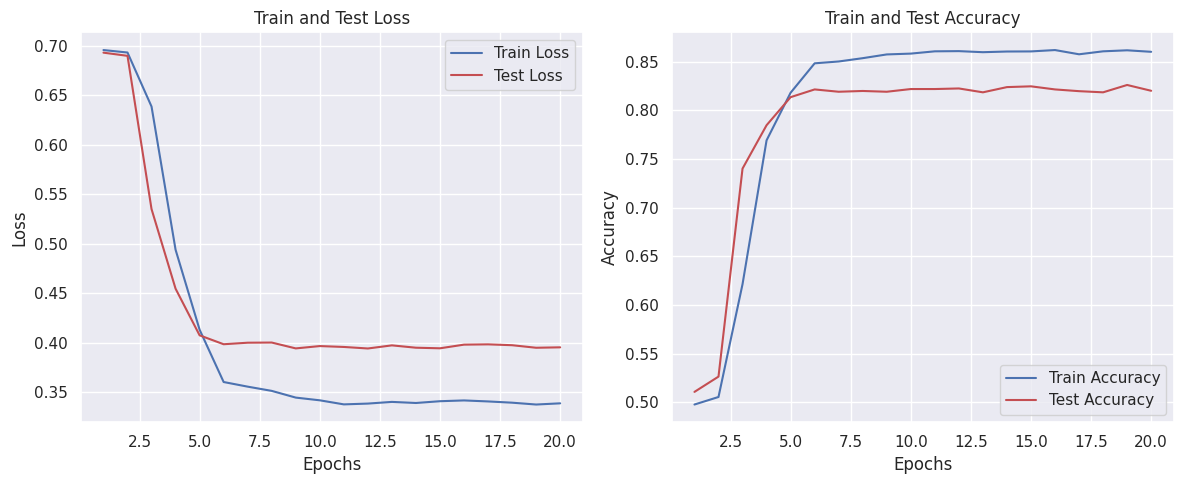

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

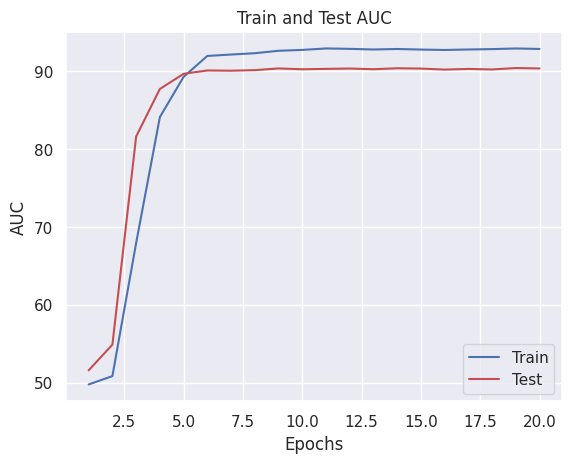

In [19]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [20]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(epochs, train_auc, label="Classical Training", color="purple")
# ax.plot(epochs, test_auc, label="Classical Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)